In [1]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = '/content/drive/My Drive/Colab Notebooks/matsuoo/dl/event_camera_repo'
%cd {project_dir}

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/matsuoo/dl/event_camera_repo


In [2]:
!pip install hydra-core omegaconf hdf5plugin h5py numba imageio imageio-ffmpeg tqdm torchvision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.5 MB/s eta 0:00:00


In [3]:
import torch
import hydra
from omegaconf import DictConfig
from torch.utils.data import DataLoader
import random
import numpy as np
from enum import Enum, auto
from tqdm import tqdm
from pathlib import Path
from typing import Dict, Any
import os
import time

import math
from pathlib import PurePath
from typing import Tuple
import cv2
import hdf5plugin
import h5py
from numba import jit
import imageio
imageio.plugins.freeimage.download()
import imageio.v3 as iio
from torchvision.transforms import RandomCrop
from torchvision import transforms as tf
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

from torch import nn

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [4]:
!pip install einops
from einops.layers.torch import Rearrange
from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 832.2 kB/s eta 0:00:00


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## `utils.py`

In [15]:
def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

class RepresentationType(Enum):
    VOXEL = auto()
    STEPAN = auto()


class EventRepresentation:
    def __init__(self):
        pass

    def convert(self, events):
        raise NotImplementedError


class VoxelGrid(EventRepresentation):
    def __init__(self, input_size: tuple, normalize: bool):
        assert len(input_size) == 3
        self.voxel_grid = torch.zeros(
            (input_size), dtype=torch.float, requires_grad=False)
        self.nb_channels = input_size[0]
        self.normalize = normalize

    def convert(self, events):
        C, H, W = self.voxel_grid.shape
        with torch.no_grad():
            self.voxel_grid = self.voxel_grid.to(events['p'].device)
            voxel_grid = self.voxel_grid.clone()

            t_norm = events['t']
            t_norm = (C - 1) * (t_norm-t_norm[0]) / (t_norm[-1]-t_norm[0])

            x0 = events['x'].int()
            y0 = events['y'].int()
            t0 = t_norm.int()

            value = 2*events['p']-1
            #start_t = time()
            for xlim in [x0, x0+1]:
                for ylim in [y0, y0+1]:
                    for tlim in [t0, t0+1]:

                        mask = (xlim < W) & (xlim >= 0) & (ylim < H) & (
                            ylim >= 0) & (tlim >= 0) & (tlim < self.nb_channels)
                        interp_weights = value * (1 - (xlim-events['x']).abs()) * (
                            1 - (ylim-events['y']).abs()) * (1 - (tlim - t_norm).abs())
                        index = H * W * tlim.long() + \
                            W * ylim.long() + \
                            xlim.long()

                        voxel_grid.put_(
                            index[mask], interp_weights[mask], accumulate=True)

            if self.normalize:
                mask = torch.nonzero(voxel_grid, as_tuple=True)
                if mask[0].size()[0] > 0:
                    mean = voxel_grid[mask].mean()
                    std = voxel_grid[mask].std()
                    if std > 0:
                        voxel_grid[mask] = (voxel_grid[mask] - mean) / std
                    else:
                        voxel_grid[mask] = voxel_grid[mask] - mean

        return voxel_grid


class PolarityCount(EventRepresentation):
    def __init__(self, input_size: tuple):
        assert len(input_size) == 3
        self.voxel_grid = torch.zeros(
            (input_size), dtype=torch.float, requires_grad=False)
        self.nb_channels = input_size[0]

    def convert(self, events):
        C, H, W = self.voxel_grid.shape
        with torch.no_grad():
            self.voxel_grid = self.voxel_grid.to(events['p'].device)
            voxel_grid = self.voxel_grid.clone()

            x0 = events['x'].int()
            y0 = events['y'].int()

            #start_t = time()
            for xlim in [x0, x0+1]:
                for ylim in [y0, y0+1]:
                    mask = (xlim < W) & (xlim >= 0) & (ylim < H) & (
                        ylim >= 0)
                    interp_weights = (1 - (xlim-events['x']).abs()) * (
                        1 - (ylim-events['y']).abs())
                    index = H * W * events['p'].long() + \
                        W * ylim.long() + \
                        xlim.long()

                    voxel_grid.put_(
                        index[mask], interp_weights[mask], accumulate=True)

        return voxel_grid


def flow_16bit_to_float(flow_16bit: np.ndarray):
    assert flow_16bit.dtype == np.uint16
    assert flow_16bit.ndim == 3
    h, w, c = flow_16bit.shape
    assert c == 3

    valid2D = flow_16bit[..., 2] == 1
    assert valid2D.shape == (h, w)
    assert np.all(flow_16bit[~valid2D, -1] == 0)
    valid_map = np.where(valid2D)

    # to actually compute something useful:
    flow_16bit = flow_16bit.astype('float')

    flow_map = np.zeros((h, w, 2))
    flow_map[valid_map[0], valid_map[1], 0] = (
        flow_16bit[valid_map[0], valid_map[1], 0] - 2 ** 15) / 128
    flow_map[valid_map[0], valid_map[1], 1] = (
        flow_16bit[valid_map[0], valid_map[1], 1] - 2 ** 15) / 128
    return flow_map, valid2D

In [16]:
def warp_images_with_flow(images, flow):
    dim3 = 0
    if images.dim() == 3:
        dim3 = 1
        images = images.unsqueeze(0)
        flow = flow.unsqueeze(0)
    height = images.shape[2]
    width = images.shape[3]
    flow_x,flow_y = flow[:,0,...],flow[:,1,...]
    coord_x, coord_y = torch.meshgrid(torch.arange(height), torch.arange(width))

    if torch.cuda.is_available():
        pos_x = coord_x.reshape(height,width).type(torch.float32).cuda() + flow_x
        pos_y = coord_y.reshape(height,width).type(torch.float32).cuda() + flow_y
    else: # Troubleshoot without cuda
        pos_x = coord_x.reshape(height,width).type(torch.float32) + flow_x
        pos_y = coord_y.reshape(height,width).type(torch.float32) + flow_y
    pos_x = (pos_x-(height-1)/2)/((height-1)/2)
    pos_y = (pos_y-(width-1)/2)/((width-1)/2)

    pos = torch.stack((pos_y,pos_x),3).type(torch.float32)
    result = torch.nn.functional.grid_sample(images, pos, mode='bilinear', padding_mode='zeros')
    if dim3 == 1:
        result = result.squeeze()

    return result

def charbonnier_loss(delta, alpha=0.45, epsilon=1e-3):
        loss = torch.mean(torch.pow((delta ** 2 + epsilon ** 2), alpha))
        return loss

def compute_smoothness_loss(flow):

    flow_ucrop = flow[..., 1:]
    flow_dcrop = flow[..., :-1]
    flow_lcrop = flow[..., 1:, :]
    flow_rcrop = flow[..., :-1, :]

    flow_ulcrop = flow[..., 1:, 1:]
    flow_drcrop = flow[..., :-1, :-1]
    flow_dlcrop = flow[..., :-1, 1:]
    flow_urcrop = flow[..., 1:, :-1]

    smoothness_loss = charbonnier_loss(flow_lcrop - flow_rcrop) +\
                      charbonnier_loss(flow_ucrop - flow_dcrop) +\
                      charbonnier_loss(flow_ulcrop - flow_drcrop) +\
                      charbonnier_loss(flow_dlcrop - flow_urcrop)
    smoothness_loss /= 4.

    return smoothness_loss

def compute_photometric_loss(prev_images, next_images, flow_dict):
    total_photometric_loss = 0.
    loss_weight_sum = 0.
    for i in range(len(flow_dict)):
        for image_num in range(prev_images.shape[0]):
            flow = flow_dict["flow{}".format(i)][image_num]
            height = flow.shape[1]
            width = flow.shape[2]

            prev_images_resize = F.to_tensor(F.resize(F.to_pil_image(prev_images[image_num].cpu()),
                                                    [height, width]))
            next_images_resize = F.to_tensor(F.resize(F.to_pil_image(next_images[image_num].cpu()),
                                                    [height, width]))

            if torch.cuda.is_available():
                prev_images_resize = prev_images_resize.cuda()
                next_images_resize = next_images_resize.cuda()

            next_images_warped = warp_images_with_flow(next_images_resize, flow)

            distance = next_images_warped - prev_images_resize
            photometric_loss = charbonnier_loss(distance)
            total_photometric_loss += photometric_loss
        loss_weight_sum += 1.
    total_photometric_loss /= loss_weight_sum

    return total_photometric_loss


class TotalLoss(torch.nn.Module):
    def __init__(self, smoothness_weight, weight_decay_weight=1e-4):
        super(TotalLoss, self).__init__()
        self._smoothness_weight = smoothness_weight
        self._weight_decay_weight = weight_decay_weight

    def forward(self, flow_dict, prev_image, next_image, EVFlowNet_model):
        # weight decay loss
        weight_decay_loss = 0
        for i in EVFlowNet_model.parameters():
            weight_decay_loss += torch.sum(i ** 2) / 2 * self._weight_decay_weight

        # smoothness loss
        smoothness_loss = 0
        for i in range(len(flow_dict)):
            smoothness_loss += compute_smoothness_loss(flow_dict["flow{}".format(i)])
        smoothness_loss *= self._smoothness_weight / 4.

        # Photometric loss.
        photometric_loss = compute_photometric_loss(prev_image,
                                                    next_image,
                                                    flow_dict)

        # Warped next image for debugging.
        #next_image_warped = warp_images_with_flow(next_image,
        #                                          flow_dict['flow3'])

        loss = weight_decay_loss + photometric_loss + smoothness_loss

        return loss

## Logging

```python
import sys
import logging
import datetime
import time

class StreamToLogger:
    def __init__(self, logger, log_level=logging.INFO):
        self.logger = logger
        self.log_level = log_level
        self.linebuf = ''

    def write(self, buf):
        for line in buf.rstrip().splitlines():
            self.logger.log(self.log_level, line.rstrip())
            sys.__stdout__.write(line + '\n')

    def flush(self):
        pass

# Create logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create file handler which logs even debug messages
current_time = time.strftime("%Y%m%d-%H%M%S")
logfile = f'../../logs/log_{current_time}.log'
fh = logging.FileHandler(logfile)
fh.setLevel(logging.DEBUG)

# Create console handler with a higher log level
ch = logging.StreamHandler(sys.__stdout__)
ch.setLevel(logging.INFO)

# Create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

# Ensure the log file is created
with open(logfile, 'w') as file:
    file.write('')  # Create an empty log file

# Redirect stdout and stderr to the logger
sys.stdout = StreamToLogger(logger, logging.INFO)
sys.stderr = StreamToLogger(logger, logging.ERROR)
```

## `datasets.py`

In [17]:
VISU_INDEX = 1


class EventSlicer:
    def __init__(self, h5f: h5py.File):
        self.h5f = h5f

        self.events = dict()
        for dset_str in ['p', 'x', 'y', 't']:
            self.events[dset_str] = self.h5f['events/{}'.format(dset_str)]

        # This is the mapping from milliseconds to event index:
        # It is defined such that
        # (1) t[ms_to_idx[ms]] >= ms*1000
        # (2) t[ms_to_idx[ms] - 1] < ms*1000
        # ,where 'ms' is the time in milliseconds and 't' the event timestamps in microseconds.
        #
        # As an example, given 't' and 'ms':
        # t:    0     500    2100    5000    5000    7100    7200    7200    8100    9000
        # ms:   0       1       2       3       4       5       6       7       8       9
        #
        # we get
        #
        # ms_to_idx:
        #       0       2       2       3       3       3       5       5       8       9
        self.ms_to_idx = np.asarray(self.h5f['ms_to_idx'], dtype='int64')

        self.t_offset = int(h5f['t_offset'][()])
        self.t_final = int(self.events['t'][-1]) + self.t_offset

    def get_final_time_us(self):
        return self.t_final

    def get_events(self, t_start_us: int, t_end_us: int) -> Dict[str, np.ndarray]:
        """Get events (p, x, y, t) within the specified time window
        Parameters
        ----------
        t_start_us: start time in microseconds
        t_end_us: end time in microseconds
        Returns
        -------
        events: dictionary of (p, x, y, t) or None if the time window cannot be retrieved
        """
        assert t_start_us < t_end_us

        # We assume that the times are top-off-day, hence subtract offset:
        t_start_us -= self.t_offset
        t_end_us -= self.t_offset

        t_start_ms, t_end_ms = self.get_conservative_window_ms(
            t_start_us, t_end_us)
        t_start_ms_idx = self.ms2idx(t_start_ms)
        t_end_ms_idx = self.ms2idx(t_end_ms)
        if t_start_ms_idx is None or t_end_ms_idx is None:
            print('Error', 'start', t_start_us, 'end', t_end_us)
            # Cannot guarantee window size anymore
            return None

        events = dict()
        time_array_conservative = np.asarray(
            self.events['t'][t_start_ms_idx:t_end_ms_idx])
        idx_start_offset, idx_end_offset = self.get_time_indices_offsets(
            time_array_conservative, t_start_us, t_end_us)
        t_start_us_idx = t_start_ms_idx + idx_start_offset
        t_end_us_idx = t_start_ms_idx + idx_end_offset
        # Again add t_offset to get gps time
        events['t'] = time_array_conservative[idx_start_offset:idx_end_offset] + self.t_offset
        for dset_str in ['p', 'x', 'y']:
            events[dset_str] = np.asarray(
                self.events[dset_str][t_start_us_idx:t_end_us_idx])
            assert events[dset_str].size == events['t'].size
        return events

    @staticmethod
    def get_conservative_window_ms(ts_start_us: int, ts_end_us) -> Tuple[int, int]:
        """Compute a conservative time window of time with millisecond resolution.
        We have a time to index mapping for each millisecond. Hence, we need
        to compute the lower and upper millisecond to retrieve events.
        Parameters
        ----------
        ts_start_us:    start time in microseconds
        ts_end_us:      end time in microseconds
        Returns
        -------
        window_start_ms:    conservative start time in milliseconds
        window_end_ms:      conservative end time in milliseconds
        """
        assert ts_end_us > ts_start_us
        window_start_ms = math.floor(ts_start_us/1000)
        window_end_ms = math.ceil(ts_end_us/1000)
        return window_start_ms, window_end_ms

    @staticmethod
    @jit(nopython=True)
    def get_time_indices_offsets(
            time_array: np.ndarray,
            time_start_us: int,
            time_end_us: int) -> Tuple[int, int]:
        """Compute index offset of start and end timestamps in microseconds
        Parameters
        ----------
        time_array:     timestamps (in us) of the events
        time_start_us:  start timestamp (in us)
        time_end_us:    end timestamp (in us)
        Returns
        -------
        idx_start:  Index within this array corresponding to time_start_us
        idx_end:    Index within this array corresponding to time_end_us
        such that (in non-edge cases)
        time_array[idx_start] >= time_start_us
        time_array[idx_end] >= time_end_us
        time_array[idx_start - 1] < time_start_us
        time_array[idx_end - 1] < time_end_us
        this means that
        time_start_us <= time_array[idx_start:idx_end] < time_end_us
        """

        assert time_array.ndim == 1

        idx_start = -1
        if time_array[-1] < time_start_us:

            # Return same index twice: array[x:x] is empty.
            return time_array.size, time_array.size
        else:
            for idx_from_start in range(0, time_array.size, 1):
                if time_array[idx_from_start] >= time_start_us:
                    idx_start = idx_from_start
                    break
        assert idx_start >= 0

        idx_end = time_array.size
        for idx_from_end in range(time_array.size - 1, -1, -1):
            if time_array[idx_from_end] >= time_end_us:
                idx_end = idx_from_end
            else:
                break

        assert time_array[idx_start] >= time_start_us
        if idx_end < time_array.size:
            assert time_array[idx_end] >= time_end_us
        if idx_start > 0:
            assert time_array[idx_start - 1] < time_start_us
        if idx_end > 0:
            assert time_array[idx_end - 1] < time_end_us
        return idx_start, idx_end

    def ms2idx(self, time_ms: int) -> int:
        assert time_ms >= 0
        if time_ms >= self.ms_to_idx.size:
            return None
        return self.ms_to_idx[time_ms]


class Sequence(Dataset):
    def __init__(self, seq_path: Path, representation_type: RepresentationType, mode: str = 'test', delta_t_ms: int = 100,
                 num_bins: int = 4, transforms=[], name_idx=0, visualize=False, load_gt=False):
        assert num_bins >= 1
        assert delta_t_ms == 100
        assert seq_path.is_dir(), seq_path
        assert mode in {'train', 'test'}
        assert representation_type is not None
        '''
        ディレクトリ構造:

        data
        ├─test
        |  ├─seq_1
        |  |    ├─events_left
        |  |    |   ├─events.h5
        |  |    |   └─rectify_map.h5
        |  |    └─forward_timestamps.txt
        └─train
            ├─seq_1
            |    ├─events_left
            |    |       ├─ events.h5
            |    |       └─ rectify_map.h5
            |    ├─flow_forward
            |    |       ├─ 000134.png
            |    |       |.....
            |    └─forward_timestamps.txt
            ├─seq_2
            └─seq_3
        '''
        self.seq_name = PurePath(seq_path).name
        self.mode = mode
        self.name_idx = name_idx
        self.visualize_samples = visualize
        self.load_gt = load_gt
        self.transforms = transforms
        if self.mode == "test":
            assert load_gt == False
            # Get Test Timestamp File
            ev_dir_location = seq_path / 'events_left'
            timestamp_file = seq_path / 'forward_timestamps.txt'
            flow_path = seq_path / 'flow_forward'
            timestamps_flow = np.loadtxt(
                seq_path / 'forward_timestamps.txt', delimiter=',', dtype='int64')
            self.indices = np.arange(len(timestamps_flow))
            self.timestamps_flow = timestamps_flow[:, 0]

        elif self.mode == "train":
            ev_dir_location = seq_path / 'events_left'
            flow_path = seq_path / 'flow_forward'
            timestamp_file = seq_path / 'forward_timestamps.txt'
            self.flow_png = [Path(os.path.join(flow_path, img)) for img in sorted(
                os.listdir(flow_path))]
            timestamps_flow = np.loadtxt(
                seq_path / 'forward_timestamps.txt', delimiter=',', dtype='int64')
            self.indices = np.arange(len(timestamps_flow))
            self.timestamps_flow = timestamps_flow[:, 0]
        else:
            pass
        assert timestamp_file.is_file()

        file = np.genfromtxt(
            timestamp_file,
            delimiter=','
        )

        self.idx_to_visualize = file[:, 2] if file.shape[1] == 3 else []

        # Save output dimensions
        self.height = 480
        self.width = 640
        self.num_bins = num_bins


        # Set event representation
        self.voxel_grid = VoxelGrid(
                (self.num_bins, self.height, self.width), normalize=True)
        self.delta_t_us = delta_t_ms * 1000

        # Left events only
        ev_data_file = ev_dir_location / 'events.h5'
        ev_rect_file = ev_dir_location / 'rectify_map.h5'

        h5f_location = h5py.File(str(ev_data_file), 'r')
        self.h5f = h5f_location
        self.event_slicer = EventSlicer(h5f_location)

        self.h5rect = h5py.File(str(ev_rect_file), 'r')
        self.rectify_ev_map = self.h5rect['rectify_map'][()]


    def events_to_voxel_grid(self, p, t, x, y, device: str = 'cpu'):
        t = (t - t[0]).astype('float32')
        t = (t/t[-1])
        x = x.astype('float32')
        y = y.astype('float32')
        pol = p.astype('float32')
        event_data_torch = {
            'p': torch.from_numpy(pol),
            't': torch.from_numpy(t),
            'x': torch.from_numpy(x),
            'y': torch.from_numpy(y),
        }
        return self.voxel_grid.convert(event_data_torch)

    def getHeightAndWidth(self):
        return self.height, self.width

    @staticmethod
    def get_disparity_map(filepath: Path):
        assert filepath.is_file()
        disp_16bit = cv2.imread(str(filepath), cv2.IMREAD_ANYDEPTH)
        return disp_16bit.astype('float32')/256

    @staticmethod
    def load_flow(flowfile: Path):
        assert flowfile.exists()
        assert flowfile.suffix == '.png'
        flow_16bit = iio.imread(str(flowfile), plugin='PNG-FI')
        flow, valid2D = flow_16bit_to_float(flow_16bit)
        return flow, valid2D

    @staticmethod
    def close_callback(h5f):
        h5f.close()

    def get_image_width_height(self):
        return self.height, self.width

    def __len__(self):
        # Ignore the first and last images as their own
        return len(self.timestamps_flow) # - 2

    def rectify_events(self, x: np.ndarray, y: np.ndarray):
        # assert location in self.locations
        # From distorted to undistorted
        rectify_map = self.rectify_ev_map
        assert rectify_map.shape == (
            self.height, self.width, 2), rectify_map.shape
        assert x.max() < self.width
        assert y.max() < self.height
        return rectify_map[y, x]

    def get_data(self, index) -> Dict[str, any]:
        # Adjust index to skip the first element
#         index += 1

        ts_start: int = self.timestamps_flow[index] - self.delta_t_us
        ts_end: int = self.timestamps_flow[index]

        file_index = self.indices[index]

        output = {
            'file_index': file_index,
            'timestamp': self.timestamps_flow[index],
            'seq_name': self.seq_name
        }
        # Save sample for benchmark submission
        output['save_submission'] = file_index in self.idx_to_visualize
        output['visualize'] = self.visualize_samples
        event_data = self.event_slicer.get_events(
            ts_start, ts_end)
        p = event_data['p']
        t = event_data['t']
        x = event_data['x']
        y = event_data['y']

        xy_rect = self.rectify_events(x, y)
        x_rect = xy_rect[:, 0]
        y_rect = xy_rect[:, 1]

        if self.voxel_grid is None:
            raise NotImplementedError
        else:
            event_representation = self.events_to_voxel_grid(
                p, t, x_rect, y_rect)
            output['event_volume'] = event_representation
        output['name_map'] = self.name_idx

        if self.load_gt:
            output['flow_gt'] = [torch.tensor(x) for x in self.load_flow(self.flow_png[index])]
            output['flow_gt'][0] = torch.moveaxis(output['flow_gt'][0], -1, 0)
            output['flow_gt'][1] = torch.unsqueeze(output['flow_gt'][1], 0)

            flow_gt_shape = [tensor.shape for tensor in output['flow_gt']]
            zero_flow_gt = [torch.zeros_like(tensor) for tensor in output['flow_gt']]

            # Load previous image
            if index > 0:
                output['prev_flow_gt'] = [torch.tensor(x) for x in self.load_flow(self.flow_png[index - 1])]
                output['prev_flow_gt'][0] = torch.moveaxis(output['prev_flow_gt'][0], -1, 0)
                output['prev_flow_gt'][1] = torch.unsqueeze(output['prev_flow_gt'][1], 0)
            else:
                output['prev_flow_gt'] = zero_flow_gt

            # Load next image
            if index < len(self.timestamps_flow) - 1:
                output['next_flow_gt'] = [torch.tensor(x) for x in self.load_flow(self.flow_png[index + 1])]
                output['next_flow_gt'][0] = torch.moveaxis(output['next_flow_gt'][0], -1, 0)
                output['next_flow_gt'][1] = torch.unsqueeze(output['next_flow_gt'][1], 0)
            else:
                output['next_flow_gt'] = zero_flow_gt

        return output

    def __getitem__(self, idx):
        # Adjust index to skip the first element
        sample = self.get_data(idx) # idx + 1

        if self.transforms:
            sample = self.transforms(sample)

        return sample

    def get_voxel_grid(self, idx):

        if idx == 0:
            event_data = self.event_slicer.get_events(
                self.timestamps_flow[0] - self.delta_t_us, self.timestamps_flow[0])
        elif idx > 0 and idx <= self.__len__():
            event_data = self.event_slicer.get_events(
                self.timestamps_flow[idx-1], self.timestamps_flow[idx-1] + self.delta_t_us)
        else:
            raise IndexError

        p = event_data['p']
        t = event_data['t']
        x = event_data['x']
        y = event_data['y']

        xy_rect = self.rectify_events(x, y)
        x_rect = xy_rect[:, 0]
        y_rect = xy_rect[:, 1]
        return self.events_to_voxel_grid(p, t, x_rect, y_rect)

    def get_event_count_image(self, ts_start, ts_end, num_bins, normalize=True):
        assert ts_end > ts_start
        delta_t_bin = (ts_end - ts_start) / num_bins
        ts_start_bin = np.linspace(
            ts_start, ts_end, num=num_bins, endpoint=False)
        ts_end_bin = ts_start_bin + delta_t_bin
        assert abs(ts_end_bin[-1] - ts_end) < 10.
        ts_end_bin[-1] = ts_end

        event_count = torch.zeros(
            (num_bins, self.height, self.width), dtype=torch.float, requires_grad=False)

        for i in range(num_bins):
            event_data = self.event_slicer.get_events(
                ts_start_bin[i], ts_end_bin[i])
            p = event_data['p']
            t = event_data['t']
            x = event_data['x']
            y = event_data['y']

            t = (t - t[0]).astype('float32')
            t = (t/t[-1])
            x = x.astype('float32')
            y = y.astype('float32')
            pol = p.astype('float32')
            event_data_torch = {
                'p': torch.from_numpy(pol),
                't': torch.from_numpy(t),
                'x': torch.from_numpy(x),
                'y': torch.from_numpy(y),
            }
            x = event_data_torch['x']
            y = event_data_torch['y']
            xy_rect = self.rectify_events(x.int(), y.int())
            x_rect = torch.from_numpy(xy_rect[:, 0]).long()
            y_rect = torch.from_numpy(xy_rect[:, 1]).long()
            value = 2*event_data_torch['p']-1
            index = self.width*y_rect + x_rect
            mask = (x_rect < self.width) & (y_rect < self.height)
            event_count[i].put_(index[mask], value[mask], accumulate=True)

        return event_count

    @staticmethod
    def normalize_tensor(event_count):
        mask = torch.nonzero(event_count, as_tuple=True)
        if mask[0].size()[0] > 0:
            mean = event_count[mask].mean()
            std = event_count[mask].std()
            if std > 0:
                event_count[mask] = (event_count[mask] - mean) / std
            else:
                event_count[mask] = event_count[mask] - mean
        return event_count


class SequenceRecurrent(Sequence):
    def __init__(self, seq_path: Path, representation_type: RepresentationType, mode: str = 'test', delta_t_ms: int = 100,
                 num_bins: int = 15, transforms=None, sequence_length=1, name_idx=0, visualize=False, load_gt=False):
        super(SequenceRecurrent, self).__init__(seq_path, representation_type, mode, delta_t_ms, transforms=transforms,
                                                name_idx=name_idx, visualize=visualize, load_gt=load_gt)
        self.crop_size = self.transforms['randomcrop'] if 'randomcrop' in self.transforms else None
        self.sequence_length = sequence_length
        self.valid_indices = self.get_continuous_sequences()

    def get_continuous_sequences(self):
        continuous_seq_idcs = []
        if self.sequence_length > 1:
            for i in range(len(self.timestamps_flow)-self.sequence_length+1):
                diff = self.timestamps_flow[i + self.sequence_length-1] - self.timestamps_flow[i]
                if diff < np.max([100000 * (self.sequence_length-1) + 1000, 101000]):
                    continuous_seq_idcs.append(i)
        else:
            for i in range(len(self.timestamps_flow)-1):
                diff = self.timestamps_flow[i+1] - self.timestamps_flow[i]
                if diff < np.max([100000 * (self.sequence_length-1) + 1000, 101000]):
                    continuous_seq_idcs.append(i)
        return continuous_seq_idcs

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        assert idx >= 0
        assert idx < len(self)

        # Valid index is the actual index we want to load, which guarantees a continuous sequence length
        valid_idx = self.valid_indices[idx]

        sequence = []
        j = valid_idx

        ts_cur = self.timestamps_flow[j]
        # Add first sample
        sample = self.get_data_sample(j)
        sequence.append(sample)

        # Data augmentation according to first sample
        crop_window = None
        flip = None
        if 'crop_window' in sample.keys():
            crop_window = sample['crop_window']
        if 'flipped' in sample.keys():
            flip = sample['flipped']

        for i in range(self.sequence_length-1):
            j += 1
            ts_old = ts_cur
            ts_cur = self.timestamps_flow[j]
            assert(ts_cur-ts_old < 100000 + 1000)
            sample = self.get_data_sample(
                j, crop_window=crop_window, flip=flip)
            sequence.append(sample)

        # Check if the current sample is the first sample of a continuous sequence
        if idx == 0 or self.valid_indices[idx]-self.valid_indices[idx-1] != 1:
            sequence[0]['new_sequence'] = 1
            print("Timestamp {} is the first one of the next seq!".format(
                self.timestamps_flow[self.valid_indices[idx]]))
        else:
            sequence[0]['new_sequence'] = 0

        # random crop
        if self.crop_size is not None:
            i, j, h, w = RandomCrop.get_params(
                sample["event_volume_old"], output_size=self.crop_size)
            keys_to_crop = ["event_volume_old", "event_volume_new",
                            "flow_gt_event_volume_old", "flow_gt_event_volume_new",
                            "flow_gt_next",]

            for sample in sequence:
                for key, value in sample.items():
                    if key in keys_to_crop:
                        if isinstance(value, torch.Tensor):
                            sample[key] = tf.functional.crop(value, i, j, h, w)
                        elif isinstance(value, list) or isinstance(value, tuple):
                            sample[key] = [tf.functional.crop(v, i, j, h, w) for v in value]
        return sequence


class DatasetProvider:
    def __init__(self, dataset_path: Path, representation_type: RepresentationType, delta_t_ms: int = 100, num_bins=4, config=None, visualize=False, transforms=None):
        test_path = Path(os.path.join(dataset_path, 'test'))
        train_path = Path(os.path.join(dataset_path, 'train'))
        assert dataset_path.is_dir(), str(dataset_path)
        assert test_path.is_dir(), str(test_path)
        assert delta_t_ms == 100
        self.config = config
        self.name_mapper_test = []

        if transforms:
            self.transforms = transforms
        else:
            self.transforms = tf.Compose([
                transforms.ToTensor(),  # Convert image to PyTorch tensor
            ])

        # Assemble test sequences
        test_sequences = list()
        for child in test_path.iterdir():
            self.name_mapper_test.append(str(child).split("/")[-1])
            test_sequences.append(Sequence(child, representation_type, 'test', delta_t_ms, num_bins,
                                               name_idx=len(self.name_mapper_test) - 1,
                                               visualize=visualize,
                                               transforms=self.transforms))

        self.test_dataset = torch.utils.data.ConcatDataset(test_sequences)

        # Assemble train sequences
        available_seqs = os.listdir(train_path)

        seqs = available_seqs

        train_sequences: list[Sequence] = []
        for seq in seqs:
            extra_arg = dict()
            train_sequences.append(Sequence(Path(train_path) / seq,
                                   representation_type=representation_type, mode="train",
                                   load_gt=True, **extra_arg, transforms=self.transforms))
            self.train_dataset: torch.utils.data.ConcatDataset[Sequence] = torch.utils.data.ConcatDataset(train_sequences)

    def get_test_dataset(self):
        return self.test_dataset

    def get_train_dataset(self):
        return self.train_dataset

    def get_name_mapping_test(self):
        return self.name_mapper_test

    def summary(self, logger):
        logger.write_line(
            "================================== Dataloader Summary ====================================", True)
        logger.write_line("Loader Type:\t\t" + self.__class__.__name__, True)
        logger.write_line("Number of Voxel Bins: {}".format(
            self.test_dataset.datasets[0].num_bins), True)
        logger.write_line("Number of Train Sequences: {}".format(
            len(self.train_dataset)), True)

def train_collate(sample_list):
    batch = dict()
    for field_name in sample_list[0]:
        if field_name == 'timestamp':
            batch['timestamp'] = [sample[field_name] for sample in sample_list]
        if field_name == 'seq_name':
            batch['seq_name'] = [sample[field_name] for sample in sample_list]
        if field_name == 'new_sequence':
            batch['new_sequence'] = [sample[field_name]
                                     for sample in sample_list]
        if field_name.startswith("event_volume"):
            batch[field_name] = torch.stack(
                [sample[field_name] for sample in sample_list])
        if field_name.startswith("flow_gt") or field_name.startswith('prev_flow_gt') or field_name.startswith('next_flow_gt'):
            if all(field_name in x for x in sample_list):
                batch[field_name] = torch.stack(
                    [sample[field_name][0] for sample in sample_list])
                batch[field_name + '_valid_mask'] = torch.stack(
                    [sample[field_name][1] for sample in sample_list])

    return batch


def rec_train_collate(sample_list):
    seq_length = len(sample_list[0])
    seq_of_batch = []
    for i in range(seq_length):
        seq_of_batch.append(train_collate(
            [sample[i] for sample in sample_list]))
    return seq_of_batch

## PCLNet

## From the github

In [18]:
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        endpoint = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        endpoint.append(x) # output here

        x = self.maxpool(x)
        x = self.layer1(x)
        endpoint.append(x)
        x = self.layer2(x)
        endpoint.append(x)
        x = self.layer3(x)
        endpoint.append(x)
        x = self.layer4(x)
        endpoint.append(x)

        return endpoint


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        state = model.state_dict()
        state_ckp = model_zoo.load_url(model_urls['resnet18'])
        cnt = 0
        for k, val in state_ckp.items():
            if k in state.keys():
                state[k] = val
                cnt += 1
        model.load_state_dict(state)
        print ("RestNet checkpoint loaded: %d" % cnt)
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        state = model.state_dict()
        state_ckp = model_zoo.load_url(model_urls['resnet34'])
        cnt = 0
        for k, val in state_ckp.items():
            if k in state.keys():
                state[k] = val
                cnt += 1
        model.load_state_dict(state)
        print ("RestNet checkpoint loaded: %d" % cnt)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [19]:
from torch.autograd import Variable

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.bias = bias
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)
        self.Gates = nn.Conv2d(self.input_channels + self.hidden_channels , 4*self.hidden_channels,
                self.kernel_size, 1, self.padding, bias=True)

    def forward(self, x, h, c):

        stacked_inputs = torch.cat((x, h), 1)
        gates = self.Gates(stacked_inputs)

        # chunk across the channel dimension
        xi, xf, xo, xg = gates.chunk(4, 1)

        # apply sigmoid non linearity
        xi = torch.sigmoid(xi)
        xf = torch.sigmoid(xf)
        xo = torch.sigmoid(xo)
        xg = torch.tanh(xg)

        # compute current cell and hidden state
        c = (xf * c) + (xi * xg)
        h = xo * torch.tanh(c)

        return h, c

    def init_hidden(self, batch_size, hidden, shape):
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])))


class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1], bias=True):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.bias = bias
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size, self.bias)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        #input : (num, seq_len, channel, H,W)
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input[:, step, :,:,:]
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                            shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)
        return outputs, (x, new_c)

In [24]:
def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):
    if type(in_planes) == np.int64:
        in_planes = np.asscalar(in_planes)
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                  padding=padding, dilation=dilation, bias=True),
        nn.LeakyReLU(0.1))


def predict_flow(in_planes):
    if type(in_planes) == np.int64:
        in_planes = np.asscalar(in_planes)
    return nn.Conv2d(in_planes, 2, kernel_size=3, stride=1, padding=1, bias=True)


def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    if type(in_planes) == np.int64:
        in_planes = np.asscalar(in_planes)
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=True)


class PCLNet(nn.Module):
    """
    PCLNet: Unsupervised Learning for Optical Flow Estimation Using Pyramid Convolution LSTM
    Author: Shuosen Guan
    """

    def __init__(self, args):

        super(PCLNet, self).__init__()
        self.args = args

        snippet_len = args.snippet_len
        self.feature_net = eval(args.backbone)(pretrained=True, num_classes=args.class_num)
        if args.freeze_vgg:
            for p in self.feature_net.parameters():
                p.required_grad = False
            print("[>>>> Feature head frozen.<<<<]")

        # Motion Encoding
        # in_size: 1/2
        self.clstm_encoder_1 = ConvLSTM(input_channels=64, hidden_channels=[64],
                                        kernel_size=3, step=snippet_len, effective_step=list(range(snippet_len)))
        # in_size: 1/4
        self.clstm_encoder_2 = ConvLSTM(input_channels=64, hidden_channels=[64],
                                        kernel_size=3, step=snippet_len, effective_step=list(range(snippet_len)))
        # in_size: 1/8
        self.clstm_encoder_3 = ConvLSTM(input_channels=128, hidden_channels=[128],
                                        kernel_size=3, step=snippet_len, effective_step=list(range(snippet_len)))
        # in_size: 1/16
        self.clstm_encoder_4 = ConvLSTM(input_channels=256, hidden_channels=[256],
                                        kernel_size=3, step=snippet_len, effective_step=list(range(snippet_len)))

        self.conv_B1    = conv(64, 64, stride=1, kernel_size=3, padding=1)
        self.conv_S1_1  = conv(64, 64, stride=1, kernel_size=3, padding=1)
        self.conv_S1_2  = conv(64, 64, stride=1, kernel_size=3, padding=1)
        self.conv_D1    = conv(64, 64, stride=2)
        self.Pool1      = nn.MaxPool2d(8, 8)

        self.conv_B2    = conv(64, 64, stride=1, kernel_size=3, padding=1)
        self.conv_S2_1  = conv(64 + 64, 128, stride=1, kernel_size=3, padding=1)
        self.conv_S2_2  = conv(128, 128, stride=1, kernel_size=3, padding=1)
        self.conv_D2    = conv(128, 64, stride=2)
        self.Pool2      = nn.MaxPool2d(4, 4)

        self.conv_B3    = conv(128, 128, stride=1, kernel_size=3, padding=1)
        self.conv_S3_1  = conv(128 + 64, 128, stride=1, kernel_size=3, padding=1)
        self.conv_S3_2  = conv(128, 128, stride=1, kernel_size=3, padding=1)
        self.conv_D3    = conv(128, 64, stride=2)
        self.Pool3      = nn.MaxPool2d(2, 2)

        self.conv_B4    = conv(256, 128, stride=1, kernel_size=3, padding=1)
        self.conv_S4_1  = conv(128 + 64, 128, stride=1, kernel_size=3, padding=1)
        self.conv_S4_2  = conv(128, 128, stride=1, kernel_size=3, padding=1)

        # Motion feature
        self.conv_M = conv((64 + 128 + 128 + 128), 256, stride=1, kernel_size=3, padding=1)

        # Motion reconstruction
        if self.args.couple:
            rec_in_size = [0, 64 + 64 + 2, 128 + 128 + 2, 128 + 196 + 2, 128 + 256]
        else:
            rec_in_size = [0, 64 + 2, 128 + 2, 196 + 2, 256]

        self.conv_4     = conv(rec_in_size[4], 256)
        self.pred_flow4 = predict_flow(256)
        self.up_flow4   = deconv(2, 2)
        self.up_feat4   = deconv(256, 196)

        self.conv_3     = conv(rec_in_size[3], 196)
        self.pred_flow3 = predict_flow(196)
        self.up_flow3   = deconv(2, 2)
        self.up_feat3   = deconv(196, 128)

        self.conv_2     = conv(rec_in_size[2], 96)
        self.pred_flow2 = predict_flow(96)
        self.up_flow2   = conv(2, 2)
        self.up_feat2   = conv(96, 64)

        self.conv_1     = conv(rec_in_size[1], 64)
        self.pred_flow1 = predict_flow(64)

        self.dc_conv1 = conv(64, 64, kernel_size=3, stride=1, padding=1, dilation=1)
        self.dc_conv2 = conv(64, 64, kernel_size=3, stride=1, padding=2, dilation=2)
        self.dc_conv3 = conv(64, 64, kernel_size=3, stride=1, padding=4, dilation=4)
        self.dc_conv4 = conv(64, 64, kernel_size=3, stride=1, padding=8, dilation=8)
        self.dc_conv5 = conv(64, 64, kernel_size=3, stride=1, padding=16, dilation=16)
        self.dc_conv6 = conv(64, 32, kernel_size=3, stride=1, padding=1, dilation=1)
        self.dc_conv7 = predict_flow(32)


    def forward(self, x):

        if x.dim() == 6:    # (batch_size, K, snippet_len, channel, H, W)
            batch_size, K, snippet_len, channel, H, W = x.size()
        elif x.dim() == 5:  # (batch_size, snippet_len, channel, H, W)
            batch_size, snippet_len, channel, H, W = x.size()
            K = 1
        elif x.dim() == 4:  # (batch_size, channel * snippet_len, H, W)
            batch_size, _channels, H, W = x.size()
            K, channel = 1, 3
            snippet_len = _channels // channel
        else:
            raise RuntimeError('Input format not suppored!')

        x = x.contiguous().view(-1, channel, H, W)

        la1, la2, la3, la4, _ = self.feature_net(x)

        la1 = la1.view((-1, snippet_len) + la1.size()[1:])
        la2 = la2.view((-1, snippet_len) + la2.size()[1:])
        la3 = la3.view((-1, snippet_len) + la3.size()[1:])
        la4 = la4.view((-1, snippet_len) + la4.size()[1:])
        # la5 = la5.view((-1, snippet_len) + la5.size()[1:])

        h1, _ = self.clstm_encoder_1(la1)
        h2, _ = self.clstm_encoder_2(la2)
        h3, _ = self.clstm_encoder_3(la3)
        h4, _ = self.clstm_encoder_4(la4)
        # list for each step (batch_size * K, channel, H, W)

        # (batch_size * K*(snippet_len -1), channel, H, W)
        h1 = torch.stack(h1[1:], 1).view((-1,) + h1[0].size()[-3:])
        h2 = torch.stack(h2[1:], 1).view((-1,) + h2[0].size()[-3:])
        h3 = torch.stack(h3[1:], 1).view((-1,) + h3[0].size()[-3:])
        h4 = torch.stack(h4[1:], 1).view((-1,) + h4[0].size()[-3:])

        x1 = self.conv_B1(h1)
        x1 = self.conv_S1_2(self.conv_S1_1(x1))

        x2 = torch.cat((self.conv_B2(h2), self.conv_D1(x1)), 1)
        x2 = self.conv_S2_2(self.conv_S2_1(x2))

        x3 = torch.cat((self.conv_B3(h3), self.conv_D2(x2)), 1)
        x3 = self.conv_S3_2(self.conv_S3_1(x3))

        x4 = torch.cat((self.conv_B4(h4), self.conv_D3(x3)), 1)
        x4 = self.conv_S4_2(self.conv_S4_1(x4))

        xm = self.conv_M(torch.cat((self.Pool1(x1), self.Pool2(x2), self.Pool3(x3), x4), 1))

        rec_x4 = torch.cat((x4, xm), 1) if self.args.couple else xm
        x = self.conv_4(rec_x4)
        flow4 = self.pred_flow4(x)
        up_flow4 = self.up_flow4(flow4)
        up_feat4 = self.up_feat4(x)

        rec_x3 = torch.cat((x3, up_feat4, up_flow4), 1) if self.args.couple else torch.cat((up_feat4, up_flow4), 1)
        x = self.conv_3(rec_x3)
        flow3 = self.pred_flow3(x)
        up_flow3 = self.up_flow3(flow3)
        up_feat3 = self.up_feat3(x)

        rec_x2 = torch.cat((x2, up_feat3, up_flow3), 1) if self.args.couple else torch.cat((up_feat3, up_flow3), 1)
        x = self.conv_2(rec_x2)
        flow2 = self.pred_flow2(x)
        up_flow2 = self.up_flow2(flow2)
        up_feat2 = self.up_feat2(x)

        rec_x1 = torch.cat((x1, up_feat2, up_flow2), 1) if self.args.couple else torch.cat((up_feat2, up_flow2), 1)
        x = self.conv_1(rec_x1)
        flow1 = self.pred_flow1(x)

        x = self.dc_conv4(self.dc_conv3(self.dc_conv2(self.dc_conv1(x))))
        flow1 += self.dc_conv7(self.dc_conv6(self.dc_conv5(x)))

        # output size: (batch_size, K, snippet_len -1 , C,H,W)
        flow_pyramid = [flo.view((batch_size, K, snippet_len - 1,) + flo.size()[-3:])
                        for flo in [flow1, flow2, flow3, flow4]]
        re_dict = {}
        re_dict['flow_pyramid'] = flow_pyramid

        return re_dict

## Arguments & Definition

In [33]:
import argparse
args = argparse.Namespace(
    name='pclnet',
    snippet_len=2,
    backbone='resnet18',
    class_num=101,
    freeze_vgg=True,
    couple=False,

    lr=0.01, # 2e-5
    num_steps=100000,
    batch_size=1,
    image_size=[480, 640],
    mixed_precision=False,
    iters=12,
    wdecay=0.00005,
    epsilon=1e-8,
    clip=1.0,
    dropout=0.0,
    gamma=0.8,
    add_noise=False,
    seed=27,
    dataset_path='data/',
)

In [34]:
model = torch.nn.DataParallel(PCLNet(args).cpu())

RestNet checkpoint loaded: 100
[>>>> Feature head frozen.<<<<]


In [40]:
input_data = torch.randn(16, 4, 3, 480, 640)

In [41]:
batch_size, snippet_len, channel, H, W = input_data.size()

In [42]:
input_data = input_data.permute(0, 2, 1, 3, 4).contiguous().view(batch_size, snippet_len, channel, H, W)
input_data.shape

torch.Size([16, 4, 3, 480, 640])

In [ ]:
output = model(input_data)

## Image Preprocessing

In [28]:
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class DimensionalityReduction:
    def __init__(self, n_components, scaler=MinMaxScaler(), red_technique='pca'):
        self.scaler = scaler # if None, then doesn't perform any scaling
        self.n_components = n_components

        match red_technique:
            case 'pca':
                self.technique = PCA(n_components=n_components)
            case 'sparsepca':
                self.technique = SparsePCA(n_components=n_components)
            case 'tsvd':
                self.technique = TruncatedSVD(n_components=n_components)
            case _:
                raise NotImplementedError

    def __call__(self, image_tensor: torch.Tensor):
        # this is for a single image, not a batch of images
        C, H, W = image_tensor.shape

        tensor_reshaped = image_tensor.cpu().numpy().reshape(C, -1).T
        if self.scaler is not None:
            tensor_reshaped = self.scaler.fit_transform(tensor_reshaped)

        reduced_tensor_reshaped = self.technique.fit_transform(tensor_reshaped)
        reduced_tensor_reshaped = reduced_tensor_reshaped.T.reshape(self.n_components, H, W)

        reduced_tensor = torch.tensor(reduced_tensor_reshaped, device=image_tensor.device)
        return reduced_tensor

```python
a = torch.rand((4, 480, 640))
b = DimensionalityReduction(n_components=3, scaler=MinMaxScaler(), red_technique='tsvd')(a)
b.shape
```

In [29]:
# Needs to have 3 channels or color passed in
# runs into the problem of loss of information in dimensionality reduction
class HistogramEqualization:
    def __call__(self, img):
        return tf.functional.equalize(img)

In [30]:
class CombinedTransform:
    def __init__(self, transform=tf.Compose([ tf.ToTensor() ])):
        self.transform = transform

    def __call__(self, flow_dict):
        seed = np.random.randint(2147483647)

        # Just in case I decide to add more feature columns
        feaure_flow_columns = [c for c in flow_dict.keys() if 'event_volume' in c]

        for col in feaure_flow_columns:
            torch.manual_seed(seed)

            if type(flow_dict[col]) == list:
                flow_dict[col] = [ self.transform(img) for img in flow_dict[col] ]
            else:
                flow_dict[col] = self.transform(flow_dict[col])

        return flow_dict

combined_transform = CombinedTransform(
    transform=tf.Compose([
        tf.GaussianBlur(kernel_size=(5, 5)),
    ])
)

## `main.py`

Instead of changing the `Sequence`, just change how the data are loaded. Or iterate over the dataloader so that you use many images at once.

In [35]:
class RepresentationType(Enum):
    VOXEL = auto()
    STEPAN = auto()

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

def compute_epe_error(pred_flow: torch.Tensor, gt_flow: torch.Tensor):
    '''
    end-point-error (ground truthと予測値の二乗誤差)を計算
    pred_flow: torch.Tensor, Shape: torch.Size([B, 2, 480, 640]) => 予測したオプティカルフローデータ
    gt_flow: torch.Tensor, Shape: torch.Size([B, 2, 480, 640]) => 正解のオプティカルフローデータ
    '''
    epe = torch.mean(torch.mean(torch.norm(pred_flow - gt_flow, p=2, dim=1), dim=(1, 2)), dim=0)
    return epe

def save_optical_flow_to_npy(flow: torch.Tensor, file_name: str):
    '''
    optical flowをnpyファイルに保存
    flow: torch.Tensor, Shape: torch.Size([2, 480, 640]) => オプティカルフローデータ
    file_name: str => ファイル名
    '''
    np.save(f"{file_name}.npy", flow.cpu().numpy())

In [37]:
set_seed(args.seed)

'''
    ディレクトリ構造:

    data
    ├─test
    |  ├─test_city
    |  |    ├─events_left
    |  |    |   ├─events.h5
    |  |    |   └─rectify_map.h5
    |  |    └─forward_timestamps.txt
    └─train
        ├─zurich_city_11_a
        |    ├─events_left
        |    |       ├─ events.h5
        |    |       └─ rectify_map.h5
        |    ├─ flow_forward
        |    |       ├─ 000134.png
        |    |       |.....
        |    └─ forward_timestamps.txt
        ├─zurich_city_11_b
        └─zurich_city_11_c
    '''

# ------------------
#    Dataloader
# ------------------

loader = DatasetProvider(
    dataset_path=Path(args.dataset_path),
    representation_type=RepresentationType.VOXEL,
    delta_t_ms=100,
    num_bins=4,
    transforms=combined_transform # Custom class
)
train_set = loader.get_train_dataset()
test_set = loader.get_test_dataset()

# def split_train_valid(dataset):
#     train_indices = []
#     valid_indices = []
#     for idx in range(len(dataset)):
#         sample = dataset[idx]
#         if 'flow_gt_valid_mask' in sample and sample['flow_gt_valid_mask'].all():
#             valid_indices.append(idx)
#         else:
#             train_indices.append(idx)
#     train_subset = torch.utils.data.Subset(dataset, train_indices)
#     valid_subset = torch.utils.data.Subset(dataset, valid_indices)
#     return train_subset, valid_subset

# train_set_split, valid_set_split = split_train_valid(train_set)

collate_fn = train_collate
train_data = DataLoader(train_set, # train_set_split
                        batch_size=16, #
                        shuffle=False,
                        collate_fn=collate_fn,
                        drop_last=False,
                        num_workers=os.cpu_count(),
                        pin_memory=True)
test_data = DataLoader(test_set,
                       batch_size=1,
                       shuffle=False,
                       collate_fn=collate_fn,
                       drop_last=False,
                       num_workers=os.cpu_count(),
                       pin_memory=True)

'''
train data:
    Type of batch: Dict
    Key: seq_name, Type: list
    Key: event_volume, Type: torch.Tensor, Shape: torch.Size([Batch, 4, 480, 640]) => イベントデータのバッチ
    Key: flow_gt, Type: torch.Tensor, Shape: torch.Size([Batch, 2, 480, 640]) => オプティカルフローデータのバッチ
    Key: flow_gt_valid_mask, Type: torch.Tensor, Shape: torch.Size([Batch, 1, 480, 640]) => オプティカルフローデータのvalid. ベースラインでは使わない

test data:
    Type of batch: Dict
    Key: seq_name, Type: list
    Key: event_volume, Type: torch.Tensor, Shape: torch.Size([Batch, 4, 480, 640]) => イベントデータのバッチ
'''

'\ntrain data:\n    Type of batch: Dict\n    Key: seq_name, Type: list\n    Key: event_volume, Type: torch.Tensor, Shape: torch.Size([Batch, 4, 480, 640]) => イベントデータのバッチ\n    Key: flow_gt, Type: torch.Tensor, Shape: torch.Size([Batch, 2, 480, 640]) => オプティカルフローデータのバッチ\n    Key: flow_gt_valid_mask, Type: torch.Tensor, Shape: torch.Size([Batch, 1, 480, 640]) => オプティカルフローデータのvalid. ベースラインでは使わない\n\ntest data:\n    Type of batch: Dict\n    Key: seq_name, Type: list\n    Key: event_volume, Type: torch.Tensor, Shape: torch.Size([Batch, 4, 480, 640]) => イベントデータのバッチ\n'

In [38]:
# ------------------
#   optimizer
# ------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=args.wdecay, eps=args.epsilon)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, args.lr, args.num_steps + 100,
#                                                 pct_start=0.05, cycle_momentum=False, anneal_strategy='linear')

loss_fn = TotalLoss(smoothness_weight=0.5)

In [39]:
# num_epochs = args.train.epochs
num_epochs = 1

epe_losses = [[] for _ in range(num_epochs)]
overall_losses = [[] for _ in range(num_epochs)]

In [ ]:
BATCH_CONCAT = 2

In [ ]:
def reduce_batch_dim(input_tensor: torch.Tensor, dim: int):
    B, C, H, W = input_tensor.shape
    tensor_reshaped = input_tensor.permute(0, 2, 3, 1).reshape(B * H * W, C)

    tsvd = TruncatedSVD(n_components=dim)
    reduced_tensor_reshaped = tsvd.fit_transform(tensor_reshaped)

    reduced_tensor = torch.tensor(reduced_tensor_reshaped, device=input_tensor.device).reshape(B, H, W, dim).permute(0, 3, 1, 2)

    return reduced_tensor

In [ ]:
# ------------------
#   Start training
# ------------------
model.train()

for epoch in range(num_epochs):

    total_loss = 0
    prev_event_volumes = [torch.zeros([args.batch_size, 3, 480, 640])] # Acts as a queue

    print("on epoch: {}".format(epoch + 1))
    for i, batch in enumerate(tqdm(train_data)):

        try:
            batch: Dict[str, Any]

            event_image = batch["event_volume"].to(device) # [B, 3, 480, 640]
            ground_truth_flow = batch["flow_gt"].to(device) # [B, 2, 480, 640]

            prev_event_volumes.append(event_image)

            prev_ground_truth_flow = batch['prev_flow_gt'].to(device) # [B, 2, 480, 640]
            next_ground_truth_flow = batch['next_flow_gt'].to(device) # [B, 2, 480, 640]

            flows = model(prev_event_volumes[0],
                         prev_event_volumes[1],
                         iters=args.iters) # [B, 3, 480, 640]

            # Overall loss requires flow0, ..., flow3 so we don't implement it here
            # What if you created flow_dict from flow0, ..., flow11 (n=12) to and then use overall loss?

            print()
            for j, flow in enumerate(flows):
                print(f'batch {i} | flow #{j + 1} | EPE LOSS:', compute_epe_error(flow, ground_truth_flow).item())

            avg_flow = torch.mean(torch.stack(flows, dim=0), dim=0)
            epe_loss: torch.Tensor = compute_epe_error(avg_flow, ground_truth_flow)

            print(f"batch {i} average EPE LOSS: {epe_loss.item()}")
            epe_losses[epoch].append(epe_loss.item())

            optimizer.zero_grad()
            epe_loss.backward() # Change this to which loss function is to be updated
            optimizer.step()

            total_loss += epe_loss.item() # This too

            if len(prev_event_volumes) >= BATCH_CONCAT:
                prev_event_volumes.pop(0) # Remove first element

        except KeyboardInterrupt:
            current_time = time.strftime("%Y%m%d-%H%M%S")
            model_path = f"../../models/model_{current_time}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path}")

            raise SystemExit("KeyboardInterrupt")

    scheduler.step()

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_data)}')

on epoch: 1


  0%|          | 0/336 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


batch 0 | flow #1 | EPE LOSS: 8.665224853998806
batch 0 | flow #2 | EPE LOSS: 8.655190191741282
batch 0 | flow #3 | EPE LOSS: 7.620202816595744
batch 0 | flow #4 | EPE LOSS: 6.592811228633178
batch 0 | flow #5 | EPE LOSS: 6.015046058273764
batch 0 | flow #6 | EPE LOSS: 5.615552434148813
batch 0 | flow #7 | EPE LOSS: 5.35362252625018
batch 0 | flow #8 | EPE LOSS: 5.050601268962979
batch 0 | flow #9 | EPE LOSS: 4.617178101805345
batch 0 | flow #10 | EPE LOSS: 4.127171727828501
batch 0 | flow #11 | EPE LOSS: 3.7053065108698235
batch 0 | flow #12 | EPE LOSS: 3.3722322695325073
batch 0 average EPE LOSS: 4.8400707484085475


  0%|          | 1/336 [05:01<28:04:33, 301.71s/it]

batch 1 | flow #1 | EPE LOSS: 19.14768372354231
batch 1 | flow #2 | EPE LOSS: 19.589359778340427
batch 1 | flow #3 | EPE LOSS: 21.62149647547366
batch 1 | flow #4 | EPE LOSS: 24.295078936330096
batch 1 | flow #5 | EPE LOSS: 26.398977671458738
batch 1 | flow #6 | EPE LOSS: 27.583953103598787
batch 1 | flow #7 | EPE LOSS: 28.201270189883903
batch 1 | flow #8 | EPE LOSS: 28.740880142867905
batch 1 | flow #9 | EPE LOSS: 29.16502199973344
batch 1 | flow #10 | EPE LOSS: 29.51449314723368
batch 1 | flow #11 | EPE LOSS: 29.788746403239944
batch 1 | flow #12 | EPE LOSS: 29.993694205263115
batch 1 average EPE LOSS: 25.142931643099118


  1%|          | 2/336 [05:20<12:32:55, 135.26s/it]

batch 2 | flow #1 | EPE LOSS: 21.487205259667366
batch 2 | flow #2 | EPE LOSS: 22.848478155866605
batch 2 | flow #3 | EPE LOSS: 24.17999642029018
batch 2 | flow #4 | EPE LOSS: 25.42630798496165
batch 2 | flow #5 | EPE LOSS: 26.10369248688848
batch 2 | flow #6 | EPE LOSS: 25.966448073942633
batch 2 | flow #7 | EPE LOSS: 25.873290215861477
batch 2 | flow #8 | EPE LOSS: 25.918628033867876
batch 2 | flow #9 | EPE LOSS: 25.927862147490284
batch 2 | flow #10 | EPE LOSS: 25.889152441184432
batch 2 | flow #11 | EPE LOSS: 25.769820787020084
batch 2 | flow #12 | EPE LOSS: 25.551100401415454
batch 2 average EPE LOSS: 23.49068306209148


  1%|          | 3/336 [05:37<7:31:09, 81.29s/it]  

batch 3 | flow #1 | EPE LOSS: 19.678770558393467
batch 3 | flow #2 | EPE LOSS: 19.283080646158542
batch 3 | flow #3 | EPE LOSS: 17.935461874104348
batch 3 | flow #4 | EPE LOSS: 16.6370024894197
batch 3 | flow #5 | EPE LOSS: 15.365397239613422
batch 3 | flow #6 | EPE LOSS: 14.350191487901368
batch 3 | flow #7 | EPE LOSS: 13.958713375175693
batch 3 | flow #8 | EPE LOSS: 13.813237108320136
batch 3 | flow #9 | EPE LOSS: 13.73043774507358
batch 3 | flow #10 | EPE LOSS: 13.765154430134979
batch 3 | flow #11 | EPE LOSS: 14.027499537807316
batch 3 | flow #12 | EPE LOSS: 14.490882762533431
batch 3 average EPE LOSS: 14.491976477672937


  1%|          | 4/336 [05:53<5:07:32, 55.58s/it]

batch 4 | flow #1 | EPE LOSS: 18.12176586685005
batch 4 | flow #2 | EPE LOSS: 17.926760625373053
batch 4 | flow #3 | EPE LOSS: 17.266352892755815
batch 4 | flow #4 | EPE LOSS: 16.106711483353887
batch 4 | flow #5 | EPE LOSS: 14.854495309778306
batch 4 | flow #6 | EPE LOSS: 13.965126952274877
batch 4 | flow #7 | EPE LOSS: 13.3610890635397
batch 4 | flow #8 | EPE LOSS: 12.839371978338663
batch 4 | flow #9 | EPE LOSS: 12.538987868893068
batch 4 | flow #10 | EPE LOSS: 12.575433399519406
batch 4 | flow #11 | EPE LOSS: 12.529230079671052
batch 4 | flow #12 | EPE LOSS: 12.399996397378487
batch 4 average EPE LOSS: 13.351043370579559


  1%|▏         | 5/336 [06:09<3:48:16, 41.38s/it]

batch 5 | flow #1 | EPE LOSS: 16.977657152223248
batch 5 | flow #2 | EPE LOSS: 16.27805675936979
batch 5 | flow #3 | EPE LOSS: 15.66456240014899
batch 5 | flow #4 | EPE LOSS: 15.382181280312082
batch 5 | flow #5 | EPE LOSS: 14.440655631184192
batch 5 | flow #6 | EPE LOSS: 13.818195721889651
batch 5 | flow #7 | EPE LOSS: 13.472031703723827
batch 5 | flow #8 | EPE LOSS: 13.022061212105507
batch 5 | flow #9 | EPE LOSS: 12.925613059066619
batch 5 | flow #10 | EPE LOSS: 12.714408230045464
batch 5 | flow #11 | EPE LOSS: 12.4032054774763
batch 5 | flow #12 | EPE LOSS: 12.062864067090246
batch 5 average EPE LOSS: 13.148727720074982


  2%|▏         | 6/336 [06:24<2:57:11, 32.22s/it]

batch 6 | flow #1 | EPE LOSS: 16.47676090623903
batch 6 | flow #2 | EPE LOSS: 16.341286780608915
batch 6 | flow #3 | EPE LOSS: 15.870328307030649
batch 6 | flow #4 | EPE LOSS: 15.517908471544045
batch 6 | flow #5 | EPE LOSS: 15.142666845364829
batch 6 | flow #6 | EPE LOSS: 14.474561829154402
batch 6 | flow #7 | EPE LOSS: 13.806530344710184
batch 6 | flow #8 | EPE LOSS: 13.230430601479911
batch 6 | flow #9 | EPE LOSS: 12.777028646143217
batch 6 | flow #10 | EPE LOSS: 12.497818082195655
batch 6 | flow #11 | EPE LOSS: 12.420785769955307
batch 6 | flow #12 | EPE LOSS: 12.37375965980589
batch 6 average EPE LOSS: 12.766502186843498


  2%|▏         | 7/336 [06:39<2:26:03, 26.64s/it]

batch 7 | flow #1 | EPE LOSS: 17.354480958467114
batch 7 | flow #2 | EPE LOSS: 16.3537000737302
batch 7 | flow #3 | EPE LOSS: 15.673290015238619
batch 7 | flow #4 | EPE LOSS: 15.204156269512737
batch 7 | flow #5 | EPE LOSS: 14.346827347653724
batch 7 | flow #6 | EPE LOSS: 13.162530423178941
batch 7 | flow #7 | EPE LOSS: 12.398162246453063
batch 7 | flow #8 | EPE LOSS: 11.788209703141275
batch 7 | flow #9 | EPE LOSS: 11.15474854058093
batch 7 | flow #10 | EPE LOSS: 10.830101729612743
batch 7 | flow #11 | EPE LOSS: 10.704940545073583
batch 7 | flow #12 | EPE LOSS: 10.788186706736388
batch 7 average EPE LOSS: 11.967847228225176


  2%|▏         | 8/336 [06:55<2:07:09, 23.26s/it]

batch 8 | flow #1 | EPE LOSS: 19.798549941340315
batch 8 | flow #2 | EPE LOSS: 20.643182017333743
batch 8 | flow #3 | EPE LOSS: 19.905144864244445
batch 8 | flow #4 | EPE LOSS: 17.530565929095957
batch 8 | flow #5 | EPE LOSS: 15.483597765425571
batch 8 | flow #6 | EPE LOSS: 13.675225512322001
batch 8 | flow #7 | EPE LOSS: 12.66176007637875
batch 8 | flow #8 | EPE LOSS: 12.293918087404778
batch 8 | flow #9 | EPE LOSS: 12.382642766447333
batch 8 | flow #10 | EPE LOSS: 12.604099612183239
batch 8 | flow #11 | EPE LOSS: 12.840409726701276
batch 8 | flow #12 | EPE LOSS: 12.821380365833926
batch 8 average EPE LOSS: 13.997337670808877


  3%|▎         | 9/336 [07:11<1:54:16, 20.97s/it]

batch 9 | flow #1 | EPE LOSS: 20.249531168449955
batch 9 | flow #2 | EPE LOSS: 20.413805990754074
batch 9 | flow #3 | EPE LOSS: 20.91864788503099
batch 9 | flow #4 | EPE LOSS: 21.619955252628653
batch 9 | flow #5 | EPE LOSS: 20.57282900041292
batch 9 | flow #6 | EPE LOSS: 19.714625304360876
batch 9 | flow #7 | EPE LOSS: 18.922039942272423
batch 9 | flow #8 | EPE LOSS: 18.392541551751194
batch 9 | flow #9 | EPE LOSS: 17.836194354649642
batch 9 | flow #10 | EPE LOSS: 17.521733119610474
batch 9 | flow #11 | EPE LOSS: 17.25877432577415
batch 9 | flow #12 | EPE LOSS: 17.165357721847215
batch 9 average EPE LOSS: 18.13996493073127


  3%|▎         | 10/336 [07:27<1:45:16, 19.38s/it]

batch 10 | flow #1 | EPE LOSS: 23.128785304278875
batch 10 | flow #2 | EPE LOSS: 23.515255452024974
batch 10 | flow #3 | EPE LOSS: 22.781289228901088
batch 10 | flow #4 | EPE LOSS: 22.356761710853647
batch 10 | flow #5 | EPE LOSS: 22.27108440862212
batch 10 | flow #6 | EPE LOSS: 22.580159375464664
batch 10 | flow #7 | EPE LOSS: 22.49548728946507
batch 10 | flow #8 | EPE LOSS: 22.66606329531128
batch 10 | flow #9 | EPE LOSS: 22.50638350302805
batch 10 | flow #10 | EPE LOSS: 22.340989530252063
batch 10 | flow #11 | EPE LOSS: 22.02003978596777
batch 10 | flow #12 | EPE LOSS: 21.70608578312489
batch 10 average EPE LOSS: 20.125113329035916


  3%|▎         | 11/336 [07:43<1:39:11, 18.31s/it]

batch 11 | flow #1 | EPE LOSS: 35.683846217093226
batch 11 | flow #2 | EPE LOSS: 42.85059951385707
batch 11 | flow #3 | EPE LOSS: 46.66381080205118
batch 11 | flow #4 | EPE LOSS: 51.74809666406899
batch 11 | flow #5 | EPE LOSS: 56.00431769774678
batch 11 | flow #6 | EPE LOSS: 59.78120058027705
batch 11 | flow #7 | EPE LOSS: 62.069971149648715
batch 11 | flow #8 | EPE LOSS: 63.35199764445591
batch 11 | flow #9 | EPE LOSS: 64.50119762666846
batch 11 | flow #10 | EPE LOSS: 65.54812229948897
batch 11 | flow #11 | EPE LOSS: 67.24388209571094
batch 11 | flow #12 | EPE LOSS: 68.7782744437892
batch 11 average EPE LOSS: 52.76043350447426


  4%|▎         | 12/336 [07:58<1:34:01, 17.41s/it]

batch 12 | flow #1 | EPE LOSS: 37.118117409662254
batch 12 | flow #2 | EPE LOSS: 53.28457589525758
batch 12 | flow #3 | EPE LOSS: 68.84538730169221
batch 12 | flow #4 | EPE LOSS: 82.3500984804208
batch 12 | flow #5 | EPE LOSS: 95.18012600320849
batch 12 | flow #6 | EPE LOSS: 104.66894738287995
batch 12 | flow #7 | EPE LOSS: 110.7521472117801
batch 12 | flow #8 | EPE LOSS: 116.7549052681439
batch 12 | flow #9 | EPE LOSS: 120.6951645327161
batch 12 | flow #10 | EPE LOSS: 123.53440095304448
batch 12 | flow #11 | EPE LOSS: 125.14818685331623
batch 12 | flow #12 | EPE LOSS: 126.20862592720029
batch 12 average EPE LOSS: 92.52017254276758


  4%|▍         | 13/336 [08:13<1:30:02, 16.73s/it]

batch 13 | flow #1 | EPE LOSS: 34.967036226853054
batch 13 | flow #2 | EPE LOSS: 46.718343295547726
batch 13 | flow #3 | EPE LOSS: 62.42167276935266
batch 13 | flow #4 | EPE LOSS: 76.93740077684515
batch 13 | flow #5 | EPE LOSS: 92.90545119034148
batch 13 | flow #6 | EPE LOSS: 107.43666260332743
batch 13 | flow #7 | EPE LOSS: 122.23779235079549
batch 13 | flow #8 | EPE LOSS: 136.0882056677656
batch 13 | flow #9 | EPE LOSS: 148.22952021636206
batch 13 | flow #10 | EPE LOSS: 157.0387230324708
batch 13 | flow #11 | EPE LOSS: 162.07200412654547
batch 13 | flow #12 | EPE LOSS: 165.0570471847437
batch 13 average EPE LOSS: 98.39835701833813


  4%|▍         | 14/336 [08:28<1:27:14, 16.26s/it]

batch 14 | flow #1 | EPE LOSS: 33.539081086434685
batch 14 | flow #2 | EPE LOSS: 40.205754357832966
batch 14 | flow #3 | EPE LOSS: 49.78139073486639
batch 14 | flow #4 | EPE LOSS: 62.07553878438981
batch 14 | flow #5 | EPE LOSS: 76.34562434155721
batch 14 | flow #6 | EPE LOSS: 88.9010109355931
batch 14 | flow #7 | EPE LOSS: 97.35034991407099
batch 14 | flow #8 | EPE LOSS: 105.35929668640671
batch 14 | flow #9 | EPE LOSS: 112.3960156770255
batch 14 | flow #10 | EPE LOSS: 120.52230204151117
batch 14 | flow #11 | EPE LOSS: 128.30238523192193
batch 14 | flow #12 | EPE LOSS: 135.0713226894228
batch 14 average EPE LOSS: 76.14218105223189


  4%|▍         | 15/336 [08:43<1:24:57, 15.88s/it]

batch 15 | flow #1 | EPE LOSS: 34.4441567152794
batch 15 | flow #2 | EPE LOSS: 44.64189561641612
batch 15 | flow #3 | EPE LOSS: 54.06858632724269
batch 15 | flow #4 | EPE LOSS: 63.34601961857823
batch 15 | flow #5 | EPE LOSS: 73.68823471669198
batch 15 | flow #6 | EPE LOSS: 83.19465303672432
batch 15 | flow #7 | EPE LOSS: 92.28742900829002
batch 15 | flow #8 | EPE LOSS: 101.6815675225542
batch 15 | flow #9 | EPE LOSS: 112.01976724117459
batch 15 | flow #10 | EPE LOSS: 118.62739322289256
batch 15 | flow #11 | EPE LOSS: 123.7391756292315
batch 15 | flow #12 | EPE LOSS: 127.1665087029116
batch 15 average EPE LOSS: 78.50084386381565


  5%|▍         | 16/336 [08:58<1:23:28, 15.65s/it]

batch 16 | flow #1 | EPE LOSS: 30.581355955717992
batch 16 | flow #2 | EPE LOSS: 33.690340677073955
batch 16 | flow #3 | EPE LOSS: 35.490936991460636
batch 16 | flow #4 | EPE LOSS: 37.586058908430495
batch 16 | flow #5 | EPE LOSS: 39.233043797324875
batch 16 | flow #6 | EPE LOSS: 40.16209029256155
batch 16 | flow #7 | EPE LOSS: 40.91554784911959
batch 16 | flow #8 | EPE LOSS: 41.82756991391078
batch 16 | flow #9 | EPE LOSS: 42.46938841276047
batch 16 | flow #10 | EPE LOSS: 42.67721481345217
batch 16 | flow #11 | EPE LOSS: 42.77792649326077
batch 16 | flow #12 | EPE LOSS: 42.69820459958462
batch 16 average EPE LOSS: 37.08350188978365


  5%|▌         | 17/336 [09:14<1:22:36, 15.54s/it]

batch 17 | flow #1 | EPE LOSS: 30.11202320102538
batch 17 | flow #2 | EPE LOSS: 34.049129265270075
batch 17 | flow #3 | EPE LOSS: 40.22780124321468
batch 17 | flow #4 | EPE LOSS: 46.698283498966084
batch 17 | flow #5 | EPE LOSS: 52.32284280465143
batch 17 | flow #6 | EPE LOSS: 56.306873443090744
batch 17 | flow #7 | EPE LOSS: 59.49492923360511
batch 17 | flow #8 | EPE LOSS: 62.87756258997416
batch 17 | flow #9 | EPE LOSS: 65.08931987075367
batch 17 | flow #10 | EPE LOSS: 65.50433431427574
batch 17 | flow #11 | EPE LOSS: 65.2522257190127
batch 17 | flow #12 | EPE LOSS: 65.34994189118304
batch 17 average EPE LOSS: 49.31348241472293


  5%|▌         | 18/336 [09:28<1:21:08, 15.31s/it]

batch 18 | flow #1 | EPE LOSS: 31.777558396346894
batch 18 | flow #2 | EPE LOSS: 38.46827570602444
batch 18 | flow #3 | EPE LOSS: 45.58900518605489
batch 18 | flow #4 | EPE LOSS: 54.9858236828995
batch 18 | flow #5 | EPE LOSS: 67.49895165338616
batch 18 | flow #6 | EPE LOSS: 77.1836113770172
batch 18 | flow #7 | EPE LOSS: 85.36445735606196
batch 18 | flow #8 | EPE LOSS: 94.18032814083209
batch 18 | flow #9 | EPE LOSS: 101.61205442915677
batch 18 | flow #10 | EPE LOSS: 109.43809512724044
batch 18 | flow #11 | EPE LOSS: 117.45013892706652
batch 18 | flow #12 | EPE LOSS: 122.54838352349238
batch 18 average EPE LOSS: 73.02310009967906


  6%|▌         | 19/336 [09:43<1:19:59, 15.14s/it]

batch 19 | flow #1 | EPE LOSS: 33.891446152781086
batch 19 | flow #2 | EPE LOSS: 41.54402492203045
batch 19 | flow #3 | EPE LOSS: 51.12166413139397
batch 19 | flow #4 | EPE LOSS: 60.46128286364893
batch 19 | flow #5 | EPE LOSS: 71.66019875498382
batch 19 | flow #6 | EPE LOSS: 84.12663301041242
batch 19 | flow #7 | EPE LOSS: 94.34424063280596
batch 19 | flow #8 | EPE LOSS: 104.0971707786113
batch 19 | flow #9 | EPE LOSS: 113.18127326531105
batch 19 | flow #10 | EPE LOSS: 121.29758874995207
batch 19 | flow #11 | EPE LOSS: 127.75131944190927
batch 19 | flow #12 | EPE LOSS: 133.4087629903268
batch 19 average EPE LOSS: 76.3903786186826


  6%|▌         | 20/336 [09:59<1:20:19, 15.25s/it]

batch 20 | flow #1 | EPE LOSS: 38.17141601574056
batch 20 | flow #2 | EPE LOSS: 50.21924398484371
batch 20 | flow #3 | EPE LOSS: 63.463898584609495
batch 20 | flow #4 | EPE LOSS: 82.40391917111056
batch 20 | flow #5 | EPE LOSS: 99.21723122691162
batch 20 | flow #6 | EPE LOSS: 113.65779671895301
batch 20 | flow #7 | EPE LOSS: 127.05250550306103
batch 20 | flow #8 | EPE LOSS: 138.2936984296737
batch 20 | flow #9 | EPE LOSS: 146.00072571562356
batch 20 | flow #10 | EPE LOSS: 151.1372365083861
batch 20 | flow #11 | EPE LOSS: 154.72885392821624
batch 20 | flow #12 | EPE LOSS: 157.74922495024674
batch 20 average EPE LOSS: 103.61704385866385


  6%|▋         | 21/336 [10:14<1:19:43, 15.19s/it]

batch 21 | flow #1 | EPE LOSS: 44.818419304755224
batch 21 | flow #2 | EPE LOSS: 60.98012295769836
batch 21 | flow #3 | EPE LOSS: 74.62695791969261
batch 21 | flow #4 | EPE LOSS: 87.96277837005914
batch 21 | flow #5 | EPE LOSS: 102.66397468421043
batch 21 | flow #6 | EPE LOSS: 115.40100378105767
batch 21 | flow #7 | EPE LOSS: 124.77890081671679
batch 21 | flow #8 | EPE LOSS: 131.34680092074834
batch 21 | flow #9 | EPE LOSS: 135.80617622396338
batch 21 | flow #10 | EPE LOSS: 139.64806597889887
batch 21 | flow #11 | EPE LOSS: 143.39045159186216
batch 21 | flow #12 | EPE LOSS: 146.6270362331552
batch 21 average EPE LOSS: 102.79937296548616


  7%|▋         | 22/336 [10:29<1:20:02, 15.30s/it]

batch 22 | flow #1 | EPE LOSS: 42.05490201875782
batch 22 | flow #2 | EPE LOSS: 56.577908469121915
batch 22 | flow #3 | EPE LOSS: 71.12478743177194
batch 22 | flow #4 | EPE LOSS: 87.00406325187477
batch 22 | flow #5 | EPE LOSS: 101.2346973129129
batch 22 | flow #6 | EPE LOSS: 110.95361216557751
batch 22 | flow #7 | EPE LOSS: 115.95673672715401
batch 22 | flow #8 | EPE LOSS: 119.0281602900814
batch 22 | flow #9 | EPE LOSS: 122.1739137531343
batch 22 | flow #10 | EPE LOSS: 124.63304235398705
batch 22 | flow #11 | EPE LOSS: 125.40175137802716
batch 22 | flow #12 | EPE LOSS: 125.2789308300449
batch 22 average EPE LOSS: 94.5562692543246


  7%|▋         | 23/336 [10:45<1:21:01, 15.53s/it]

batch 23 | flow #1 | EPE LOSS: 42.43414641004946
batch 23 | flow #2 | EPE LOSS: 51.877118872173234
batch 23 | flow #3 | EPE LOSS: 61.52166440973762
batch 23 | flow #4 | EPE LOSS: 69.0682767328753
batch 23 | flow #5 | EPE LOSS: 74.88837296656553
batch 23 | flow #6 | EPE LOSS: 78.34184099801448
batch 23 | flow #7 | EPE LOSS: 80.0570990422122
batch 23 | flow #8 | EPE LOSS: 80.66020405511475
batch 23 | flow #9 | EPE LOSS: 82.12745625526046
batch 23 | flow #10 | EPE LOSS: 83.62583789785208
batch 23 | flow #11 | EPE LOSS: 84.04719415029588
batch 23 | flow #12 | EPE LOSS: 83.73611453363834
batch 23 average EPE LOSS: 69.99035044495918


  7%|▋         | 24/336 [11:01<1:20:23, 15.46s/it]

batch 24 | flow #1 | EPE LOSS: 35.10809817120677
batch 24 | flow #2 | EPE LOSS: 40.28742961397427
batch 24 | flow #3 | EPE LOSS: 41.622842411959006
batch 24 | flow #4 | EPE LOSS: 42.281318899001036
batch 24 | flow #5 | EPE LOSS: 43.542145713559826
batch 24 | flow #6 | EPE LOSS: 45.30006085550483
batch 24 | flow #7 | EPE LOSS: 47.11025895241567
batch 24 | flow #8 | EPE LOSS: 48.53571770605735
batch 24 | flow #9 | EPE LOSS: 48.91191613667047
batch 24 | flow #10 | EPE LOSS: 48.853761689480415
batch 24 | flow #11 | EPE LOSS: 48.899100707113256
batch 24 | flow #12 | EPE LOSS: 48.5520649234326
batch 24 average EPE LOSS: 41.46808538071351


  7%|▋         | 25/336 [11:17<1:20:45, 15.58s/it]

batch 25 | flow #1 | EPE LOSS: 27.10262196894503
batch 25 | flow #2 | EPE LOSS: 28.43472473588949
batch 25 | flow #3 | EPE LOSS: 26.907151534083795
batch 25 | flow #4 | EPE LOSS: 26.087727246618968
batch 25 | flow #5 | EPE LOSS: 25.628343420196277
batch 25 | flow #6 | EPE LOSS: 26.178457538579682
batch 25 | flow #7 | EPE LOSS: 27.60887322251075
batch 25 | flow #8 | EPE LOSS: 29.14588687076282
batch 25 | flow #9 | EPE LOSS: 30.856415766328187
batch 25 | flow #10 | EPE LOSS: 32.34918629190005
batch 25 | flow #11 | EPE LOSS: 33.45382021238121
batch 25 | flow #12 | EPE LOSS: 34.32852923386486
batch 25 average EPE LOSS: 26.566693510816105


  8%|▊         | 26/336 [11:31<1:19:14, 15.34s/it]

batch 26 | flow #1 | EPE LOSS: 29.61552833579235
batch 26 | flow #2 | EPE LOSS: 31.131869134702175
batch 26 | flow #3 | EPE LOSS: 32.12280029452504
batch 26 | flow #4 | EPE LOSS: 34.04214650121033
batch 26 | flow #5 | EPE LOSS: 35.96438098586658
batch 26 | flow #6 | EPE LOSS: 37.65705064451722
batch 26 | flow #7 | EPE LOSS: 39.44799306857794
batch 26 | flow #8 | EPE LOSS: 41.01714066309774
batch 26 | flow #9 | EPE LOSS: 42.51833816730854
batch 26 | flow #10 | EPE LOSS: 44.26824497230399
batch 26 | flow #11 | EPE LOSS: 45.770745170861154
batch 26 | flow #12 | EPE LOSS: 46.89991460164335
batch 26 average EPE LOSS: 36.07132516970518


  8%|▊         | 27/336 [11:47<1:19:16, 15.39s/it]

batch 27 | flow #1 | EPE LOSS: 30.88608377584984
batch 27 | flow #2 | EPE LOSS: 34.187533658990056
batch 27 | flow #3 | EPE LOSS: 36.46495027153416
batch 27 | flow #4 | EPE LOSS: 37.160501981924575
batch 27 | flow #5 | EPE LOSS: 37.93367887235129
batch 27 | flow #6 | EPE LOSS: 39.3505340827107
batch 27 | flow #7 | EPE LOSS: 40.55492702807748
batch 27 | flow #8 | EPE LOSS: 41.59143494486441
batch 27 | flow #9 | EPE LOSS: 42.68757658817316
batch 27 | flow #10 | EPE LOSS: 43.62619583822313
batch 27 | flow #11 | EPE LOSS: 43.905392754347076
batch 27 | flow #12 | EPE LOSS: 44.38141020880588
batch 27 average EPE LOSS: 36.13092090341111


  8%|▊         | 28/336 [12:02<1:19:05, 15.41s/it]

batch 28 | flow #1 | EPE LOSS: 33.08623211007672
batch 28 | flow #2 | EPE LOSS: 36.98577924896653
batch 28 | flow #3 | EPE LOSS: 36.27509652242221
batch 28 | flow #4 | EPE LOSS: 35.77796104689552
batch 28 | flow #5 | EPE LOSS: 35.33507533860028
batch 28 | flow #6 | EPE LOSS: 35.168694530481154
batch 28 | flow #7 | EPE LOSS: 35.02974604821093
batch 28 | flow #8 | EPE LOSS: 34.43317821379035
batch 28 | flow #9 | EPE LOSS: 33.77684201942065
batch 28 | flow #10 | EPE LOSS: 33.08314753708584
batch 28 | flow #11 | EPE LOSS: 32.870258742034615
batch 28 | flow #12 | EPE LOSS: 32.51199935634164
batch 28 average EPE LOSS: 29.31363108492803


  9%|▊         | 29/336 [12:17<1:18:28, 15.34s/it]

batch 29 | flow #1 | EPE LOSS: 34.153405942619386
batch 29 | flow #2 | EPE LOSS: 37.77529111644209
batch 29 | flow #3 | EPE LOSS: 37.425833318968024
batch 29 | flow #4 | EPE LOSS: 37.16874192558124
batch 29 | flow #5 | EPE LOSS: 35.96908694261435
batch 29 | flow #6 | EPE LOSS: 34.20384410010238
batch 29 | flow #7 | EPE LOSS: 31.969626133378217
batch 29 | flow #8 | EPE LOSS: 30.731391239814553
batch 29 | flow #9 | EPE LOSS: 28.839830742646186
batch 29 | flow #10 | EPE LOSS: 26.358107042120537
batch 29 | flow #11 | EPE LOSS: 25.44658733875137
batch 29 | flow #12 | EPE LOSS: 25.260742347744085
batch 29 average EPE LOSS: 24.326788885602454


  9%|▉         | 30/336 [12:35<1:20:53, 15.86s/it]

batch 30 | flow #1 | EPE LOSS: 30.98739240830318
batch 30 | flow #2 | EPE LOSS: 33.09059767480462
batch 30 | flow #3 | EPE LOSS: 33.23370836017933
batch 30 | flow #4 | EPE LOSS: 33.63979921880942
batch 30 | flow #5 | EPE LOSS: 33.96316039533718
batch 30 | flow #6 | EPE LOSS: 33.025843157162775
batch 30 | flow #7 | EPE LOSS: 32.77198347051762
batch 30 | flow #8 | EPE LOSS: 33.34165626868856
batch 30 | flow #9 | EPE LOSS: 33.18809752520162
batch 30 | flow #10 | EPE LOSS: 34.01231602040008
batch 30 | flow #11 | EPE LOSS: 33.53369057152942
batch 30 | flow #12 | EPE LOSS: 32.52900716533103
batch 30 average EPE LOSS: 23.60243604153638


  9%|▉         | 31/336 [12:50<1:20:34, 15.85s/it]

batch 31 | flow #1 | EPE LOSS: 31.932537849288224
batch 31 | flow #2 | EPE LOSS: 35.5004338017549
batch 31 | flow #3 | EPE LOSS: 37.82031970894358
batch 31 | flow #4 | EPE LOSS: 41.45566390014606
batch 31 | flow #5 | EPE LOSS: 45.156873076894435
batch 31 | flow #6 | EPE LOSS: 46.944345268568746
batch 31 | flow #7 | EPE LOSS: 48.2340299717892
batch 31 | flow #8 | EPE LOSS: 50.878809297600064
batch 31 | flow #9 | EPE LOSS: 54.380447713187515
batch 31 | flow #10 | EPE LOSS: 57.7482029278189
batch 31 | flow #11 | EPE LOSS: 60.36182313049249
batch 31 | flow #12 | EPE LOSS: 61.81170553370001
batch 31 average EPE LOSS: 44.888782787854176


 10%|▉         | 32/336 [13:05<1:18:54, 15.57s/it]

batch 32 | flow #1 | EPE LOSS: 32.422273095892656
batch 32 | flow #2 | EPE LOSS: 35.639014839885256
batch 32 | flow #3 | EPE LOSS: 36.99726458472296
batch 32 | flow #4 | EPE LOSS: 40.383563023593304
batch 32 | flow #5 | EPE LOSS: 43.90342467792126
batch 32 | flow #6 | EPE LOSS: 44.30874720499011
batch 32 | flow #7 | EPE LOSS: 43.42761697904289
batch 32 | flow #8 | EPE LOSS: 44.21521583087415
batch 32 | flow #9 | EPE LOSS: 45.433845861787965
batch 32 | flow #10 | EPE LOSS: 46.95714617256754
batch 32 | flow #11 | EPE LOSS: 47.846435028150175
batch 32 | flow #12 | EPE LOSS: 48.15722325978167
batch 32 average EPE LOSS: 36.853496386610004


 10%|▉         | 33/336 [13:21<1:18:41, 15.58s/it]

batch 33 | flow #1 | EPE LOSS: 34.64214422285481
batch 33 | flow #2 | EPE LOSS: 39.88101940679896
batch 33 | flow #3 | EPE LOSS: 44.99965790399943
batch 33 | flow #4 | EPE LOSS: 50.35996367304519
batch 33 | flow #5 | EPE LOSS: 55.18486958939875
batch 33 | flow #6 | EPE LOSS: 58.02175803696446
batch 33 | flow #7 | EPE LOSS: 60.014589572419005
batch 33 | flow #8 | EPE LOSS: 63.17119250574367
batch 33 | flow #9 | EPE LOSS: 66.9356031419134
batch 33 | flow #10 | EPE LOSS: 69.93930704081157
batch 33 | flow #11 | EPE LOSS: 71.40239102804307
batch 33 | flow #12 | EPE LOSS: 71.74027686567457
batch 33 average EPE LOSS: 53.317806723321915


 10%|█         | 34/336 [13:37<1:18:31, 15.60s/it]

batch 34 | flow #1 | EPE LOSS: 29.840121114347692
batch 34 | flow #2 | EPE LOSS: 30.29106559807894
batch 34 | flow #3 | EPE LOSS: 29.330445987052144
batch 34 | flow #4 | EPE LOSS: 27.731506095773323
batch 34 | flow #5 | EPE LOSS: 27.198672897216337
batch 34 | flow #6 | EPE LOSS: 27.415269302193682
batch 34 | flow #7 | EPE LOSS: 27.973920937053098
batch 34 | flow #8 | EPE LOSS: 29.64333090954364
batch 34 | flow #9 | EPE LOSS: 31.201592778048038
batch 34 | flow #10 | EPE LOSS: 32.98498690930487
batch 34 | flow #11 | EPE LOSS: 34.28033554758388
batch 34 | flow #12 | EPE LOSS: 35.15505178300314
batch 34 average EPE LOSS: 25.157551171562375


 10%|█         | 35/336 [13:52<1:18:12, 15.59s/it]

batch 35 | flow #1 | EPE LOSS: 31.373538538263727
batch 35 | flow #2 | EPE LOSS: 31.79241725685
batch 35 | flow #3 | EPE LOSS: 30.60612169286634
batch 35 | flow #4 | EPE LOSS: 27.088430343100978
batch 35 | flow #5 | EPE LOSS: 24.077895320187665
batch 35 | flow #6 | EPE LOSS: 22.332153522718315
batch 35 | flow #7 | EPE LOSS: 20.83674176736206
batch 35 | flow #8 | EPE LOSS: 20.121614360785
batch 35 | flow #9 | EPE LOSS: 19.318942294530036
batch 35 | flow #10 | EPE LOSS: 18.930102072995954
batch 35 | flow #11 | EPE LOSS: 18.48795671998553
batch 35 | flow #12 | EPE LOSS: 18.10023456031295
batch 35 average EPE LOSS: 19.758317061836664


 11%|█         | 36/336 [14:09<1:19:16, 15.86s/it]

batch 36 | flow #1 | EPE LOSS: 29.007195698368744
batch 36 | flow #2 | EPE LOSS: 32.13306816467197
batch 36 | flow #3 | EPE LOSS: 30.443904769033125
batch 36 | flow #4 | EPE LOSS: 29.020147428380266
batch 36 | flow #5 | EPE LOSS: 27.973783083619043
batch 36 | flow #6 | EPE LOSS: 28.10438842047182
batch 36 | flow #7 | EPE LOSS: 29.176708143365953
batch 36 | flow #8 | EPE LOSS: 30.112508255693985
batch 36 | flow #9 | EPE LOSS: 30.531174882019076
batch 36 | flow #10 | EPE LOSS: 30.804798227116425
batch 36 | flow #11 | EPE LOSS: 31.394986142130197
batch 36 | flow #12 | EPE LOSS: 32.07559101220567
batch 36 average EPE LOSS: 26.469677250428315


 11%|█         | 37/336 [14:25<1:19:21, 15.92s/it]

batch 37 | flow #1 | EPE LOSS: 25.00386906775435
batch 37 | flow #2 | EPE LOSS: 24.627843475598954
batch 37 | flow #3 | EPE LOSS: 23.984777154242646
batch 37 | flow #4 | EPE LOSS: 22.232638551286303
batch 37 | flow #5 | EPE LOSS: 20.504971075121873
batch 37 | flow #6 | EPE LOSS: 19.24769134073593
batch 37 | flow #7 | EPE LOSS: 18.466513534977675
batch 37 | flow #8 | EPE LOSS: 17.805056343384532
batch 37 | flow #9 | EPE LOSS: 17.695406638042936
batch 37 | flow #10 | EPE LOSS: 18.13316002963071
batch 37 | flow #11 | EPE LOSS: 18.958649469930048
batch 37 | flow #12 | EPE LOSS: 19.462124683593082
batch 37 average EPE LOSS: 15.92181739314774


 11%|█▏        | 38/336 [14:40<1:18:34, 15.82s/it]

batch 38 | flow #1 | EPE LOSS: 24.83616540912099
batch 38 | flow #2 | EPE LOSS: 24.465691620189975
batch 38 | flow #3 | EPE LOSS: 24.281341837847616
batch 38 | flow #4 | EPE LOSS: 23.113865999138838
batch 38 | flow #5 | EPE LOSS: 21.542247484346433
batch 38 | flow #6 | EPE LOSS: 20.117592879750124
batch 38 | flow #7 | EPE LOSS: 19.255531869592662
batch 38 | flow #8 | EPE LOSS: 19.438802225073402
batch 38 | flow #9 | EPE LOSS: 19.818768412901523
batch 38 | flow #10 | EPE LOSS: 20.11878337355878
batch 38 | flow #11 | EPE LOSS: 20.107570294348296
batch 38 | flow #12 | EPE LOSS: 19.864548047724337
batch 38 average EPE LOSS: 18.44698086083581


 12%|█▏        | 39/336 [14:56<1:18:21, 15.83s/it]

batch 39 | flow #1 | EPE LOSS: 26.147019501786257
batch 39 | flow #2 | EPE LOSS: 25.235159439741636
batch 39 | flow #3 | EPE LOSS: 24.532573242538735
batch 39 | flow #4 | EPE LOSS: 24.697108051554192
batch 39 | flow #5 | EPE LOSS: 24.80523266624307
batch 39 | flow #6 | EPE LOSS: 25.072898817469845
batch 39 | flow #7 | EPE LOSS: 25.389684803758303
batch 39 | flow #8 | EPE LOSS: 25.942667833781893
batch 39 | flow #9 | EPE LOSS: 26.556056505139292
batch 39 | flow #10 | EPE LOSS: 26.92355071250792
batch 39 | flow #11 | EPE LOSS: 27.373593355940795
batch 39 | flow #12 | EPE LOSS: 27.698778037979267
batch 39 average EPE LOSS: 24.308970089641008


 12%|█▏        | 40/336 [15:12<1:17:44, 15.76s/it]

batch 40 | flow #1 | EPE LOSS: 25.353594027649653
batch 40 | flow #2 | EPE LOSS: 26.07770921486637
batch 40 | flow #3 | EPE LOSS: 27.262812125160625
batch 40 | flow #4 | EPE LOSS: 28.826361319363105
batch 40 | flow #5 | EPE LOSS: 30.301806659102127
batch 40 | flow #6 | EPE LOSS: 31.80764161175371
batch 40 | flow #7 | EPE LOSS: 33.359150144693736
batch 40 | flow #8 | EPE LOSS: 34.62607927446848
batch 40 | flow #9 | EPE LOSS: 35.67076697282166
batch 40 | flow #10 | EPE LOSS: 36.88108993507901
batch 40 | flow #11 | EPE LOSS: 38.28950481112454
batch 40 | flow #12 | EPE LOSS: 39.372316412795584
batch 40 average EPE LOSS: 31.00234480381022


 12%|█▏        | 41/336 [15:27<1:16:53, 15.64s/it]

batch 41 | flow #1 | EPE LOSS: 28.551961274766043
batch 41 | flow #2 | EPE LOSS: 28.33395181853015
batch 41 | flow #3 | EPE LOSS: 28.50229181918805
batch 41 | flow #4 | EPE LOSS: 29.506912340362334
batch 41 | flow #5 | EPE LOSS: 30.3053647153066
batch 41 | flow #6 | EPE LOSS: 30.23710352232288
batch 41 | flow #7 | EPE LOSS: 30.16281344941802
batch 41 | flow #8 | EPE LOSS: 30.857415342368185
batch 41 | flow #9 | EPE LOSS: 31.704580826704817
batch 41 | flow #10 | EPE LOSS: 32.69926880062901
batch 41 | flow #11 | EPE LOSS: 33.47031136843427
batch 41 | flow #12 | EPE LOSS: 34.1646620684056
batch 41 average EPE LOSS: 27.71206142448456


 12%|█▎        | 42/336 [15:44<1:18:40, 16.06s/it]

batch 42 | flow #1 | EPE LOSS: 27.468983125035724
batch 42 | flow #2 | EPE LOSS: 25.14099860296777
batch 42 | flow #3 | EPE LOSS: 24.24249729560273
batch 42 | flow #4 | EPE LOSS: 23.97238564300441
batch 42 | flow #5 | EPE LOSS: 23.34989083729997
batch 42 | flow #6 | EPE LOSS: 22.805645492721528
batch 42 | flow #7 | EPE LOSS: 22.67197613601272
batch 42 | flow #8 | EPE LOSS: 22.587085834488963
batch 42 | flow #9 | EPE LOSS: 22.50941323436582
batch 42 | flow #10 | EPE LOSS: 22.65111976809179
batch 42 | flow #11 | EPE LOSS: 22.729578614518257
batch 42 | flow #12 | EPE LOSS: 22.721225002801386
batch 42 average EPE LOSS: 20.43212136408061


 13%|█▎        | 43/336 [16:00<1:18:17, 16.03s/it]

batch 43 | flow #1 | EPE LOSS: 26.930416436695413
batch 43 | flow #2 | EPE LOSS: 26.263792874766747
batch 43 | flow #3 | EPE LOSS: 24.61466900671257
batch 43 | flow #4 | EPE LOSS: 22.791759730833306
batch 43 | flow #5 | EPE LOSS: 21.091469749365505
batch 43 | flow #6 | EPE LOSS: 19.465514132357033
batch 43 | flow #7 | EPE LOSS: 19.043551226535552
batch 43 | flow #8 | EPE LOSS: 18.849215673707175
batch 43 | flow #9 | EPE LOSS: 18.690315889811924
batch 43 | flow #10 | EPE LOSS: 18.92452735612253
batch 43 | flow #11 | EPE LOSS: 19.076110333906943
batch 43 | flow #12 | EPE LOSS: 19.275587732441736
batch 43 average EPE LOSS: 18.35330951205272


 13%|█▎        | 44/336 [16:16<1:17:26, 15.91s/it]

batch 44 | flow #1 | EPE LOSS: 23.680802037010263
batch 44 | flow #2 | EPE LOSS: 23.199855506913867
batch 44 | flow #3 | EPE LOSS: 22.210800970638513
batch 44 | flow #4 | EPE LOSS: 20.347722484277174
batch 44 | flow #5 | EPE LOSS: 19.416766885987258
batch 44 | flow #6 | EPE LOSS: 18.963720945764596
batch 44 | flow #7 | EPE LOSS: 18.786596393882515
batch 44 | flow #8 | EPE LOSS: 18.700647615431304
batch 44 | flow #9 | EPE LOSS: 18.958333374243125
batch 44 | flow #10 | EPE LOSS: 19.19790396950428
batch 44 | flow #11 | EPE LOSS: 19.619471050444798
batch 44 | flow #12 | EPE LOSS: 19.94976803298591
batch 44 average EPE LOSS: 18.11432633905067


 13%|█▎        | 45/336 [16:32<1:17:32, 15.99s/it]

batch 45 | flow #1 | EPE LOSS: 25.462234938094465
batch 45 | flow #2 | EPE LOSS: 25.658180021426322
batch 45 | flow #3 | EPE LOSS: 23.777226215678525
batch 45 | flow #4 | EPE LOSS: 22.25648923705803
batch 45 | flow #5 | EPE LOSS: 22.482169694486245
batch 45 | flow #6 | EPE LOSS: 22.612836260845125
batch 45 | flow #7 | EPE LOSS: 22.296740523645763
batch 45 | flow #8 | EPE LOSS: 22.108600842747336
batch 45 | flow #9 | EPE LOSS: 22.001579538647785
batch 45 | flow #10 | EPE LOSS: 22.065795098200827
batch 45 | flow #11 | EPE LOSS: 22.38720429933422
batch 45 | flow #12 | EPE LOSS: 22.902023785744632
batch 45 average EPE LOSS: 20.742427788249422


 14%|█▎        | 46/336 [16:47<1:16:43, 15.87s/it]

batch 46 | flow #1 | EPE LOSS: 25.221648859783212
batch 46 | flow #2 | EPE LOSS: 25.763023042396195
batch 46 | flow #3 | EPE LOSS: 25.324623838936727
batch 46 | flow #4 | EPE LOSS: 25.25990402360127
batch 46 | flow #5 | EPE LOSS: 25.473885882368915
batch 46 | flow #6 | EPE LOSS: 25.97441158282338
batch 46 | flow #7 | EPE LOSS: 26.787716803206422
batch 46 | flow #8 | EPE LOSS: 27.5778623937715
batch 46 | flow #9 | EPE LOSS: 28.340333493649407
batch 46 | flow #10 | EPE LOSS: 29.52795328484228
batch 46 | flow #11 | EPE LOSS: 30.540368910952107
batch 46 | flow #12 | EPE LOSS: 31.30321845373693
batch 46 average EPE LOSS: 25.149380960600098


 14%|█▍        | 47/336 [17:03<1:16:37, 15.91s/it]

batch 47 | flow #1 | EPE LOSS: 25.45713174897453
batch 47 | flow #2 | EPE LOSS: 25.74189335906017
batch 47 | flow #3 | EPE LOSS: 24.891974769375494
batch 47 | flow #4 | EPE LOSS: 25.247760948025014
batch 47 | flow #5 | EPE LOSS: 25.729872966823365
batch 47 | flow #6 | EPE LOSS: 26.80110095635277
batch 47 | flow #7 | EPE LOSS: 28.447108283032566
batch 47 | flow #8 | EPE LOSS: 30.335834685790644
batch 47 | flow #9 | EPE LOSS: 31.73809505163352
batch 47 | flow #10 | EPE LOSS: 33.09483718074235
batch 47 | flow #11 | EPE LOSS: 34.32684711337394
batch 47 | flow #12 | EPE LOSS: 35.298613529206214
batch 47 average EPE LOSS: 27.011694698440408


 14%|█▍        | 48/336 [17:20<1:16:53, 16.02s/it]

batch 48 | flow #1 | EPE LOSS: 26.23146043563919
batch 48 | flow #2 | EPE LOSS: 26.314316965719954
batch 48 | flow #3 | EPE LOSS: 25.50090717499067
batch 48 | flow #4 | EPE LOSS: 25.15134020875574
batch 48 | flow #5 | EPE LOSS: 25.04192242220486
batch 48 | flow #6 | EPE LOSS: 25.172292504134486
batch 48 | flow #7 | EPE LOSS: 25.44623993336884
batch 48 | flow #8 | EPE LOSS: 25.832131552007013
batch 48 | flow #9 | EPE LOSS: 26.108774146796666
batch 48 | flow #10 | EPE LOSS: 26.385400465767802
batch 48 | flow #11 | EPE LOSS: 26.546360473966217
batch 48 | flow #12 | EPE LOSS: 26.84786376061308
batch 48 average EPE LOSS: 22.188923583060568


 15%|█▍        | 49/336 [17:34<1:14:49, 15.64s/it]

batch 49 | flow #1 | EPE LOSS: 27.430940810831263
batch 49 | flow #2 | EPE LOSS: 29.561962823773086
batch 49 | flow #3 | EPE LOSS: 30.97339511899197
batch 49 | flow #4 | EPE LOSS: 32.13762283803369
batch 49 | flow #5 | EPE LOSS: 32.54675508609198
batch 49 | flow #6 | EPE LOSS: 31.954393560290132
batch 49 | flow #7 | EPE LOSS: 31.805969727668625
batch 49 | flow #8 | EPE LOSS: 32.43452655760427
batch 49 | flow #9 | EPE LOSS: 33.30357067756703
batch 49 | flow #10 | EPE LOSS: 33.87403658570081
batch 49 | flow #11 | EPE LOSS: 34.143346954760084
batch 49 | flow #12 | EPE LOSS: 33.77515192673761
batch 49 average EPE LOSS: 28.30475574404383


 15%|█▍        | 50/336 [17:51<1:16:29, 16.05s/it]

batch 50 | flow #1 | EPE LOSS: 26.505127783902015
batch 50 | flow #2 | EPE LOSS: 28.100007139938157
batch 50 | flow #3 | EPE LOSS: 26.58763835998906
batch 50 | flow #4 | EPE LOSS: 24.330848615505175
batch 50 | flow #5 | EPE LOSS: 22.7813767489685
batch 50 | flow #6 | EPE LOSS: 21.455190394947504
batch 50 | flow #7 | EPE LOSS: 21.5682703173626
batch 50 | flow #8 | EPE LOSS: 22.286037374653475
batch 50 | flow #9 | EPE LOSS: 22.587182690740548
batch 50 | flow #10 | EPE LOSS: 22.88508193370248
batch 50 | flow #11 | EPE LOSS: 23.145003960287436
batch 50 | flow #12 | EPE LOSS: 23.65758795866437
batch 50 average EPE LOSS: 19.267828415229932


 15%|█▌        | 51/336 [18:07<1:15:31, 15.90s/it]

batch 51 | flow #1 | EPE LOSS: 28.134101424086367
batch 51 | flow #2 | EPE LOSS: 26.983812943417963
batch 51 | flow #3 | EPE LOSS: 26.669133767654973
batch 51 | flow #4 | EPE LOSS: 26.805033781516354
batch 51 | flow #5 | EPE LOSS: 27.74114521261389
batch 51 | flow #6 | EPE LOSS: 29.89876541625225
batch 51 | flow #7 | EPE LOSS: 32.9547245239845
batch 51 | flow #8 | EPE LOSS: 35.69588951589523
batch 51 | flow #9 | EPE LOSS: 37.195254926992014
batch 51 | flow #10 | EPE LOSS: 38.73542008879143
batch 51 | flow #11 | EPE LOSS: 40.32760450946626
batch 51 | flow #12 | EPE LOSS: 41.9951605452252
batch 51 average EPE LOSS: 28.27666037758333


 15%|█▌        | 52/336 [18:24<1:16:27, 16.15s/it]

batch 52 | flow #1 | EPE LOSS: 31.586181513720295
batch 52 | flow #2 | EPE LOSS: 27.69548304900385
batch 52 | flow #3 | EPE LOSS: 27.032251829212665
batch 52 | flow #4 | EPE LOSS: 27.25604599400246
batch 52 | flow #5 | EPE LOSS: 26.67674388172502
batch 52 | flow #6 | EPE LOSS: 25.97951263745161
batch 52 | flow #7 | EPE LOSS: 26.67884714236163
batch 52 | flow #8 | EPE LOSS: 27.716866554250633
batch 52 | flow #9 | EPE LOSS: 29.060638420983604
batch 52 | flow #10 | EPE LOSS: 30.10155293810365
batch 52 | flow #11 | EPE LOSS: 30.325180311522406
batch 52 | flow #12 | EPE LOSS: 30.563296009466637
batch 52 average EPE LOSS: 23.109716455347215


 16%|█▌        | 53/336 [18:40<1:15:42, 16.05s/it]

batch 53 | flow #1 | EPE LOSS: 29.45656576263849
batch 53 | flow #2 | EPE LOSS: 31.76174268162676
batch 53 | flow #3 | EPE LOSS: 33.69498554543292
batch 53 | flow #4 | EPE LOSS: 35.29630087834446
batch 53 | flow #5 | EPE LOSS: 36.17854813171653
batch 53 | flow #6 | EPE LOSS: 37.02476269033921
batch 53 | flow #7 | EPE LOSS: 38.76067967809194
batch 53 | flow #8 | EPE LOSS: 40.69553425755603
batch 53 | flow #9 | EPE LOSS: 42.54403514562361
batch 53 | flow #10 | EPE LOSS: 43.65903366917926
batch 53 | flow #11 | EPE LOSS: 43.884451252320936
batch 53 | flow #12 | EPE LOSS: 44.088526966760725
batch 53 average EPE LOSS: 34.24211948082006


 16%|█▌        | 54/336 [18:55<1:14:25, 15.83s/it]

batch 54 | flow #1 | EPE LOSS: 30.355316129679533
batch 54 | flow #2 | EPE LOSS: 34.54041659833957
batch 54 | flow #3 | EPE LOSS: 39.00731603138456
batch 54 | flow #4 | EPE LOSS: 40.588449617462395
batch 54 | flow #5 | EPE LOSS: 40.41392393739918
batch 54 | flow #6 | EPE LOSS: 39.91232391027555
batch 54 | flow #7 | EPE LOSS: 40.17655192545967
batch 54 | flow #8 | EPE LOSS: 41.28839831856107
batch 54 | flow #9 | EPE LOSS: 42.99155732114735
batch 54 | flow #10 | EPE LOSS: 44.80075556287073
batch 54 | flow #11 | EPE LOSS: 46.145249732740204
batch 54 | flow #12 | EPE LOSS: 46.77123993341464
batch 54 average EPE LOSS: 38.009478747928505


 16%|█▋        | 55/336 [19:12<1:15:33, 16.13s/it]

batch 55 | flow #1 | EPE LOSS: 30.943296210881616
batch 55 | flow #2 | EPE LOSS: 35.05851269309901
batch 55 | flow #3 | EPE LOSS: 37.77596813777536
batch 55 | flow #4 | EPE LOSS: 40.09239518736277
batch 55 | flow #5 | EPE LOSS: 41.46030593707055
batch 55 | flow #6 | EPE LOSS: 42.63400755285222
batch 55 | flow #7 | EPE LOSS: 43.759384196316944
batch 55 | flow #8 | EPE LOSS: 44.80577452632597
batch 55 | flow #9 | EPE LOSS: 45.532801852389866
batch 55 | flow #10 | EPE LOSS: 46.14144564692908
batch 55 | flow #11 | EPE LOSS: 46.712610754020574
batch 55 | flow #12 | EPE LOSS: 47.301977811332215
batch 55 average EPE LOSS: 39.34512490704666


 17%|█▋        | 56/336 [19:28<1:15:16, 16.13s/it]

batch 56 | flow #1 | EPE LOSS: 31.636279464457036
batch 56 | flow #2 | EPE LOSS: 34.37984162037207
batch 56 | flow #3 | EPE LOSS: 34.623009966415296
batch 56 | flow #4 | EPE LOSS: 32.38335300249503
batch 56 | flow #5 | EPE LOSS: 30.01749616210356
batch 56 | flow #6 | EPE LOSS: 28.24628440383861
batch 56 | flow #7 | EPE LOSS: 26.848304214252178
batch 56 | flow #8 | EPE LOSS: 26.008386726907002
batch 56 | flow #9 | EPE LOSS: 25.12518758349619
batch 56 | flow #10 | EPE LOSS: 24.82776106150128
batch 56 | flow #11 | EPE LOSS: 24.568429082559476
batch 56 | flow #12 | EPE LOSS: 24.505810597916696
batch 56 average EPE LOSS: 25.4162584244072


 17%|█▋        | 57/336 [19:44<1:15:17, 16.19s/it]

batch 57 | flow #1 | EPE LOSS: 27.564199974286662
batch 57 | flow #2 | EPE LOSS: 27.688912842186188
batch 57 | flow #3 | EPE LOSS: 26.11295556490064
batch 57 | flow #4 | EPE LOSS: 24.96188345779416
batch 57 | flow #5 | EPE LOSS: 23.33782658446219
batch 57 | flow #6 | EPE LOSS: 22.62364646530301
batch 57 | flow #7 | EPE LOSS: 22.161526916525833
batch 57 | flow #8 | EPE LOSS: 21.31753570556061
batch 57 | flow #9 | EPE LOSS: 20.81001372067299
batch 57 | flow #10 | EPE LOSS: 20.599654543432624
batch 57 | flow #11 | EPE LOSS: 20.223713747704338
batch 57 | flow #12 | EPE LOSS: 19.565108480299738
batch 57 average EPE LOSS: 19.925271601822725


 17%|█▋        | 58/336 [20:01<1:15:30, 16.30s/it]

batch 58 | flow #1 | EPE LOSS: 25.703922465352274
batch 58 | flow #2 | EPE LOSS: 26.532961786107133
batch 58 | flow #3 | EPE LOSS: 25.02131840187541
batch 58 | flow #4 | EPE LOSS: 22.245174175308524
batch 58 | flow #5 | EPE LOSS: 21.237128709413664
batch 58 | flow #6 | EPE LOSS: 21.190075159878628
batch 58 | flow #7 | EPE LOSS: 21.569100064397798
batch 58 | flow #8 | EPE LOSS: 21.98586589811714
batch 58 | flow #9 | EPE LOSS: 22.528437665516126
batch 58 | flow #10 | EPE LOSS: 22.987314138342782
batch 58 | flow #11 | EPE LOSS: 23.135011148294442
batch 58 | flow #12 | EPE LOSS: 23.307854656033115
batch 58 average EPE LOSS: 20.512666903375393


 18%|█▊        | 59/336 [20:17<1:14:36, 16.16s/it]

batch 59 | flow #1 | EPE LOSS: 24.589634450505244
batch 59 | flow #2 | EPE LOSS: 24.338512956879924
batch 59 | flow #3 | EPE LOSS: 23.35492437183004
batch 59 | flow #4 | EPE LOSS: 21.712076917844332
batch 59 | flow #5 | EPE LOSS: 21.461403260911723
batch 59 | flow #6 | EPE LOSS: 21.528088758497542
batch 59 | flow #7 | EPE LOSS: 22.088246002195987
batch 59 | flow #8 | EPE LOSS: 22.845537634579387
batch 59 | flow #9 | EPE LOSS: 23.719146245527963
batch 59 | flow #10 | EPE LOSS: 24.31598993492042
batch 59 | flow #11 | EPE LOSS: 24.873122223481115
batch 59 | flow #12 | EPE LOSS: 25.56423188702246
batch 59 average EPE LOSS: 20.508187496215196


 18%|█▊        | 60/336 [20:33<1:15:06, 16.33s/it]

batch 60 | flow #1 | EPE LOSS: 23.438054594549815
batch 60 | flow #2 | EPE LOSS: 23.210748554573083
batch 60 | flow #3 | EPE LOSS: 22.13468897188841
batch 60 | flow #4 | EPE LOSS: 21.72535979285294
batch 60 | flow #5 | EPE LOSS: 21.44128299568116
batch 60 | flow #6 | EPE LOSS: 21.552535706145886
batch 60 | flow #7 | EPE LOSS: 22.140860893798234
batch 60 | flow #8 | EPE LOSS: 22.898292216959717
batch 60 | flow #9 | EPE LOSS: 23.90037361979581
batch 60 | flow #10 | EPE LOSS: 24.480598284460882
batch 60 | flow #11 | EPE LOSS: 24.99149829890041
batch 60 | flow #12 | EPE LOSS: 25.52024159985686
batch 60 average EPE LOSS: 20.843273690043276


 18%|█▊        | 61/336 [20:49<1:13:59, 16.14s/it]

batch 61 | flow #1 | EPE LOSS: 22.62105114907003
batch 61 | flow #2 | EPE LOSS: 21.74019306477359
batch 61 | flow #3 | EPE LOSS: 20.726969378832287
batch 61 | flow #4 | EPE LOSS: 20.6441807823831
batch 61 | flow #5 | EPE LOSS: 21.335118901118577
batch 61 | flow #6 | EPE LOSS: 21.954824344748527
batch 61 | flow #7 | EPE LOSS: 22.553589999667352
batch 61 | flow #8 | EPE LOSS: 23.194206728959575
batch 61 | flow #9 | EPE LOSS: 23.719928279883792
batch 61 | flow #10 | EPE LOSS: 24.221624556180654
batch 61 | flow #11 | EPE LOSS: 24.475802940949578
batch 61 | flow #12 | EPE LOSS: 24.78979037765733
batch 61 average EPE LOSS: 20.225947762507584


 18%|█▊        | 62/336 [21:04<1:12:28, 15.87s/it]

batch 62 | flow #1 | EPE LOSS: 23.422558831079133
batch 62 | flow #2 | EPE LOSS: 24.191078212748348
batch 62 | flow #3 | EPE LOSS: 24.4134710590405
batch 62 | flow #4 | EPE LOSS: 25.219477046532432
batch 62 | flow #5 | EPE LOSS: 25.85116554440442
batch 62 | flow #6 | EPE LOSS: 25.972060288231607
batch 62 | flow #7 | EPE LOSS: 26.624922834456886
batch 62 | flow #8 | EPE LOSS: 27.609633207025468
batch 62 | flow #9 | EPE LOSS: 28.42234623328064
batch 62 | flow #10 | EPE LOSS: 29.17528726535717
batch 62 | flow #11 | EPE LOSS: 29.7777226588768
batch 62 | flow #12 | EPE LOSS: 30.418319264877244
batch 62 average EPE LOSS: 25.084211986033036


 19%|█▉        | 63/336 [21:20<1:11:59, 15.82s/it]

batch 63 | flow #1 | EPE LOSS: 22.19980663975342
batch 63 | flow #2 | EPE LOSS: 21.120156648286482
batch 63 | flow #3 | EPE LOSS: 20.866110613823395
batch 63 | flow #4 | EPE LOSS: 20.747771861494957
batch 63 | flow #5 | EPE LOSS: 21.002684051536562
batch 63 | flow #6 | EPE LOSS: 21.391904720118827
batch 63 | flow #7 | EPE LOSS: 22.100742995025485
batch 63 | flow #8 | EPE LOSS: 22.8588236912494
batch 63 | flow #9 | EPE LOSS: 23.819791479121875
batch 63 | flow #10 | EPE LOSS: 24.729445197323116
batch 63 | flow #11 | EPE LOSS: 25.704706004979204
batch 63 | flow #12 | EPE LOSS: 26.558446751299595
batch 63 average EPE LOSS: 20.860880404714905


 19%|█▉        | 64/336 [21:35<1:11:04, 15.68s/it]

batch 64 | flow #1 | EPE LOSS: 23.36046431046289
batch 64 | flow #2 | EPE LOSS: 24.487783528666004
batch 64 | flow #3 | EPE LOSS: 25.502346842492713
batch 64 | flow #4 | EPE LOSS: 25.48468641657683
batch 64 | flow #5 | EPE LOSS: 25.78106461424844
batch 64 | flow #6 | EPE LOSS: 25.9983258137617
batch 64 | flow #7 | EPE LOSS: 26.593918077261165
batch 64 | flow #8 | EPE LOSS: 27.655539133178838
batch 64 | flow #9 | EPE LOSS: 28.537740873406687
batch 64 | flow #10 | EPE LOSS: 29.53965836689594
batch 64 | flow #11 | EPE LOSS: 30.4813660322483
batch 64 | flow #12 | EPE LOSS: 31.20721669317929
batch 64 average EPE LOSS: 23.95376144984449


 19%|█▉        | 65/336 [21:50<1:09:40, 15.43s/it]

batch 65 | flow #1 | EPE LOSS: 25.80974816350521
batch 65 | flow #2 | EPE LOSS: 27.86266899160894
batch 65 | flow #3 | EPE LOSS: 27.329782266292373
batch 65 | flow #4 | EPE LOSS: 24.914157778341075
batch 65 | flow #5 | EPE LOSS: 23.941980188481807
batch 65 | flow #6 | EPE LOSS: 23.481862124060644
batch 65 | flow #7 | EPE LOSS: 22.539351425899515
batch 65 | flow #8 | EPE LOSS: 21.59363256616854
batch 65 | flow #9 | EPE LOSS: 21.19915851576826
batch 65 | flow #10 | EPE LOSS: 20.923999999455457
batch 65 | flow #11 | EPE LOSS: 20.81879949367449
batch 65 | flow #12 | EPE LOSS: 20.756144120769928
batch 65 average EPE LOSS: 20.169532761395402


 20%|█▉        | 66/336 [22:06<1:09:31, 15.45s/it]

batch 66 | flow #1 | EPE LOSS: 22.342642564419943
batch 66 | flow #2 | EPE LOSS: 22.844638997245614
batch 66 | flow #3 | EPE LOSS: 22.20154623809954
batch 66 | flow #4 | EPE LOSS: 21.275217263327235
batch 66 | flow #5 | EPE LOSS: 21.411401638340738
batch 66 | flow #6 | EPE LOSS: 21.23247851065327
batch 66 | flow #7 | EPE LOSS: 21.122269417090266
batch 66 | flow #8 | EPE LOSS: 20.827913411853217
batch 66 | flow #9 | EPE LOSS: 20.603159352478656
batch 66 | flow #10 | EPE LOSS: 20.335484055553653
batch 66 | flow #11 | EPE LOSS: 20.04175844529422
batch 66 | flow #12 | EPE LOSS: 19.59902231500551
batch 66 average EPE LOSS: 18.08058061849078


 20%|█▉        | 67/336 [22:20<1:08:19, 15.24s/it]

batch 67 | flow #1 | EPE LOSS: 24.72145774196257
batch 67 | flow #2 | EPE LOSS: 26.202057421699028
batch 67 | flow #3 | EPE LOSS: 26.109018592185794
batch 67 | flow #4 | EPE LOSS: 24.90095776283972
batch 67 | flow #5 | EPE LOSS: 24.423273203409178
batch 67 | flow #6 | EPE LOSS: 24.280344324340188
batch 67 | flow #7 | EPE LOSS: 24.151413349308104
batch 67 | flow #8 | EPE LOSS: 23.595347064290653
batch 67 | flow #9 | EPE LOSS: 23.36110215472014
batch 67 | flow #10 | EPE LOSS: 23.156770409297295
batch 67 | flow #11 | EPE LOSS: 22.891965591941673
batch 67 | flow #12 | EPE LOSS: 22.955904436791943
batch 67 average EPE LOSS: 20.66821167222231


 20%|██        | 68/336 [22:36<1:08:05, 15.25s/it]

batch 68 | flow #1 | EPE LOSS: 24.658030118651137
batch 68 | flow #2 | EPE LOSS: 26.945750958277937
batch 68 | flow #3 | EPE LOSS: 27.172529788154602
batch 68 | flow #4 | EPE LOSS: 26.575136853414296
batch 68 | flow #5 | EPE LOSS: 26.186324307182886
batch 68 | flow #6 | EPE LOSS: 26.04069999956899
batch 68 | flow #7 | EPE LOSS: 26.196462782792594
batch 68 | flow #8 | EPE LOSS: 26.545801903259
batch 68 | flow #9 | EPE LOSS: 27.271942725652746
batch 68 | flow #10 | EPE LOSS: 28.08613196244025
batch 68 | flow #11 | EPE LOSS: 29.001896339830154
batch 68 | flow #12 | EPE LOSS: 29.665966816286716
batch 68 average EPE LOSS: 24.211081713589987


 21%|██        | 69/336 [22:52<1:08:58, 15.50s/it]

batch 69 | flow #1 | EPE LOSS: 23.847771898369896
batch 69 | flow #2 | EPE LOSS: 24.913084729681234
batch 69 | flow #3 | EPE LOSS: 24.540121467825344
batch 69 | flow #4 | EPE LOSS: 23.806296087832305
batch 69 | flow #5 | EPE LOSS: 23.298774925756064
batch 69 | flow #6 | EPE LOSS: 23.07047088045805
batch 69 | flow #7 | EPE LOSS: 23.062527248584857
batch 69 | flow #8 | EPE LOSS: 22.876911172801044
batch 69 | flow #9 | EPE LOSS: 23.02349956466467
batch 69 | flow #10 | EPE LOSS: 23.21897261177729
batch 69 | flow #11 | EPE LOSS: 23.524835067948285
batch 69 | flow #12 | EPE LOSS: 23.77468037768404
batch 69 average EPE LOSS: 20.840716036773483


 21%|██        | 70/336 [23:07<1:08:39, 15.49s/it]

batch 70 | flow #1 | EPE LOSS: 27.051561162425312
batch 70 | flow #2 | EPE LOSS: 25.926310920363857
batch 70 | flow #3 | EPE LOSS: 24.407147824061497
batch 70 | flow #4 | EPE LOSS: 22.928478903176885
batch 70 | flow #5 | EPE LOSS: 21.552144860141883
batch 70 | flow #6 | EPE LOSS: 20.020482310683644
batch 70 | flow #7 | EPE LOSS: 19.245901613364925
batch 70 | flow #8 | EPE LOSS: 18.232762489811552
batch 70 | flow #9 | EPE LOSS: 17.257829584231704
batch 70 | flow #10 | EPE LOSS: 16.679955204507348
batch 70 | flow #11 | EPE LOSS: 16.055578284430275
batch 70 | flow #12 | EPE LOSS: 15.671261463980686
batch 70 average EPE LOSS: 16.635204321897618


 21%|██        | 71/336 [23:23<1:08:17, 15.46s/it]

batch 71 | flow #1 | EPE LOSS: 23.646257023201496
batch 71 | flow #2 | EPE LOSS: 25.613542116304988
batch 71 | flow #3 | EPE LOSS: 25.168005757896825
batch 71 | flow #4 | EPE LOSS: 22.838019624916843
batch 71 | flow #5 | EPE LOSS: 21.245686961157798
batch 71 | flow #6 | EPE LOSS: 20.61420335913321
batch 71 | flow #7 | EPE LOSS: 20.46765772187427
batch 71 | flow #8 | EPE LOSS: 20.38274825898833
batch 71 | flow #9 | EPE LOSS: 20.26258693159268
batch 71 | flow #10 | EPE LOSS: 20.440256559623098
batch 71 | flow #11 | EPE LOSS: 20.337338889031514
batch 71 | flow #12 | EPE LOSS: 20.017523317204155
batch 71 average EPE LOSS: 19.5711924593826


 21%|██▏       | 72/336 [23:38<1:08:20, 15.53s/it]

batch 72 | flow #1 | EPE LOSS: 22.499313074603567
batch 72 | flow #2 | EPE LOSS: 23.377637703235646
batch 72 | flow #3 | EPE LOSS: 22.422675733732124
batch 72 | flow #4 | EPE LOSS: 20.013673370235065
batch 72 | flow #5 | EPE LOSS: 18.1153232157571
batch 72 | flow #6 | EPE LOSS: 16.933844702578863
batch 72 | flow #7 | EPE LOSS: 16.000873193634195
batch 72 | flow #8 | EPE LOSS: 15.262838512918691
batch 72 | flow #9 | EPE LOSS: 14.653470208171756
batch 72 | flow #10 | EPE LOSS: 14.352677193667182
batch 72 | flow #11 | EPE LOSS: 14.23390180046102
batch 72 | flow #12 | EPE LOSS: 14.095810868841882
batch 72 average EPE LOSS: 14.85153101393194


 22%|██▏       | 73/336 [23:54<1:07:45, 15.46s/it]

batch 73 | flow #1 | EPE LOSS: 25.348484721085725
batch 73 | flow #2 | EPE LOSS: 25.92369982187192
batch 73 | flow #3 | EPE LOSS: 24.687585807620238
batch 73 | flow #4 | EPE LOSS: 23.618258252317787
batch 73 | flow #5 | EPE LOSS: 22.73573316403058
batch 73 | flow #6 | EPE LOSS: 21.238829713310185
batch 73 | flow #7 | EPE LOSS: 20.036625089810855
batch 73 | flow #8 | EPE LOSS: 19.51957186858874
batch 73 | flow #9 | EPE LOSS: 19.458303583303557
batch 73 | flow #10 | EPE LOSS: 19.772687110761478
batch 73 | flow #11 | EPE LOSS: 20.088786177609155
batch 73 | flow #12 | EPE LOSS: 20.51821259924866
batch 73 average EPE LOSS: 19.2152721502142


 22%|██▏       | 74/336 [24:09<1:07:53, 15.55s/it]

batch 74 | flow #1 | EPE LOSS: 24.191196930660613
batch 74 | flow #2 | EPE LOSS: 26.321290926058026
batch 74 | flow #3 | EPE LOSS: 27.330364309963667
batch 74 | flow #4 | EPE LOSS: 28.081957308888253
batch 74 | flow #5 | EPE LOSS: 29.00446577754754
batch 74 | flow #6 | EPE LOSS: 29.184579888751358
batch 74 | flow #7 | EPE LOSS: 29.265541846069237
batch 74 | flow #8 | EPE LOSS: 29.325277175901594
batch 74 | flow #9 | EPE LOSS: 29.688375309840577
batch 74 | flow #10 | EPE LOSS: 30.15945593364299
batch 74 | flow #11 | EPE LOSS: 30.66143831723167
batch 74 | flow #12 | EPE LOSS: 31.161637388212977
batch 74 average EPE LOSS: 26.466748175155132


 22%|██▏       | 75/336 [24:25<1:07:38, 15.55s/it]

batch 75 | flow #1 | EPE LOSS: 21.812151253904958
batch 75 | flow #2 | EPE LOSS: 23.5783938233315
batch 75 | flow #3 | EPE LOSS: 26.463035784520216
batch 75 | flow #4 | EPE LOSS: 29.501327122169965
batch 75 | flow #5 | EPE LOSS: 32.1693798095434
batch 75 | flow #6 | EPE LOSS: 34.19536896246901
batch 75 | flow #7 | EPE LOSS: 36.12449958206124
batch 75 | flow #8 | EPE LOSS: 37.63322025097709
batch 75 | flow #9 | EPE LOSS: 38.714338943670064
batch 75 | flow #10 | EPE LOSS: 39.56126122575079
batch 75 | flow #11 | EPE LOSS: 39.932716733005066
batch 75 | flow #12 | EPE LOSS: 40.169201453855415
batch 75 average EPE LOSS: 32.030836252108536


 23%|██▎       | 76/336 [24:41<1:07:31, 15.58s/it]

batch 76 | flow #1 | EPE LOSS: 21.37432657527747
batch 76 | flow #2 | EPE LOSS: 22.951777571698027
batch 76 | flow #3 | EPE LOSS: 25.574938896182847
batch 76 | flow #4 | EPE LOSS: 28.615879554745025
batch 76 | flow #5 | EPE LOSS: 31.435471694873062
batch 76 | flow #6 | EPE LOSS: 34.50803151213175
batch 76 | flow #7 | EPE LOSS: 36.68722201273403
batch 76 | flow #8 | EPE LOSS: 38.35186796673241
batch 76 | flow #9 | EPE LOSS: 39.462952164089735
batch 76 | flow #10 | EPE LOSS: 40.78225234562097
batch 76 | flow #11 | EPE LOSS: 41.87753117177832
batch 76 | flow #12 | EPE LOSS: 42.824002691600036
batch 76 average EPE LOSS: 32.29183435886846


 23%|██▎       | 77/336 [24:56<1:07:10, 15.56s/it]

batch 77 | flow #1 | EPE LOSS: 24.346823767398536
batch 77 | flow #2 | EPE LOSS: 26.32377818526146
batch 77 | flow #3 | EPE LOSS: 27.540465706416757
batch 77 | flow #4 | EPE LOSS: 27.749646040285324
batch 77 | flow #5 | EPE LOSS: 28.403019337446565
batch 77 | flow #6 | EPE LOSS: 28.879867613732085
batch 77 | flow #7 | EPE LOSS: 29.51762393966166
batch 77 | flow #8 | EPE LOSS: 30.407601407527096
batch 77 | flow #9 | EPE LOSS: 31.171106862317046
batch 77 | flow #10 | EPE LOSS: 31.949729618503767
batch 77 | flow #11 | EPE LOSS: 32.801668956218954
batch 77 | flow #12 | EPE LOSS: 33.67797585073584
batch 77 average EPE LOSS: 27.865271857382307


 23%|██▎       | 78/336 [25:12<1:07:23, 15.67s/it]

batch 78 | flow #1 | EPE LOSS: 26.059369470805162
batch 78 | flow #2 | EPE LOSS: 25.514929014056378
batch 78 | flow #3 | EPE LOSS: 25.506340374765045
batch 78 | flow #4 | EPE LOSS: 25.92256300233736
batch 78 | flow #5 | EPE LOSS: 26.494231481188223
batch 78 | flow #6 | EPE LOSS: 26.816116976988692
batch 78 | flow #7 | EPE LOSS: 26.873113110275117
batch 78 | flow #8 | EPE LOSS: 27.22822055358806
batch 78 | flow #9 | EPE LOSS: 27.678201511399777
batch 78 | flow #10 | EPE LOSS: 28.334336062817414
batch 78 | flow #11 | EPE LOSS: 28.919975414767055
batch 78 | flow #12 | EPE LOSS: 29.30998784466567
batch 78 average EPE LOSS: 25.124325151200164


 24%|██▎       | 79/336 [25:27<1:06:35, 15.55s/it]

batch 79 | flow #1 | EPE LOSS: 28.007204849674793
batch 79 | flow #2 | EPE LOSS: 26.568398921393225
batch 79 | flow #3 | EPE LOSS: 25.031518844519557
batch 79 | flow #4 | EPE LOSS: 23.254083931083482
batch 79 | flow #5 | EPE LOSS: 22.583286582587522
batch 79 | flow #6 | EPE LOSS: 22.782174928017337
batch 79 | flow #7 | EPE LOSS: 23.063218502492674
batch 79 | flow #8 | EPE LOSS: 23.43264779610557
batch 79 | flow #9 | EPE LOSS: 23.899932739180386
batch 79 | flow #10 | EPE LOSS: 24.276776568239168
batch 79 | flow #11 | EPE LOSS: 24.568495465572976
batch 79 | flow #12 | EPE LOSS: 25.016851971128258
batch 79 average EPE LOSS: 21.045205320022713


 24%|██▍       | 80/336 [25:44<1:07:15, 15.76s/it]

batch 80 | flow #1 | EPE LOSS: 27.800998941369997
batch 80 | flow #2 | EPE LOSS: 26.133640086731788
batch 80 | flow #3 | EPE LOSS: 23.88800357083726
batch 80 | flow #4 | EPE LOSS: 21.617356688249444
batch 80 | flow #5 | EPE LOSS: 20.553763752803672
batch 80 | flow #6 | EPE LOSS: 19.425989936052527
batch 80 | flow #7 | EPE LOSS: 18.621844477468
batch 80 | flow #8 | EPE LOSS: 18.523572792449425
batch 80 | flow #9 | EPE LOSS: 18.308285981486204
batch 80 | flow #10 | EPE LOSS: 18.394479747918556
batch 80 | flow #11 | EPE LOSS: 18.539895179162205
batch 80 | flow #12 | EPE LOSS: 18.77287249114096
batch 80 average EPE LOSS: 15.813465316232287


 24%|██▍       | 81/336 [25:59<1:06:12, 15.58s/it]

batch 81 | flow #1 | EPE LOSS: 30.224183655355517
batch 81 | flow #2 | EPE LOSS: 31.31998788902195
batch 81 | flow #3 | EPE LOSS: 29.099403100697206
batch 81 | flow #4 | EPE LOSS: 27.362776172200544
batch 81 | flow #5 | EPE LOSS: 26.741178656690362
batch 81 | flow #6 | EPE LOSS: 26.71404796745129
batch 81 | flow #7 | EPE LOSS: 27.515184771093534
batch 81 | flow #8 | EPE LOSS: 28.062523080284635
batch 81 | flow #9 | EPE LOSS: 28.814095671427975
batch 81 | flow #10 | EPE LOSS: 28.42251061291745
batch 81 | flow #11 | EPE LOSS: 27.567319038980575
batch 81 | flow #12 | EPE LOSS: 27.342760885303875
batch 81 average EPE LOSS: 23.091001612757964


 24%|██▍       | 82/336 [26:14<1:05:18, 15.43s/it]

batch 82 | flow #1 | EPE LOSS: 28.15228158207245
batch 82 | flow #2 | EPE LOSS: 30.143501616596534
batch 82 | flow #3 | EPE LOSS: 30.44554836369583
batch 82 | flow #4 | EPE LOSS: 30.763349680350558
batch 82 | flow #5 | EPE LOSS: 29.51164791091112
batch 82 | flow #6 | EPE LOSS: 29.010314078820358
batch 82 | flow #7 | EPE LOSS: 29.203956245753787
batch 82 | flow #8 | EPE LOSS: 28.98688397271751
batch 82 | flow #9 | EPE LOSS: 29.13434610595832
batch 82 | flow #10 | EPE LOSS: 29.369616062339514
batch 82 | flow #11 | EPE LOSS: 29.52265287394965
batch 82 | flow #12 | EPE LOSS: 29.80227650324329
batch 82 average EPE LOSS: 25.351141427349813


 25%|██▍       | 83/336 [26:29<1:04:58, 15.41s/it]

batch 83 | flow #1 | EPE LOSS: 31.471844821596786
batch 83 | flow #2 | EPE LOSS: 32.227657137059886
batch 83 | flow #3 | EPE LOSS: 29.68209568974172
batch 83 | flow #4 | EPE LOSS: 28.53332075317826
batch 83 | flow #5 | EPE LOSS: 28.42145602654091
batch 83 | flow #6 | EPE LOSS: 28.601312126044217
batch 83 | flow #7 | EPE LOSS: 29.71863879108936
batch 83 | flow #8 | EPE LOSS: 30.76068180841389
batch 83 | flow #9 | EPE LOSS: 31.809186354911915
batch 83 | flow #10 | EPE LOSS: 32.438474366395155
batch 83 | flow #11 | EPE LOSS: 32.67893430754071
batch 83 | flow #12 | EPE LOSS: 33.159108354412275
batch 83 average EPE LOSS: 26.689642292193977


 25%|██▌       | 84/336 [26:45<1:05:13, 15.53s/it]

batch 84 | flow #1 | EPE LOSS: 28.95026616843519
batch 84 | flow #2 | EPE LOSS: 30.409086185328846
batch 84 | flow #3 | EPE LOSS: 29.35039528688408
batch 84 | flow #4 | EPE LOSS: 27.908170471151134
batch 84 | flow #5 | EPE LOSS: 25.99900642714148
batch 84 | flow #6 | EPE LOSS: 24.840995631739514
batch 84 | flow #7 | EPE LOSS: 24.275750788151484
batch 84 | flow #8 | EPE LOSS: 24.006415221481735
batch 84 | flow #9 | EPE LOSS: 23.87873076946364
batch 84 | flow #10 | EPE LOSS: 24.03855793256655
batch 84 | flow #11 | EPE LOSS: 24.324162363958425
batch 84 | flow #12 | EPE LOSS: 24.332422010455588
batch 84 average EPE LOSS: 21.418460722531623


 25%|██▌       | 85/336 [27:00<1:04:26, 15.40s/it]

batch 85 | flow #1 | EPE LOSS: 28.168871457499392
batch 85 | flow #2 | EPE LOSS: 27.84515122894078
batch 85 | flow #3 | EPE LOSS: 27.140126214126685
batch 85 | flow #4 | EPE LOSS: 25.152518118474394
batch 85 | flow #5 | EPE LOSS: 23.345712434813063
batch 85 | flow #6 | EPE LOSS: 21.522400198073402
batch 85 | flow #7 | EPE LOSS: 20.735715469672442
batch 85 | flow #8 | EPE LOSS: 20.657058213611148
batch 85 | flow #9 | EPE LOSS: 19.697087578072267
batch 85 | flow #10 | EPE LOSS: 19.069272159590508
batch 85 | flow #11 | EPE LOSS: 19.04520551747077
batch 85 | flow #12 | EPE LOSS: 19.202216497905162
batch 85 average EPE LOSS: 17.881695728058652


 26%|██▌       | 86/336 [27:16<1:04:17, 15.43s/it]

batch 86 | flow #1 | EPE LOSS: 27.07521694396752
batch 86 | flow #2 | EPE LOSS: 28.796352641019414
batch 86 | flow #3 | EPE LOSS: 30.119667762342946
batch 86 | flow #4 | EPE LOSS: 30.870980889250433
batch 86 | flow #5 | EPE LOSS: 31.100679216376623
batch 86 | flow #6 | EPE LOSS: 29.909346232477343
batch 86 | flow #7 | EPE LOSS: 29.268864838914936
batch 86 | flow #8 | EPE LOSS: 29.800790692986098
batch 86 | flow #9 | EPE LOSS: 29.737296208842533
batch 86 | flow #10 | EPE LOSS: 30.011034302077636
batch 86 | flow #11 | EPE LOSS: 30.700148665334638
batch 86 | flow #12 | EPE LOSS: 30.943336987831902
batch 86 average EPE LOSS: 25.762888898184727


 26%|██▌       | 87/336 [27:31<1:03:54, 15.40s/it]

batch 87 | flow #1 | EPE LOSS: 23.33708520775868
batch 87 | flow #2 | EPE LOSS: 22.554614160504318
batch 87 | flow #3 | EPE LOSS: 21.250206368799297
batch 87 | flow #4 | EPE LOSS: 19.82469502152517
batch 87 | flow #5 | EPE LOSS: 18.220386683133565
batch 87 | flow #6 | EPE LOSS: 16.690865584723777
batch 87 | flow #7 | EPE LOSS: 15.749303495119813
batch 87 | flow #8 | EPE LOSS: 15.079051507280035
batch 87 | flow #9 | EPE LOSS: 14.57120572898918
batch 87 | flow #10 | EPE LOSS: 14.047278907166834
batch 87 | flow #11 | EPE LOSS: 13.625977304661285
batch 87 | flow #12 | EPE LOSS: 13.342435198671893
batch 87 average EPE LOSS: 14.833112598018232


 26%|██▌       | 88/336 [27:46<1:03:19, 15.32s/it]

batch 88 | flow #1 | EPE LOSS: 21.19239544078562
batch 88 | flow #2 | EPE LOSS: 21.146566169219696
batch 88 | flow #3 | EPE LOSS: 19.928151034393416
batch 88 | flow #4 | EPE LOSS: 19.0716330836591
batch 88 | flow #5 | EPE LOSS: 19.103756615456767
batch 88 | flow #6 | EPE LOSS: 19.119406173441575
batch 88 | flow #7 | EPE LOSS: 19.12259626405543
batch 88 | flow #8 | EPE LOSS: 19.370359624221077
batch 88 | flow #9 | EPE LOSS: 19.66993047540807
batch 88 | flow #10 | EPE LOSS: 19.983509982936738
batch 88 | flow #11 | EPE LOSS: 20.280915337716298
batch 88 | flow #12 | EPE LOSS: 20.332538058777025
batch 88 average EPE LOSS: 18.440388968021832


 26%|██▋       | 89/336 [28:01<1:02:44, 15.24s/it]

batch 89 | flow #1 | EPE LOSS: 23.332002245566915
batch 89 | flow #2 | EPE LOSS: 21.962193416870118
batch 89 | flow #3 | EPE LOSS: 20.222874636389538
batch 89 | flow #4 | EPE LOSS: 18.812930415271275
batch 89 | flow #5 | EPE LOSS: 18.29494151135123
batch 89 | flow #6 | EPE LOSS: 18.156850098804053
batch 89 | flow #7 | EPE LOSS: 18.351190679479238
batch 89 | flow #8 | EPE LOSS: 18.692430064148038
batch 89 | flow #9 | EPE LOSS: 19.255322823974414
batch 89 | flow #10 | EPE LOSS: 19.613313013201576
batch 89 | flow #11 | EPE LOSS: 19.78055001945959
batch 89 | flow #12 | EPE LOSS: 19.741598646386887
batch 89 average EPE LOSS: 18.075192336283354


 27%|██▋       | 90/336 [28:17<1:02:59, 15.37s/it]

batch 90 | flow #1 | EPE LOSS: 25.11053711203893
batch 90 | flow #2 | EPE LOSS: 25.499458573673987
batch 90 | flow #3 | EPE LOSS: 23.775212152253022
batch 90 | flow #4 | EPE LOSS: 23.449704545252974
batch 90 | flow #5 | EPE LOSS: 23.371005132077244
batch 90 | flow #6 | EPE LOSS: 23.16121118397368
batch 90 | flow #7 | EPE LOSS: 22.943342005176074
batch 90 | flow #8 | EPE LOSS: 23.0790944474976
batch 90 | flow #9 | EPE LOSS: 23.102346482586963
batch 90 | flow #10 | EPE LOSS: 23.25484696824439
batch 90 | flow #11 | EPE LOSS: 23.265441729774505
batch 90 | flow #12 | EPE LOSS: 23.208955404441237
batch 90 average EPE LOSS: 21.75936753476897


 27%|██▋       | 91/336 [28:32<1:02:02, 15.20s/it]

batch 91 | flow #1 | EPE LOSS: 24.707451551913973
batch 91 | flow #2 | EPE LOSS: 23.731607890900577
batch 91 | flow #3 | EPE LOSS: 22.405405957845414
batch 91 | flow #4 | EPE LOSS: 22.267776802637076
batch 91 | flow #5 | EPE LOSS: 22.13336997304344
batch 91 | flow #6 | EPE LOSS: 22.086707069768362
batch 91 | flow #7 | EPE LOSS: 22.64067195373904
batch 91 | flow #8 | EPE LOSS: 22.943827025723397
batch 91 | flow #9 | EPE LOSS: 23.215038643913758
batch 91 | flow #10 | EPE LOSS: 23.20562983230982
batch 91 | flow #11 | EPE LOSS: 23.099565728260483
batch 91 | flow #12 | EPE LOSS: 22.91794448669263
batch 91 average EPE LOSS: 18.816981996379514


 27%|██▋       | 92/336 [28:47<1:01:42, 15.18s/it]

batch 92 | flow #1 | EPE LOSS: 26.009785208730577
batch 92 | flow #2 | EPE LOSS: 27.546537585476347
batch 92 | flow #3 | EPE LOSS: 27.249921858115883
batch 92 | flow #4 | EPE LOSS: 26.309292196777673
batch 92 | flow #5 | EPE LOSS: 25.488649752886477
batch 92 | flow #6 | EPE LOSS: 24.764035858438415
batch 92 | flow #7 | EPE LOSS: 24.764907758646814
batch 92 | flow #8 | EPE LOSS: 24.983107613220877
batch 92 | flow #9 | EPE LOSS: 25.089771741863828
batch 92 | flow #10 | EPE LOSS: 25.071120057766866
batch 92 | flow #11 | EPE LOSS: 25.22666387401105
batch 92 | flow #12 | EPE LOSS: 25.19948966842884
batch 92 average EPE LOSS: 22.839289459722426


 28%|██▊       | 93/336 [29:01<1:01:01, 15.07s/it]

batch 93 | flow #1 | EPE LOSS: 21.845085241677086
batch 93 | flow #2 | EPE LOSS: 23.253018918396492
batch 93 | flow #3 | EPE LOSS: 21.859324000118832
batch 93 | flow #4 | EPE LOSS: 20.357211188615242
batch 93 | flow #5 | EPE LOSS: 18.687538914017157
batch 93 | flow #6 | EPE LOSS: 17.53372370723004
batch 93 | flow #7 | EPE LOSS: 17.25972765145295
batch 93 | flow #8 | EPE LOSS: 17.50336586776566
batch 93 | flow #9 | EPE LOSS: 17.908873276280556
batch 93 | flow #10 | EPE LOSS: 18.492552517007613
batch 93 | flow #11 | EPE LOSS: 19.551925065311803
batch 93 | flow #12 | EPE LOSS: 20.17084191064005
batch 93 average EPE LOSS: 15.218457595000805


 28%|██▊       | 94/336 [29:17<1:01:24, 15.22s/it]

batch 94 | flow #1 | EPE LOSS: 20.690291658428013
batch 94 | flow #2 | EPE LOSS: 19.704366846388925
batch 94 | flow #3 | EPE LOSS: 17.46983569170551
batch 94 | flow #4 | EPE LOSS: 16.217466294652812
batch 94 | flow #5 | EPE LOSS: 15.683340456400245
batch 94 | flow #6 | EPE LOSS: 15.04996932054234
batch 94 | flow #7 | EPE LOSS: 14.520956390631788
batch 94 | flow #8 | EPE LOSS: 14.297788605518397
batch 94 | flow #9 | EPE LOSS: 14.179164557027171
batch 94 | flow #10 | EPE LOSS: 14.038682541414653
batch 94 | flow #11 | EPE LOSS: 13.829132547292668
batch 94 | flow #12 | EPE LOSS: 13.691390771645196
batch 94 average EPE LOSS: 13.439694238817353


 28%|██▊       | 95/336 [29:32<1:00:44, 15.12s/it]

batch 95 | flow #1 | EPE LOSS: 22.325900059894977
batch 95 | flow #2 | EPE LOSS: 21.710487691204392
batch 95 | flow #3 | EPE LOSS: 19.42880620213671
batch 95 | flow #4 | EPE LOSS: 17.579754824868324
batch 95 | flow #5 | EPE LOSS: 16.105734364526167
batch 95 | flow #6 | EPE LOSS: 15.162689301201018
batch 95 | flow #7 | EPE LOSS: 14.576663461494329
batch 95 | flow #8 | EPE LOSS: 14.251135784675453
batch 95 | flow #9 | EPE LOSS: 13.758502552144082
batch 95 | flow #10 | EPE LOSS: 13.372763504042723
batch 95 | flow #11 | EPE LOSS: 13.044185798639612
batch 95 | flow #12 | EPE LOSS: 12.83782803980633
batch 95 average EPE LOSS: 14.230000511309788


 29%|██▊       | 96/336 [29:47<1:00:18, 15.08s/it]

batch 96 | flow #1 | EPE LOSS: 23.07846015897829
batch 96 | flow #2 | EPE LOSS: 21.862349935055832
batch 96 | flow #3 | EPE LOSS: 20.613618030339985
batch 96 | flow #4 | EPE LOSS: 20.703488586725005
batch 96 | flow #5 | EPE LOSS: 20.96239335393502
batch 96 | flow #6 | EPE LOSS: 21.02382839300751
batch 96 | flow #7 | EPE LOSS: 21.21869638299746
batch 96 | flow #8 | EPE LOSS: 21.64274267536329
batch 96 | flow #9 | EPE LOSS: 22.794378773788143
batch 96 | flow #10 | EPE LOSS: 23.629353474689974
batch 96 | flow #11 | EPE LOSS: 24.175490893667842
batch 96 | flow #12 | EPE LOSS: 24.568518037287514
batch 96 average EPE LOSS: 17.772174290519683


 29%|██▉       | 97/336 [30:02<59:39, 14.98s/it]  

batch 97 | flow #1 | EPE LOSS: 26.023612303761052
batch 97 | flow #2 | EPE LOSS: 27.62288315966802
batch 97 | flow #3 | EPE LOSS: 29.163941387846673
batch 97 | flow #4 | EPE LOSS: 30.07183527517574
batch 97 | flow #5 | EPE LOSS: 30.95873672061494
batch 97 | flow #6 | EPE LOSS: 31.192067959729062
batch 97 | flow #7 | EPE LOSS: 31.699935176702144
batch 97 | flow #8 | EPE LOSS: 32.51947240819839
batch 97 | flow #9 | EPE LOSS: 33.268973613507974
batch 97 | flow #10 | EPE LOSS: 33.87356018901718
batch 97 | flow #11 | EPE LOSS: 34.41078789921212
batch 97 | flow #12 | EPE LOSS: 34.64305197789864
batch 97 average EPE LOSS: 29.22794372940747


 29%|██▉       | 98/336 [30:17<59:19, 14.96s/it]

batch 98 | flow #1 | EPE LOSS: 25.133190695152205
batch 98 | flow #2 | EPE LOSS: 27.21058917858404
batch 98 | flow #3 | EPE LOSS: 27.727161720972934
batch 98 | flow #4 | EPE LOSS: 28.273526520146508
batch 98 | flow #5 | EPE LOSS: 29.190327909612325
batch 98 | flow #6 | EPE LOSS: 30.1712843575411
batch 98 | flow #7 | EPE LOSS: 31.08009664838705
batch 98 | flow #8 | EPE LOSS: 31.561493671704067
batch 98 | flow #9 | EPE LOSS: 31.652830845659295
batch 98 | flow #10 | EPE LOSS: 31.63614884834706
batch 98 | flow #11 | EPE LOSS: 31.891198404736055
batch 98 | flow #12 | EPE LOSS: 32.008941003738734
batch 98 average EPE LOSS: 27.779840585728916


 29%|██▉       | 99/336 [30:32<1:00:04, 15.21s/it]

batch 99 | flow #1 | EPE LOSS: 28.555250887387235
batch 99 | flow #2 | EPE LOSS: 29.836604285478433
batch 99 | flow #3 | EPE LOSS: 29.86272440816953
batch 99 | flow #4 | EPE LOSS: 29.817340094674616
batch 99 | flow #5 | EPE LOSS: 30.002581714849356
batch 99 | flow #6 | EPE LOSS: 30.769730769098388
batch 99 | flow #7 | EPE LOSS: 30.505347752799782
batch 99 | flow #8 | EPE LOSS: 30.167068175381687
batch 99 | flow #9 | EPE LOSS: 30.059588938573246
batch 99 | flow #10 | EPE LOSS: 29.81710853779295
batch 99 | flow #11 | EPE LOSS: 29.261966111771
batch 99 | flow #12 | EPE LOSS: 28.703643419700075
batch 99 average EPE LOSS: 27.62350364222439


 30%|██▉       | 100/336 [30:48<59:56, 15.24s/it] 

batch 100 | flow #1 | EPE LOSS: 27.26301968506542
batch 100 | flow #2 | EPE LOSS: 27.37813162912221
batch 100 | flow #3 | EPE LOSS: 25.358302009683225
batch 100 | flow #4 | EPE LOSS: 23.837686534770782
batch 100 | flow #5 | EPE LOSS: 22.77413140376727
batch 100 | flow #6 | EPE LOSS: 22.256802768238718
batch 100 | flow #7 | EPE LOSS: 21.708036596919666
batch 100 | flow #8 | EPE LOSS: 21.44129257134924
batch 100 | flow #9 | EPE LOSS: 21.02922616738262
batch 100 | flow #10 | EPE LOSS: 20.338423375544274
batch 100 | flow #11 | EPE LOSS: 19.64888309369535
batch 100 | flow #12 | EPE LOSS: 19.003925037380448
batch 100 average EPE LOSS: 19.079019377280293


 30%|███       | 101/336 [31:03<59:52, 15.29s/it]

batch 101 | flow #1 | EPE LOSS: 25.965459577283283
batch 101 | flow #2 | EPE LOSS: 26.987461658773967
batch 101 | flow #3 | EPE LOSS: 24.725244131428568
batch 101 | flow #4 | EPE LOSS: 22.376246344701258
batch 101 | flow #5 | EPE LOSS: 20.62231036859936
batch 101 | flow #6 | EPE LOSS: 19.57922585296389
batch 101 | flow #7 | EPE LOSS: 19.278009083175444
batch 101 | flow #8 | EPE LOSS: 19.91882490859948
batch 101 | flow #9 | EPE LOSS: 20.41313754436712
batch 101 | flow #10 | EPE LOSS: 21.18412966470444
batch 101 | flow #11 | EPE LOSS: 21.933038248369286
batch 101 | flow #12 | EPE LOSS: 22.66495863132192
batch 101 average EPE LOSS: 17.226006676932755


 30%|███       | 102/336 [31:19<1:00:49, 15.60s/it]

batch 102 | flow #1 | EPE LOSS: 22.77341014203491
batch 102 | flow #2 | EPE LOSS: 20.73887068406088
batch 102 | flow #3 | EPE LOSS: 17.658672492085334
batch 102 | flow #4 | EPE LOSS: 15.952131684114013
batch 102 | flow #5 | EPE LOSS: 16.79196239326451
batch 102 | flow #6 | EPE LOSS: 17.329116818624488
batch 102 | flow #7 | EPE LOSS: 17.901173965037227
batch 102 | flow #8 | EPE LOSS: 18.46115501584461
batch 102 | flow #9 | EPE LOSS: 19.286660440755817
batch 102 | flow #10 | EPE LOSS: 20.212637865030278
batch 102 | flow #11 | EPE LOSS: 20.904866652402372
batch 102 | flow #12 | EPE LOSS: 21.668523039103643
batch 102 average EPE LOSS: 15.769998598407895


 31%|███       | 103/336 [31:34<59:15, 15.26s/it]  

batch 103 | flow #1 | EPE LOSS: 23.51022347278879
batch 103 | flow #2 | EPE LOSS: 21.175704297353942
batch 103 | flow #3 | EPE LOSS: 19.316817742065957
batch 103 | flow #4 | EPE LOSS: 18.26437717474112
batch 103 | flow #5 | EPE LOSS: 18.057439233307523
batch 103 | flow #6 | EPE LOSS: 18.52363428996653
batch 103 | flow #7 | EPE LOSS: 19.593057522712776
batch 103 | flow #8 | EPE LOSS: 20.78243334548627
batch 103 | flow #9 | EPE LOSS: 21.715665266820853
batch 103 | flow #10 | EPE LOSS: 22.662757427760738
batch 103 | flow #11 | EPE LOSS: 23.57391517284684
batch 103 | flow #12 | EPE LOSS: 24.4722090840225
batch 103 average EPE LOSS: 18.49132519888308


 31%|███       | 104/336 [31:49<58:55, 15.24s/it]

batch 104 | flow #1 | EPE LOSS: 21.943801394098255
batch 104 | flow #2 | EPE LOSS: 21.01379840169654
batch 104 | flow #3 | EPE LOSS: 19.102637529816203
batch 104 | flow #4 | EPE LOSS: 17.254563649535818
batch 104 | flow #5 | EPE LOSS: 16.14115389747303
batch 104 | flow #6 | EPE LOSS: 15.68683804533939
batch 104 | flow #7 | EPE LOSS: 15.567593783413125
batch 104 | flow #8 | EPE LOSS: 15.64446364097659
batch 104 | flow #9 | EPE LOSS: 15.72063930047048
batch 104 | flow #10 | EPE LOSS: 15.708530126995088
batch 104 | flow #11 | EPE LOSS: 15.632244274121769
batch 104 | flow #12 | EPE LOSS: 15.625798204613266
batch 104 average EPE LOSS: 14.649165864902479


 31%|███▏      | 105/336 [32:06<1:00:24, 15.69s/it]

batch 105 | flow #1 | EPE LOSS: 21.98024460539031
batch 105 | flow #2 | EPE LOSS: 20.470131950947735
batch 105 | flow #3 | EPE LOSS: 18.80114259912025
batch 105 | flow #4 | EPE LOSS: 18.054112037997765
batch 105 | flow #5 | EPE LOSS: 17.990207168768492
batch 105 | flow #6 | EPE LOSS: 17.949974558359386
batch 105 | flow #7 | EPE LOSS: 17.831485812382308
batch 105 | flow #8 | EPE LOSS: 17.84096862292668
batch 105 | flow #9 | EPE LOSS: 17.85398321378922
batch 105 | flow #10 | EPE LOSS: 17.718360561546803
batch 105 | flow #11 | EPE LOSS: 17.577621240388897
batch 105 | flow #12 | EPE LOSS: 17.370330691203094
batch 105 average EPE LOSS: 16.235954363960527


 32%|███▏      | 106/336 [32:21<59:50, 15.61s/it]  

batch 106 | flow #1 | EPE LOSS: 21.491804832580247
batch 106 | flow #2 | EPE LOSS: 21.12963049110866
batch 106 | flow #3 | EPE LOSS: 19.21551045266322
batch 106 | flow #4 | EPE LOSS: 17.806196513744045
batch 106 | flow #5 | EPE LOSS: 16.788876241754238
batch 106 | flow #6 | EPE LOSS: 15.786768155377535
batch 106 | flow #7 | EPE LOSS: 14.987206741649414
batch 106 | flow #8 | EPE LOSS: 14.426217156163432
batch 106 | flow #9 | EPE LOSS: 13.959058407308385
batch 106 | flow #10 | EPE LOSS: 13.433266361796088
batch 106 | flow #11 | EPE LOSS: 12.980818353502675
batch 106 | flow #12 | EPE LOSS: 12.452214119142544
batch 106 average EPE LOSS: 13.86933416372924


 32%|███▏      | 107/336 [32:37<1:00:12, 15.77s/it]

batch 107 | flow #1 | EPE LOSS: 21.54485949693553
batch 107 | flow #2 | EPE LOSS: 20.1071601621145
batch 107 | flow #3 | EPE LOSS: 17.8727965595992
batch 107 | flow #4 | EPE LOSS: 15.915541564998803
batch 107 | flow #5 | EPE LOSS: 14.896392219101122
batch 107 | flow #6 | EPE LOSS: 14.779984654358708
batch 107 | flow #7 | EPE LOSS: 14.856093200853943
batch 107 | flow #8 | EPE LOSS: 14.769996697505748
batch 107 | flow #9 | EPE LOSS: 14.617175594069494
batch 107 | flow #10 | EPE LOSS: 14.508970158428857
batch 107 | flow #11 | EPE LOSS: 14.339615524902927
batch 107 | flow #12 | EPE LOSS: 14.140496883891913
batch 107 average EPE LOSS: 13.30231493560929


 32%|███▏      | 108/336 [32:53<59:56, 15.78s/it]  

batch 108 | flow #1 | EPE LOSS: 20.488437795531155
batch 108 | flow #2 | EPE LOSS: 19.22757164069296
batch 108 | flow #3 | EPE LOSS: 18.015477162535
batch 108 | flow #4 | EPE LOSS: 16.44215200123623
batch 108 | flow #5 | EPE LOSS: 15.69881917927526
batch 108 | flow #6 | EPE LOSS: 14.84332992386764
batch 108 | flow #7 | EPE LOSS: 14.325018749504958
batch 108 | flow #8 | EPE LOSS: 14.158970200105552
batch 108 | flow #9 | EPE LOSS: 14.157079312011637
batch 108 | flow #10 | EPE LOSS: 14.216921501742403
batch 108 | flow #11 | EPE LOSS: 14.348050140508974
batch 108 | flow #12 | EPE LOSS: 14.477202895985522
batch 108 average EPE LOSS: 13.365324042916319


 32%|███▏      | 109/336 [33:09<59:23, 15.70s/it]

batch 109 | flow #1 | EPE LOSS: 21.384293705430903
batch 109 | flow #2 | EPE LOSS: 21.026641289887902
batch 109 | flow #3 | EPE LOSS: 20.543135073357885
batch 109 | flow #4 | EPE LOSS: 20.474113223961506
batch 109 | flow #5 | EPE LOSS: 19.931152022973766
batch 109 | flow #6 | EPE LOSS: 19.02336296837959
batch 109 | flow #7 | EPE LOSS: 18.327639482511653
batch 109 | flow #8 | EPE LOSS: 17.885577714151967
batch 109 | flow #9 | EPE LOSS: 17.519470597174514
batch 109 | flow #10 | EPE LOSS: 17.400207943334518
batch 109 | flow #11 | EPE LOSS: 17.368871809541147
batch 109 | flow #12 | EPE LOSS: 17.216151230153717
batch 109 average EPE LOSS: 16.731005489873024


 33%|███▎      | 110/336 [33:24<59:13, 15.72s/it]

batch 110 | flow #1 | EPE LOSS: 24.24493267468115
batch 110 | flow #2 | EPE LOSS: 24.028592758049715
batch 110 | flow #3 | EPE LOSS: 22.69604393781429
batch 110 | flow #4 | EPE LOSS: 22.03636326785947
batch 110 | flow #5 | EPE LOSS: 23.005264796281654
batch 110 | flow #6 | EPE LOSS: 24.098589988303164
batch 110 | flow #7 | EPE LOSS: 25.09219054713053
batch 110 | flow #8 | EPE LOSS: 25.45436478301463
batch 110 | flow #9 | EPE LOSS: 25.965045757783304
batch 110 | flow #10 | EPE LOSS: 26.592934805257148
batch 110 | flow #11 | EPE LOSS: 27.25384307384398
batch 110 | flow #12 | EPE LOSS: 27.62795740331775
batch 110 average EPE LOSS: 22.645156931540626


 33%|███▎      | 111/336 [33:40<58:52, 15.70s/it]

batch 111 | flow #1 | EPE LOSS: 21.677854013589197
batch 111 | flow #2 | EPE LOSS: 21.072881022655654
batch 111 | flow #3 | EPE LOSS: 21.336909012481115
batch 111 | flow #4 | EPE LOSS: 22.108344694194187
batch 111 | flow #5 | EPE LOSS: 22.082242074904723
batch 111 | flow #6 | EPE LOSS: 22.18261913821078
batch 111 | flow #7 | EPE LOSS: 22.765708759975567
batch 111 | flow #8 | EPE LOSS: 23.620340916928612
batch 111 | flow #9 | EPE LOSS: 24.2195084410385
batch 111 | flow #10 | EPE LOSS: 24.562397941564047
batch 111 | flow #11 | EPE LOSS: 24.718878420984282
batch 111 | flow #12 | EPE LOSS: 24.992891636224538
batch 111 average EPE LOSS: 20.802467723368512


 33%|███▎      | 112/336 [33:56<58:19, 15.62s/it]

batch 112 | flow #1 | EPE LOSS: 17.902677312628068
batch 112 | flow #2 | EPE LOSS: 17.86276310793309
batch 112 | flow #3 | EPE LOSS: 17.13966378188655
batch 112 | flow #4 | EPE LOSS: 15.896608858271511
batch 112 | flow #5 | EPE LOSS: 15.513541151063214
batch 112 | flow #6 | EPE LOSS: 16.05937116733961
batch 112 | flow #7 | EPE LOSS: 16.79112415855718
batch 112 | flow #8 | EPE LOSS: 17.64348453269525
batch 112 | flow #9 | EPE LOSS: 18.300761045492717
batch 112 | flow #10 | EPE LOSS: 18.857423414502907
batch 112 | flow #11 | EPE LOSS: 19.35894385127497
batch 112 | flow #12 | EPE LOSS: 19.769522426636502
batch 112 average EPE LOSS: 16.124759803899554


 34%|███▎      | 113/336 [34:11<58:07, 15.64s/it]

batch 113 | flow #1 | EPE LOSS: 21.44497618058634
batch 113 | flow #2 | EPE LOSS: 20.12232786327643
batch 113 | flow #3 | EPE LOSS: 18.58166268486755
batch 113 | flow #4 | EPE LOSS: 17.042142687808468
batch 113 | flow #5 | EPE LOSS: 15.803929543119823
batch 113 | flow #6 | EPE LOSS: 15.145509644738041
batch 113 | flow #7 | EPE LOSS: 14.912481801728196
batch 113 | flow #8 | EPE LOSS: 14.755685682728535
batch 113 | flow #9 | EPE LOSS: 14.601574731239515
batch 113 | flow #10 | EPE LOSS: 14.515811183593081
batch 113 | flow #11 | EPE LOSS: 14.511112645717704
batch 113 | flow #12 | EPE LOSS: 14.527293663766656
batch 113 average EPE LOSS: 15.20235837173314


 34%|███▍      | 114/336 [34:27<57:42, 15.60s/it]

batch 114 | flow #1 | EPE LOSS: 24.23823600315522
batch 114 | flow #2 | EPE LOSS: 25.27493231153052
batch 114 | flow #3 | EPE LOSS: 23.758494972628522
batch 114 | flow #4 | EPE LOSS: 22.243293203801514
batch 114 | flow #5 | EPE LOSS: 20.80956159223768
batch 114 | flow #6 | EPE LOSS: 19.936238618969334
batch 114 | flow #7 | EPE LOSS: 19.664409704805646
batch 114 | flow #8 | EPE LOSS: 19.838057064999838
batch 114 | flow #9 | EPE LOSS: 20.176976898152926
batch 114 | flow #10 | EPE LOSS: 20.27318875433289
batch 114 | flow #11 | EPE LOSS: 20.298630634183638
batch 114 | flow #12 | EPE LOSS: 20.427068799120548
batch 114 average EPE LOSS: 20.310169116965934


 34%|███▍      | 115/336 [34:43<57:59, 15.75s/it]

batch 115 | flow #1 | EPE LOSS: 23.87973527660996
batch 115 | flow #2 | EPE LOSS: 23.580405554665386
batch 115 | flow #3 | EPE LOSS: 22.79723007454153
batch 115 | flow #4 | EPE LOSS: 22.44980235900122
batch 115 | flow #5 | EPE LOSS: 20.78795230611192
batch 115 | flow #6 | EPE LOSS: 19.273630064492696
batch 115 | flow #7 | EPE LOSS: 18.458484130548705
batch 115 | flow #8 | EPE LOSS: 17.630365008818437
batch 115 | flow #9 | EPE LOSS: 17.15264679627129
batch 115 | flow #10 | EPE LOSS: 16.75981902562339
batch 115 | flow #11 | EPE LOSS: 16.384998660005355
batch 115 | flow #12 | EPE LOSS: 16.17264062679554
batch 115 average EPE LOSS: 16.602224724605524


 35%|███▍      | 116/336 [34:58<57:38, 15.72s/it]

batch 116 | flow #1 | EPE LOSS: 22.090141789653938
batch 116 | flow #2 | EPE LOSS: 22.77662016042242
batch 116 | flow #3 | EPE LOSS: 22.58450582373297
batch 116 | flow #4 | EPE LOSS: 22.266431565525306
batch 116 | flow #5 | EPE LOSS: 21.15395253635194
batch 116 | flow #6 | EPE LOSS: 20.32320579680159
batch 116 | flow #7 | EPE LOSS: 19.668941889203825
batch 116 | flow #8 | EPE LOSS: 19.63095808894724
batch 116 | flow #9 | EPE LOSS: 19.67335020574473
batch 116 | flow #10 | EPE LOSS: 19.850182017213736
batch 116 | flow #11 | EPE LOSS: 19.662611974571217
batch 116 | flow #12 | EPE LOSS: 19.3024595004886
batch 116 average EPE LOSS: 18.576648315066723


 35%|███▍      | 117/336 [35:15<58:07, 15.92s/it]

batch 117 | flow #1 | EPE LOSS: 24.611721641065287
batch 117 | flow #2 | EPE LOSS: 24.297352105249413
batch 117 | flow #3 | EPE LOSS: 24.32385264218288
batch 117 | flow #4 | EPE LOSS: 24.08696704282441
batch 117 | flow #5 | EPE LOSS: 23.019949954781467
batch 117 | flow #6 | EPE LOSS: 22.11294022592462
batch 117 | flow #7 | EPE LOSS: 21.792510059593088
batch 117 | flow #8 | EPE LOSS: 21.354990813299224
batch 117 | flow #9 | EPE LOSS: 21.173643857621695
batch 117 | flow #10 | EPE LOSS: 21.037733979177062
batch 117 | flow #11 | EPE LOSS: 20.85722133248129
batch 117 | flow #12 | EPE LOSS: 20.710911263748958
batch 117 average EPE LOSS: 19.870003655174163


 35%|███▌      | 118/336 [35:31<57:37, 15.86s/it]

batch 118 | flow #1 | EPE LOSS: 26.982455194894104
batch 118 | flow #2 | EPE LOSS: 28.260383296352014
batch 118 | flow #3 | EPE LOSS: 27.50015429287028
batch 118 | flow #4 | EPE LOSS: 26.31582562848118
batch 118 | flow #5 | EPE LOSS: 25.771161122441757
batch 118 | flow #6 | EPE LOSS: 26.841884887732217
batch 118 | flow #7 | EPE LOSS: 28.955031054704232
batch 118 | flow #8 | EPE LOSS: 30.952532935203738
batch 118 | flow #9 | EPE LOSS: 32.53381496788559
batch 118 | flow #10 | EPE LOSS: 33.18508908394869
batch 118 | flow #11 | EPE LOSS: 33.25736616939803
batch 118 | flow #12 | EPE LOSS: 33.35931242735112
batch 118 average EPE LOSS: 25.72589915715321


 35%|███▌      | 119/336 [35:46<56:31, 15.63s/it]

batch 119 | flow #1 | EPE LOSS: 29.51756503996118
batch 119 | flow #2 | EPE LOSS: 32.06085091044589
batch 119 | flow #3 | EPE LOSS: 32.954806685675855
batch 119 | flow #4 | EPE LOSS: 32.9745367718916
batch 119 | flow #5 | EPE LOSS: 32.97667923729168
batch 119 | flow #6 | EPE LOSS: 32.272389004048684
batch 119 | flow #7 | EPE LOSS: 31.632189147644322
batch 119 | flow #8 | EPE LOSS: 31.11827056343461
batch 119 | flow #9 | EPE LOSS: 30.7800593433862
batch 119 | flow #10 | EPE LOSS: 30.223080678985117
batch 119 | flow #11 | EPE LOSS: 29.560564507812874
batch 119 | flow #12 | EPE LOSS: 29.017702674279523
batch 119 average EPE LOSS: 28.738774120570653


 36%|███▌      | 120/336 [36:01<56:23, 15.66s/it]

batch 120 | flow #1 | EPE LOSS: 30.827769066051143
batch 120 | flow #2 | EPE LOSS: 32.32753112742257
batch 120 | flow #3 | EPE LOSS: 31.409974438628623
batch 120 | flow #4 | EPE LOSS: 30.92265222960533
batch 120 | flow #5 | EPE LOSS: 31.51777152115047
batch 120 | flow #6 | EPE LOSS: 31.449097129989738
batch 120 | flow #7 | EPE LOSS: 30.961894637654876
batch 120 | flow #8 | EPE LOSS: 30.78204670929364
batch 120 | flow #9 | EPE LOSS: 30.661032464773765
batch 120 | flow #10 | EPE LOSS: 30.58575701433124
batch 120 | flow #11 | EPE LOSS: 30.471765868485956
batch 120 | flow #12 | EPE LOSS: 30.069291671565214
batch 120 average EPE LOSS: 27.44612897764588


 36%|███▌      | 121/336 [36:17<56:33, 15.78s/it]

batch 121 | flow #1 | EPE LOSS: 29.368356453198956
batch 121 | flow #2 | EPE LOSS: 29.432537652305133
batch 121 | flow #3 | EPE LOSS: 27.48041020400703
batch 121 | flow #4 | EPE LOSS: 24.650178527935058
batch 121 | flow #5 | EPE LOSS: 22.504562117844205
batch 121 | flow #6 | EPE LOSS: 21.301795016544684
batch 121 | flow #7 | EPE LOSS: 20.757438101144526
batch 121 | flow #8 | EPE LOSS: 21.00802652995683
batch 121 | flow #9 | EPE LOSS: 20.651994187163485
batch 121 | flow #10 | EPE LOSS: 19.90640918410745
batch 121 | flow #11 | EPE LOSS: 18.955383275793455
batch 121 | flow #12 | EPE LOSS: 18.158726254280662
batch 121 average EPE LOSS: 18.181730732784306


 36%|███▋      | 122/336 [36:33<55:32, 15.57s/it]

batch 122 | flow #1 | EPE LOSS: 21.422978905606556
batch 122 | flow #2 | EPE LOSS: 20.75401250597806
batch 122 | flow #3 | EPE LOSS: 19.832332153425735
batch 122 | flow #4 | EPE LOSS: 17.99274337953175
batch 122 | flow #5 | EPE LOSS: 16.577383304205604
batch 122 | flow #6 | EPE LOSS: 14.89362268820743
batch 122 | flow #7 | EPE LOSS: 13.846926743526332
batch 122 | flow #8 | EPE LOSS: 12.939994084040684
batch 122 | flow #9 | EPE LOSS: 12.487052799318986
batch 122 | flow #10 | EPE LOSS: 12.168484303378364
batch 122 | flow #11 | EPE LOSS: 11.923413349987413
batch 122 | flow #12 | EPE LOSS: 11.691440436342317
batch 122 average EPE LOSS: 12.285703598992333


 37%|███▋      | 123/336 [36:48<55:25, 15.61s/it]

batch 123 | flow #1 | EPE LOSS: 22.497540059591653
batch 123 | flow #2 | EPE LOSS: 21.902769650164498
batch 123 | flow #3 | EPE LOSS: 21.299088000420884
batch 123 | flow #4 | EPE LOSS: 19.635056482081563
batch 123 | flow #5 | EPE LOSS: 18.2685685049841
batch 123 | flow #6 | EPE LOSS: 17.925361125130767
batch 123 | flow #7 | EPE LOSS: 18.3231692517967
batch 123 | flow #8 | EPE LOSS: 18.40443400223769
batch 123 | flow #9 | EPE LOSS: 18.581662533352496
batch 123 | flow #10 | EPE LOSS: 18.655713815977904
batch 123 | flow #11 | EPE LOSS: 19.02544397056467
batch 123 | flow #12 | EPE LOSS: 19.463298639572475
batch 123 average EPE LOSS: 16.505732980329828


 37%|███▋      | 124/336 [37:05<55:53, 15.82s/it]

batch 124 | flow #1 | EPE LOSS: 23.1876773887158
batch 124 | flow #2 | EPE LOSS: 23.684356801973063
batch 124 | flow #3 | EPE LOSS: 20.930509874129402
batch 124 | flow #4 | EPE LOSS: 17.68733758968739
batch 124 | flow #5 | EPE LOSS: 15.182365116633372
batch 124 | flow #6 | EPE LOSS: 14.110225844709724
batch 124 | flow #7 | EPE LOSS: 13.419915135509825
batch 124 | flow #8 | EPE LOSS: 12.960947982076254
batch 124 | flow #9 | EPE LOSS: 12.890384705978844
batch 124 | flow #10 | EPE LOSS: 13.128272477232619
batch 124 | flow #11 | EPE LOSS: 13.586679827683652
batch 124 | flow #12 | EPE LOSS: 13.9031409846572
batch 124 average EPE LOSS: 11.627851295676662


 37%|███▋      | 125/336 [37:19<54:13, 15.42s/it]

batch 125 | flow #1 | EPE LOSS: 21.972524084349633
batch 125 | flow #2 | EPE LOSS: 20.82416302110981
batch 125 | flow #3 | EPE LOSS: 18.501701212115808
batch 125 | flow #4 | EPE LOSS: 17.39716267495334
batch 125 | flow #5 | EPE LOSS: 17.15979373338803
batch 125 | flow #6 | EPE LOSS: 16.78057423061918
batch 125 | flow #7 | EPE LOSS: 16.657024603408313
batch 125 | flow #8 | EPE LOSS: 16.479875362150874
batch 125 | flow #9 | EPE LOSS: 16.47663289329184
batch 125 | flow #10 | EPE LOSS: 16.102833633385355
batch 125 | flow #11 | EPE LOSS: 15.72287662539438
batch 125 | flow #12 | EPE LOSS: 15.32462269363866
batch 125 average EPE LOSS: 13.436412486318451


 38%|███▊      | 126/336 [37:34<53:51, 15.39s/it]

batch 126 | flow #1 | EPE LOSS: 22.957462861633946
batch 126 | flow #2 | EPE LOSS: 21.799435154503424
batch 126 | flow #3 | EPE LOSS: 19.462701157169523
batch 126 | flow #4 | EPE LOSS: 17.588597745556413
batch 126 | flow #5 | EPE LOSS: 16.89501962923901
batch 126 | flow #6 | EPE LOSS: 16.54036421788681
batch 126 | flow #7 | EPE LOSS: 15.978811628867929
batch 126 | flow #8 | EPE LOSS: 15.155354341341559
batch 126 | flow #9 | EPE LOSS: 14.646619830415375
batch 126 | flow #10 | EPE LOSS: 13.86101839212875
batch 126 | flow #11 | EPE LOSS: 13.34213671647533
batch 126 | flow #12 | EPE LOSS: 13.140409313643467
batch 126 average EPE LOSS: 12.572826263127476


 38%|███▊      | 127/336 [37:50<54:18, 15.59s/it]

batch 127 | flow #1 | EPE LOSS: 22.43409114467113
batch 127 | flow #2 | EPE LOSS: 22.81942329420735
batch 127 | flow #3 | EPE LOSS: 21.073950182384397
batch 127 | flow #4 | EPE LOSS: 19.923923022798302
batch 127 | flow #5 | EPE LOSS: 19.32967450975802
batch 127 | flow #6 | EPE LOSS: 19.011262926287397
batch 127 | flow #7 | EPE LOSS: 18.54972648308675
batch 127 | flow #8 | EPE LOSS: 18.155846867637603
batch 127 | flow #9 | EPE LOSS: 17.66031386201636
batch 127 | flow #10 | EPE LOSS: 17.223566704707665
batch 127 | flow #11 | EPE LOSS: 17.107324214540544
batch 127 | flow #12 | EPE LOSS: 16.980405971394795
batch 127 average EPE LOSS: 15.622718783692184


 38%|███▊      | 128/336 [38:05<53:22, 15.40s/it]

batch 128 | flow #1 | EPE LOSS: 23.053815365103286
batch 128 | flow #2 | EPE LOSS: 21.800232197359932
batch 128 | flow #3 | EPE LOSS: 20.427270031985092
batch 128 | flow #4 | EPE LOSS: 19.24813186505453
batch 128 | flow #5 | EPE LOSS: 17.893368664882455
batch 128 | flow #6 | EPE LOSS: 17.14960121538905
batch 128 | flow #7 | EPE LOSS: 16.605087796820772
batch 128 | flow #8 | EPE LOSS: 16.641132755519745
batch 128 | flow #9 | EPE LOSS: 16.6070315315163
batch 128 | flow #10 | EPE LOSS: 16.145183616819228
batch 128 | flow #11 | EPE LOSS: 15.592695762602185
batch 128 | flow #12 | EPE LOSS: 15.232269845072482
batch 128 average EPE LOSS: 15.352277490169511


 38%|███▊      | 129/336 [38:21<53:23, 15.48s/it]

batch 129 | flow #1 | EPE LOSS: 21.882798541719353
batch 129 | flow #2 | EPE LOSS: 21.228561917235805
batch 129 | flow #3 | EPE LOSS: 19.971969974083127
batch 129 | flow #4 | EPE LOSS: 18.41311223704001
batch 129 | flow #5 | EPE LOSS: 16.81233196897524
batch 129 | flow #6 | EPE LOSS: 15.809791795558745
batch 129 | flow #7 | EPE LOSS: 15.463388815517888
batch 129 | flow #8 | EPE LOSS: 14.91657707943898
batch 129 | flow #9 | EPE LOSS: 14.72541327107321
batch 129 | flow #10 | EPE LOSS: 14.762238337137704
batch 129 | flow #11 | EPE LOSS: 14.870014315215982
batch 129 | flow #12 | EPE LOSS: 14.809485829871873
batch 129 average EPE LOSS: 15.222680059741629


 39%|███▊      | 130/336 [38:37<54:08, 15.77s/it]

batch 130 | flow #1 | EPE LOSS: 24.257970577924908
batch 130 | flow #2 | EPE LOSS: 23.66326790401388
batch 130 | flow #3 | EPE LOSS: 22.130038092365535
batch 130 | flow #4 | EPE LOSS: 20.152839921138163
batch 130 | flow #5 | EPE LOSS: 18.70894449172353
batch 130 | flow #6 | EPE LOSS: 17.749312818920785
batch 130 | flow #7 | EPE LOSS: 17.34828963711276
batch 130 | flow #8 | EPE LOSS: 17.077265415509597
batch 130 | flow #9 | EPE LOSS: 17.088424648384855
batch 130 | flow #10 | EPE LOSS: 16.917194681752253
batch 130 | flow #11 | EPE LOSS: 16.972065079674255
batch 130 | flow #12 | EPE LOSS: 16.855169604201595
batch 130 average EPE LOSS: 17.39622386863026


 39%|███▉      | 131/336 [38:52<53:01, 15.52s/it]

batch 131 | flow #1 | EPE LOSS: 21.770309156412782
batch 131 | flow #2 | EPE LOSS: 21.468713657650255
batch 131 | flow #3 | EPE LOSS: 20.232514709110717
batch 131 | flow #4 | EPE LOSS: 19.121051009150847
batch 131 | flow #5 | EPE LOSS: 18.17403588932518
batch 131 | flow #6 | EPE LOSS: 17.441572240028922
batch 131 | flow #7 | EPE LOSS: 16.594958197094503
batch 131 | flow #8 | EPE LOSS: 16.279470932637903
batch 131 | flow #9 | EPE LOSS: 16.11337562302184
batch 131 | flow #10 | EPE LOSS: 15.903712485680659
batch 131 | flow #11 | EPE LOSS: 15.91613707093809
batch 131 | flow #12 | EPE LOSS: 15.933573119693095
batch 131 average EPE LOSS: 15.55278924896632


 39%|███▉      | 132/336 [39:08<53:13, 15.65s/it]

batch 132 | flow #1 | EPE LOSS: 23.884068615238892
batch 132 | flow #2 | EPE LOSS: 25.743845464526775
batch 132 | flow #3 | EPE LOSS: 27.270747859531326
batch 132 | flow #4 | EPE LOSS: 27.912481395055284
batch 132 | flow #5 | EPE LOSS: 28.453371197418836
batch 132 | flow #6 | EPE LOSS: 28.920520116147163
batch 132 | flow #7 | EPE LOSS: 29.34976951478392
batch 132 | flow #8 | EPE LOSS: 29.635501019165144
batch 132 | flow #9 | EPE LOSS: 29.684485629005867
batch 132 | flow #10 | EPE LOSS: 30.244041961780045
batch 132 | flow #11 | EPE LOSS: 31.167324543873118
batch 132 | flow #12 | EPE LOSS: 31.949755463553796
batch 132 average EPE LOSS: 26.60875436380792


 40%|███▉      | 133/336 [39:24<53:10, 15.72s/it]

batch 133 | flow #1 | EPE LOSS: 22.650242980034182
batch 133 | flow #2 | EPE LOSS: 23.58841323694391
batch 133 | flow #3 | EPE LOSS: 24.052766067177558
batch 133 | flow #4 | EPE LOSS: 25.352547769321834
batch 133 | flow #5 | EPE LOSS: 27.139186923870103
batch 133 | flow #6 | EPE LOSS: 29.23406401228117
batch 133 | flow #7 | EPE LOSS: 30.875529193656373
batch 133 | flow #8 | EPE LOSS: 32.24403639079291
batch 133 | flow #9 | EPE LOSS: 33.146023526439734
batch 133 | flow #10 | EPE LOSS: 33.86133201172354
batch 133 | flow #11 | EPE LOSS: 34.441152692097255
batch 133 | flow #12 | EPE LOSS: 34.63423835017383
batch 133 average EPE LOSS: 27.091959030579705


 40%|███▉      | 134/336 [39:41<53:54, 16.01s/it]

batch 134 | flow #1 | EPE LOSS: 24.716946543457553
batch 134 | flow #2 | EPE LOSS: 26.601586930372203
batch 134 | flow #3 | EPE LOSS: 29.606405513702445
batch 134 | flow #4 | EPE LOSS: 33.184739294387306
batch 134 | flow #5 | EPE LOSS: 35.454404790309816
batch 134 | flow #6 | EPE LOSS: 36.732187495380664
batch 134 | flow #7 | EPE LOSS: 37.447071547956156
batch 134 | flow #8 | EPE LOSS: 38.01876985467302
batch 134 | flow #9 | EPE LOSS: 38.171550931451776
batch 134 | flow #10 | EPE LOSS: 38.29325890130179
batch 134 | flow #11 | EPE LOSS: 38.629197745134384
batch 134 | flow #12 | EPE LOSS: 38.89735140293517
batch 134 average EPE LOSS: 32.9711581579896


 40%|████      | 135/336 [39:56<53:07, 15.86s/it]

batch 135 | flow #1 | EPE LOSS: 27.042547959455714
batch 135 | flow #2 | EPE LOSS: 31.016439007440514
batch 135 | flow #3 | EPE LOSS: 34.349917386356076
batch 135 | flow #4 | EPE LOSS: 37.598874255000325
batch 135 | flow #5 | EPE LOSS: 40.74642501058465
batch 135 | flow #6 | EPE LOSS: 43.047940589747384
batch 135 | flow #7 | EPE LOSS: 44.640370709188026
batch 135 | flow #8 | EPE LOSS: 46.21734751281134
batch 135 | flow #9 | EPE LOSS: 47.302400076859634
batch 135 | flow #10 | EPE LOSS: 48.04134470239989
batch 135 | flow #11 | EPE LOSS: 48.49310191615723
batch 135 | flow #12 | EPE LOSS: 48.87627943444044
batch 135 average EPE LOSS: 40.26117116925759


 40%|████      | 136/336 [40:12<52:32, 15.76s/it]

batch 136 | flow #1 | EPE LOSS: 25.052658582905835
batch 136 | flow #2 | EPE LOSS: 29.356473383852983
batch 136 | flow #3 | EPE LOSS: 33.51283450221586
batch 136 | flow #4 | EPE LOSS: 37.99452906848927
batch 136 | flow #5 | EPE LOSS: 41.75125696609874
batch 136 | flow #6 | EPE LOSS: 45.25274505421006
batch 136 | flow #7 | EPE LOSS: 47.25763437636595
batch 136 | flow #8 | EPE LOSS: 48.69132312527335
batch 136 | flow #9 | EPE LOSS: 50.04708100971447
batch 136 | flow #10 | EPE LOSS: 51.1627069437034
batch 136 | flow #11 | EPE LOSS: 52.02268422108104
batch 136 | flow #12 | EPE LOSS: 52.686250571288525
batch 136 average EPE LOSS: 41.42891683891518


 41%|████      | 137/336 [40:28<52:12, 15.74s/it]

batch 137 | flow #1 | EPE LOSS: 28.887369857243353
batch 137 | flow #2 | EPE LOSS: 32.58439941338922
batch 137 | flow #3 | EPE LOSS: 35.85270264669688
batch 137 | flow #4 | EPE LOSS: 39.346370500161036
batch 137 | flow #5 | EPE LOSS: 42.30543868489369
batch 137 | flow #6 | EPE LOSS: 44.161372124037776
batch 137 | flow #7 | EPE LOSS: 45.846458140364234
batch 137 | flow #8 | EPE LOSS: 47.191502176891305
batch 137 | flow #9 | EPE LOSS: 48.40027746811386
batch 137 | flow #10 | EPE LOSS: 49.56088842007222
batch 137 | flow #11 | EPE LOSS: 50.490632169986895
batch 137 | flow #12 | EPE LOSS: 51.07602733898971
batch 137 average EPE LOSS: 41.964119971501894


 41%|████      | 138/336 [40:44<52:45, 15.99s/it]

batch 138 | flow #1 | EPE LOSS: 28.607059714575474
batch 138 | flow #2 | EPE LOSS: 29.97453289898206
batch 138 | flow #3 | EPE LOSS: 29.799993961500945
batch 138 | flow #4 | EPE LOSS: 29.81406047009523
batch 138 | flow #5 | EPE LOSS: 29.473222404045202
batch 138 | flow #6 | EPE LOSS: 29.00915152213774
batch 138 | flow #7 | EPE LOSS: 28.327177729289136
batch 138 | flow #8 | EPE LOSS: 27.75596491009534
batch 138 | flow #9 | EPE LOSS: 27.57742175197554
batch 138 | flow #10 | EPE LOSS: 27.48090619216057
batch 138 | flow #11 | EPE LOSS: 27.20809082589145
batch 138 | flow #12 | EPE LOSS: 26.900530014869346
batch 138 average EPE LOSS: 26.53738720760981


 41%|████▏     | 139/336 [41:00<52:09, 15.88s/it]

batch 139 | flow #1 | EPE LOSS: 24.950266889663748
batch 139 | flow #2 | EPE LOSS: 22.83200993817462
batch 139 | flow #3 | EPE LOSS: 21.416035344956885
batch 139 | flow #4 | EPE LOSS: 20.73041711859427
batch 139 | flow #5 | EPE LOSS: 19.945042624748314
batch 139 | flow #6 | EPE LOSS: 19.47732869164615
batch 139 | flow #7 | EPE LOSS: 19.089800801701124
batch 139 | flow #8 | EPE LOSS: 18.708924253291364
batch 139 | flow #9 | EPE LOSS: 18.52000027728972
batch 139 | flow #10 | EPE LOSS: 18.40312345835235
batch 139 | flow #11 | EPE LOSS: 18.139153506399403
batch 139 | flow #12 | EPE LOSS: 17.961401545183232
batch 139 average EPE LOSS: 18.079315713157033


 42%|████▏     | 140/336 [41:16<52:00, 15.92s/it]

batch 140 | flow #1 | EPE LOSS: 18.284879678928828
batch 140 | flow #2 | EPE LOSS: 17.844674661689627
batch 140 | flow #3 | EPE LOSS: 17.932216607611565
batch 140 | flow #4 | EPE LOSS: 17.929787020924
batch 140 | flow #5 | EPE LOSS: 17.762984216238653
batch 140 | flow #6 | EPE LOSS: 17.73531585678691
batch 140 | flow #7 | EPE LOSS: 17.663836631230673
batch 140 | flow #8 | EPE LOSS: 17.490663494209738
batch 140 | flow #9 | EPE LOSS: 17.259289876839105
batch 140 | flow #10 | EPE LOSS: 17.09619138762842
batch 140 | flow #11 | EPE LOSS: 16.94492880922301
batch 140 | flow #12 | EPE LOSS: 16.868765459986452
batch 140 average EPE LOSS: 16.46519431686663


 42%|████▏     | 141/336 [41:32<51:41, 15.91s/it]

batch 141 | flow #1 | EPE LOSS: 16.13626445072082
batch 141 | flow #2 | EPE LOSS: 15.135151442066622
batch 141 | flow #3 | EPE LOSS: 14.779883989594381
batch 141 | flow #4 | EPE LOSS: 14.1825545098188
batch 141 | flow #5 | EPE LOSS: 13.704495976374739
batch 141 | flow #6 | EPE LOSS: 13.373172559262338
batch 141 | flow #7 | EPE LOSS: 13.29279211505066
batch 141 | flow #8 | EPE LOSS: 13.239204946596681
batch 141 | flow #9 | EPE LOSS: 13.109245567187356
batch 141 | flow #10 | EPE LOSS: 13.050871378502748
batch 141 | flow #11 | EPE LOSS: 12.936282372863028
batch 141 | flow #12 | EPE LOSS: 12.870606774376684
batch 141 average EPE LOSS: 12.828637496369643


 42%|████▏     | 142/336 [41:47<51:11, 15.83s/it]

batch 142 | flow #1 | EPE LOSS: 22.18009190892724
batch 142 | flow #2 | EPE LOSS: 19.849572049537063
batch 142 | flow #3 | EPE LOSS: 17.502620884896373
batch 142 | flow #4 | EPE LOSS: 15.818295603107353
batch 142 | flow #5 | EPE LOSS: 14.440651477300912
batch 142 | flow #6 | EPE LOSS: 13.370077879049242
batch 142 | flow #7 | EPE LOSS: 12.80293916314963
batch 142 | flow #8 | EPE LOSS: 12.659628431478302
batch 142 | flow #9 | EPE LOSS: 12.872623656201823
batch 142 | flow #10 | EPE LOSS: 13.056669860489244
batch 142 | flow #11 | EPE LOSS: 13.136400393354334
batch 142 | flow #12 | EPE LOSS: 13.273736372672081
batch 142 average EPE LOSS: 11.933511338037883


 43%|████▎     | 143/336 [42:04<51:37, 16.05s/it]

batch 143 | flow #1 | EPE LOSS: 21.02545535205717
batch 143 | flow #2 | EPE LOSS: 19.1138235468765
batch 143 | flow #3 | EPE LOSS: 18.56392892235682
batch 143 | flow #4 | EPE LOSS: 18.7022912731211
batch 143 | flow #5 | EPE LOSS: 19.06759825835923
batch 143 | flow #6 | EPE LOSS: 19.584493765619992
batch 143 | flow #7 | EPE LOSS: 19.960509373332552
batch 143 | flow #8 | EPE LOSS: 20.290587650880774
batch 143 | flow #9 | EPE LOSS: 20.29151069267647
batch 143 | flow #10 | EPE LOSS: 20.23985802988233
batch 143 | flow #11 | EPE LOSS: 20.205119622528215
batch 143 | flow #12 | EPE LOSS: 20.141037479087895
batch 143 average EPE LOSS: 17.533724105836086


 43%|████▎     | 144/336 [42:19<50:39, 15.83s/it]

batch 144 | flow #1 | EPE LOSS: 21.137510866668183
batch 144 | flow #2 | EPE LOSS: 20.115733784352802
batch 144 | flow #3 | EPE LOSS: 19.979064660349717
batch 144 | flow #4 | EPE LOSS: 20.514910200495745
batch 144 | flow #5 | EPE LOSS: 20.882475739596416
batch 144 | flow #6 | EPE LOSS: 21.050219003427472
batch 144 | flow #7 | EPE LOSS: 21.016901464486953
batch 144 | flow #8 | EPE LOSS: 20.870723950634105
batch 144 | flow #9 | EPE LOSS: 20.75387070859831
batch 144 | flow #10 | EPE LOSS: 20.685797625156376
batch 144 | flow #11 | EPE LOSS: 20.592703677288693
batch 144 | flow #12 | EPE LOSS: 20.48069301115191
batch 144 average EPE LOSS: 19.763869445502305


 43%|████▎     | 145/336 [42:33<47:58, 15.07s/it]

batch 145 | flow #1 | EPE LOSS: 19.49594297020347
batch 145 | flow #2 | EPE LOSS: 17.177355779381866
batch 145 | flow #3 | EPE LOSS: 16.560790994525302
batch 145 | flow #4 | EPE LOSS: 16.328001900836984
batch 145 | flow #5 | EPE LOSS: 16.131687904328746
batch 145 | flow #6 | EPE LOSS: 16.010881015848017
batch 145 | flow #7 | EPE LOSS: 15.911621953120054
batch 145 | flow #8 | EPE LOSS: 15.68962059028364
batch 145 | flow #9 | EPE LOSS: 15.524583382868272
batch 145 | flow #10 | EPE LOSS: 15.363345442026779
batch 145 | flow #11 | EPE LOSS: 15.202942941818485
batch 145 | flow #12 | EPE LOSS: 15.08782402890033
batch 145 average EPE LOSS: 15.282977558232334


 43%|████▎     | 146/336 [42:47<46:46, 14.77s/it]

batch 146 | flow #1 | EPE LOSS: 19.868662774082285
batch 146 | flow #2 | EPE LOSS: 18.231041931405997
batch 146 | flow #3 | EPE LOSS: 17.929885587349457
batch 146 | flow #4 | EPE LOSS: 17.702097123529487
batch 146 | flow #5 | EPE LOSS: 17.539450107885603
batch 146 | flow #6 | EPE LOSS: 17.342774587020443
batch 146 | flow #7 | EPE LOSS: 17.356309697723958
batch 146 | flow #8 | EPE LOSS: 17.371380144372946
batch 146 | flow #9 | EPE LOSS: 17.409140503837392
batch 146 | flow #10 | EPE LOSS: 17.444421888523614
batch 146 | flow #11 | EPE LOSS: 17.430561160665206
batch 146 | flow #12 | EPE LOSS: 17.394603262608786
batch 146 average EPE LOSS: 17.125571430684563


 44%|████▍     | 147/336 [43:01<46:22, 14.72s/it]

batch 147 | flow #1 | EPE LOSS: 25.39279222713455
batch 147 | flow #2 | EPE LOSS: 26.000837079443357
batch 147 | flow #3 | EPE LOSS: 24.770616534567633
batch 147 | flow #4 | EPE LOSS: 22.582588229624918
batch 147 | flow #5 | EPE LOSS: 20.542830032618124
batch 147 | flow #6 | EPE LOSS: 19.829150750004246
batch 147 | flow #7 | EPE LOSS: 19.013966011933523
batch 147 | flow #8 | EPE LOSS: 18.078142474782315
batch 147 | flow #9 | EPE LOSS: 17.55647332492559
batch 147 | flow #10 | EPE LOSS: 17.316008069719967
batch 147 | flow #11 | EPE LOSS: 17.22507671480722
batch 147 | flow #12 | EPE LOSS: 17.190627860962284
batch 147 average EPE LOSS: 16.124558429220496


 44%|████▍     | 148/336 [43:16<46:07, 14.72s/it]

batch 148 | flow #1 | EPE LOSS: 35.113943196908124
batch 148 | flow #2 | EPE LOSS: 39.04663194679801
batch 148 | flow #3 | EPE LOSS: 39.27512095566009
batch 148 | flow #4 | EPE LOSS: 41.5081115422983
batch 148 | flow #5 | EPE LOSS: 43.86804765435274
batch 148 | flow #6 | EPE LOSS: 45.97221815292628
batch 148 | flow #7 | EPE LOSS: 48.26770488082195
batch 148 | flow #8 | EPE LOSS: 49.14866641067647
batch 148 | flow #9 | EPE LOSS: 49.39808785120477
batch 148 | flow #10 | EPE LOSS: 49.15717066255053
batch 148 | flow #11 | EPE LOSS: 49.044358452679525
batch 148 | flow #12 | EPE LOSS: 49.482686489091066
batch 148 average EPE LOSS: 39.22816411330316


 44%|████▍     | 149/336 [43:31<45:48, 14.70s/it]

batch 149 | flow #1 | EPE LOSS: 35.26970135542488
batch 149 | flow #2 | EPE LOSS: 42.17621270557389
batch 149 | flow #3 | EPE LOSS: 47.943410338721435
batch 149 | flow #4 | EPE LOSS: 52.545342563002045
batch 149 | flow #5 | EPE LOSS: 57.61074023898066
batch 149 | flow #6 | EPE LOSS: 63.076868544664144
batch 149 | flow #7 | EPE LOSS: 68.45949687408974
batch 149 | flow #8 | EPE LOSS: 75.34010187994254
batch 149 | flow #9 | EPE LOSS: 80.74480625847791
batch 149 | flow #10 | EPE LOSS: 85.3733940242552
batch 149 | flow #11 | EPE LOSS: 90.08124702847988
batch 149 | flow #12 | EPE LOSS: 95.26089117143863
batch 149 average EPE LOSS: 54.56201754048251


 45%|████▍     | 150/336 [43:45<45:21, 14.63s/it]

batch 150 | flow #1 | EPE LOSS: 36.657601486711506
batch 150 | flow #2 | EPE LOSS: 43.32856252803381
batch 150 | flow #3 | EPE LOSS: 49.357955214890715
batch 150 | flow #4 | EPE LOSS: 57.70892187302926
batch 150 | flow #5 | EPE LOSS: 68.21984343064905
batch 150 | flow #6 | EPE LOSS: 80.91940594591067
batch 150 | flow #7 | EPE LOSS: 91.69147515249438
batch 150 | flow #8 | EPE LOSS: 102.27572569410323
batch 150 | flow #9 | EPE LOSS: 113.25486701795592
batch 150 | flow #10 | EPE LOSS: 120.99907450923983
batch 150 | flow #11 | EPE LOSS: 125.45193381353793
batch 150 | flow #12 | EPE LOSS: 128.3000074701815
batch 150 average EPE LOSS: 74.55694902951033


 45%|████▍     | 151/336 [44:00<45:22, 14.72s/it]

batch 151 | flow #1 | EPE LOSS: 38.28100187304759
batch 151 | flow #2 | EPE LOSS: 43.36465534472158
batch 151 | flow #3 | EPE LOSS: 46.486020204638216
batch 151 | flow #4 | EPE LOSS: 49.51034794774154
batch 151 | flow #5 | EPE LOSS: 53.637535831542614
batch 151 | flow #6 | EPE LOSS: 59.56800316993624
batch 151 | flow #7 | EPE LOSS: 68.62919866001208
batch 151 | flow #8 | EPE LOSS: 80.187270344197
batch 151 | flow #9 | EPE LOSS: 90.21296492074025
batch 151 | flow #10 | EPE LOSS: 99.62857875947701
batch 151 | flow #11 | EPE LOSS: 107.28389809643481
batch 151 | flow #12 | EPE LOSS: 112.7144420032372
batch 151 average EPE LOSS: 54.02324266424375


 45%|████▌     | 152/336 [44:14<44:32, 14.53s/it]

batch 152 | flow #1 | EPE LOSS: 38.448229803073524
batch 152 | flow #2 | EPE LOSS: 46.63501579645767
batch 152 | flow #3 | EPE LOSS: 52.36116691266298
batch 152 | flow #4 | EPE LOSS: 60.71446972652284
batch 152 | flow #5 | EPE LOSS: 68.2202369234716
batch 152 | flow #6 | EPE LOSS: 75.38783658195665
batch 152 | flow #7 | EPE LOSS: 82.4211968964481
batch 152 | flow #8 | EPE LOSS: 90.14415041317403
batch 152 | flow #9 | EPE LOSS: 95.83173453992005
batch 152 | flow #10 | EPE LOSS: 100.37838386421144
batch 152 | flow #11 | EPE LOSS: 104.05609140811914
batch 152 | flow #12 | EPE LOSS: 106.91094026321122
batch 152 average EPE LOSS: 67.01505366029524


 46%|████▌     | 153/336 [44:29<44:27, 14.58s/it]

batch 153 | flow #1 | EPE LOSS: 32.37008329379683
batch 153 | flow #2 | EPE LOSS: 39.73926824821334
batch 153 | flow #3 | EPE LOSS: 48.24346288624889
batch 153 | flow #4 | EPE LOSS: 59.220364120868815
batch 153 | flow #5 | EPE LOSS: 68.56867606585746
batch 153 | flow #6 | EPE LOSS: 75.07796968116936
batch 153 | flow #7 | EPE LOSS: 78.80319798468622
batch 153 | flow #8 | EPE LOSS: 82.28238934123526
batch 153 | flow #9 | EPE LOSS: 85.34589173491624
batch 153 | flow #10 | EPE LOSS: 87.79104678072919
batch 153 | flow #11 | EPE LOSS: 90.67912026889452
batch 153 | flow #12 | EPE LOSS: 93.77759590392687
batch 153 average EPE LOSS: 66.2515783167621


 46%|████▌     | 154/336 [44:44<44:21, 14.62s/it]

batch 154 | flow #1 | EPE LOSS: 37.76565234040084
batch 154 | flow #2 | EPE LOSS: 46.2064004457703
batch 154 | flow #3 | EPE LOSS: 55.70257660306734
batch 154 | flow #4 | EPE LOSS: 69.60518205494903
batch 154 | flow #5 | EPE LOSS: 83.09786013879966
batch 154 | flow #6 | EPE LOSS: 92.848786327634
batch 154 | flow #7 | EPE LOSS: 98.33446769326889
batch 154 | flow #8 | EPE LOSS: 101.4990344415678
batch 154 | flow #9 | EPE LOSS: 103.44643160651843
batch 154 | flow #10 | EPE LOSS: 104.83140798083964
batch 154 | flow #11 | EPE LOSS: 105.76197018965335
batch 154 | flow #12 | EPE LOSS: 106.73036379673643
batch 154 average EPE LOSS: 80.06176245615096


 46%|████▌     | 155/336 [44:58<44:08, 14.63s/it]

batch 155 | flow #1 | EPE LOSS: 34.81682966272802
batch 155 | flow #2 | EPE LOSS: 41.20200736590814
batch 155 | flow #3 | EPE LOSS: 48.1516712444963
batch 155 | flow #4 | EPE LOSS: 57.8952945671982
batch 155 | flow #5 | EPE LOSS: 66.42349532092136
batch 155 | flow #6 | EPE LOSS: 73.26146966464061
batch 155 | flow #7 | EPE LOSS: 79.04122887878236
batch 155 | flow #8 | EPE LOSS: 82.11744297756651
batch 155 | flow #9 | EPE LOSS: 83.70523239141055
batch 155 | flow #10 | EPE LOSS: 84.51840676110835
batch 155 | flow #11 | EPE LOSS: 85.11725518587409
batch 155 | flow #12 | EPE LOSS: 85.01806980868044
batch 155 average EPE LOSS: 65.29940796070251


 46%|████▋     | 156/336 [45:13<43:45, 14.58s/it]

batch 156 | flow #1 | EPE LOSS: 28.83467900269918
batch 156 | flow #2 | EPE LOSS: 29.115591978646012
batch 156 | flow #3 | EPE LOSS: 28.680500883256368
batch 156 | flow #4 | EPE LOSS: 30.074005299251752
batch 156 | flow #5 | EPE LOSS: 31.584126353990808
batch 156 | flow #6 | EPE LOSS: 33.02124072870889
batch 156 | flow #7 | EPE LOSS: 32.80262201277139
batch 156 | flow #8 | EPE LOSS: 32.63935685049895
batch 156 | flow #9 | EPE LOSS: 32.84254738454871
batch 156 | flow #10 | EPE LOSS: 33.24621702064367
batch 156 | flow #11 | EPE LOSS: 33.37864404004151
batch 156 | flow #12 | EPE LOSS: 33.438040403060306
batch 156 average EPE LOSS: 28.476923291442535


 47%|████▋     | 157/336 [45:26<42:36, 14.28s/it]

batch 157 | flow #1 | EPE LOSS: 26.177265648737713
batch 157 | flow #2 | EPE LOSS: 25.75418386231999
batch 157 | flow #3 | EPE LOSS: 23.535371893060553
batch 157 | flow #4 | EPE LOSS: 21.722772842182945
batch 157 | flow #5 | EPE LOSS: 20.64622680229402
batch 157 | flow #6 | EPE LOSS: 20.09220146853512
batch 157 | flow #7 | EPE LOSS: 20.124300086216333
batch 157 | flow #8 | EPE LOSS: 20.290065358000906
batch 157 | flow #9 | EPE LOSS: 20.462879720182936
batch 157 | flow #10 | EPE LOSS: 20.607876883967375
batch 157 | flow #11 | EPE LOSS: 20.819629711477983
batch 157 | flow #12 | EPE LOSS: 21.065087527753636
batch 157 average EPE LOSS: 19.42834073262852


 47%|████▋     | 158/336 [45:40<42:15, 14.25s/it]

batch 158 | flow #1 | EPE LOSS: 22.99453859805166
batch 158 | flow #2 | EPE LOSS: 22.11626597267369
batch 158 | flow #3 | EPE LOSS: 21.707866001164735
batch 158 | flow #4 | EPE LOSS: 20.955404173683302
batch 158 | flow #5 | EPE LOSS: 20.024912240667938
batch 158 | flow #6 | EPE LOSS: 19.270957131210793
batch 158 | flow #7 | EPE LOSS: 19.27403080797612
batch 158 | flow #8 | EPE LOSS: 19.813663279345935
batch 158 | flow #9 | EPE LOSS: 20.196758279910505
batch 158 | flow #10 | EPE LOSS: 20.623981128175114
batch 158 | flow #11 | EPE LOSS: 20.639455729528446
batch 158 | flow #12 | EPE LOSS: 20.43037616872818
batch 158 average EPE LOSS: 18.65100475600338


 47%|████▋     | 159/336 [45:55<42:43, 14.48s/it]

batch 159 | flow #1 | EPE LOSS: 20.61247370692394
batch 159 | flow #2 | EPE LOSS: 19.537534587691265
batch 159 | flow #3 | EPE LOSS: 19.00624995229753
batch 159 | flow #4 | EPE LOSS: 18.964767365996895
batch 159 | flow #5 | EPE LOSS: 19.12652839189041
batch 159 | flow #6 | EPE LOSS: 19.4488764497922
batch 159 | flow #7 | EPE LOSS: 19.85777861651697
batch 159 | flow #8 | EPE LOSS: 20.284495354118125
batch 159 | flow #9 | EPE LOSS: 20.598228622493597
batch 159 | flow #10 | EPE LOSS: 20.869240169363543
batch 159 | flow #11 | EPE LOSS: 21.007198302708193
batch 159 | flow #12 | EPE LOSS: 21.070355546296977
batch 159 average EPE LOSS: 18.193834373988633


 48%|████▊     | 160/336 [46:10<42:09, 14.37s/it]

batch 160 | flow #1 | EPE LOSS: 23.849022817955174
batch 160 | flow #2 | EPE LOSS: 22.192045937948283
batch 160 | flow #3 | EPE LOSS: 20.691283608342797
batch 160 | flow #4 | EPE LOSS: 20.40112762641094
batch 160 | flow #5 | EPE LOSS: 20.97412108956262
batch 160 | flow #6 | EPE LOSS: 20.6276459755157
batch 160 | flow #7 | EPE LOSS: 20.485113342141727
batch 160 | flow #8 | EPE LOSS: 20.51542126596402
batch 160 | flow #9 | EPE LOSS: 20.24355956346271
batch 160 | flow #10 | EPE LOSS: 20.222020728892435
batch 160 | flow #11 | EPE LOSS: 20.040121711104767
batch 160 | flow #12 | EPE LOSS: 19.88686905973582
batch 160 average EPE LOSS: 18.326086393190735


 48%|████▊     | 161/336 [46:25<42:49, 14.68s/it]

batch 161 | flow #1 | EPE LOSS: 27.888789893700473
batch 161 | flow #2 | EPE LOSS: 30.974189564539955
batch 161 | flow #3 | EPE LOSS: 33.76516976126168
batch 161 | flow #4 | EPE LOSS: 35.870110174746266
batch 161 | flow #5 | EPE LOSS: 38.20419819524545
batch 161 | flow #6 | EPE LOSS: 39.25768705355157
batch 161 | flow #7 | EPE LOSS: 39.81070221717963
batch 161 | flow #8 | EPE LOSS: 40.21685836634097
batch 161 | flow #9 | EPE LOSS: 39.55158953558269
batch 161 | flow #10 | EPE LOSS: 39.04083279597743
batch 161 | flow #11 | EPE LOSS: 38.739263357583184
batch 161 | flow #12 | EPE LOSS: 38.635950388141595
batch 161 average EPE LOSS: 33.39985403284698


 48%|████▊     | 162/336 [46:40<42:42, 14.73s/it]

batch 162 | flow #1 | EPE LOSS: 32.40290030478733
batch 162 | flow #2 | EPE LOSS: 40.222504613704906
batch 162 | flow #3 | EPE LOSS: 49.05079285680963
batch 162 | flow #4 | EPE LOSS: 58.74540595605432
batch 162 | flow #5 | EPE LOSS: 68.9981854023186
batch 162 | flow #6 | EPE LOSS: 76.99723118807763
batch 162 | flow #7 | EPE LOSS: 83.70169754664094
batch 162 | flow #8 | EPE LOSS: 87.60751750328616
batch 162 | flow #9 | EPE LOSS: 90.06117558203518
batch 162 | flow #10 | EPE LOSS: 91.73200806459467
batch 162 | flow #11 | EPE LOSS: 92.97306380714984
batch 162 | flow #12 | EPE LOSS: 93.87011441481302
batch 162 average EPE LOSS: 70.67539480980462


 49%|████▊     | 163/336 [46:54<41:56, 14.54s/it]

batch 163 | flow #1 | EPE LOSS: 30.753581917038968
batch 163 | flow #2 | EPE LOSS: 36.26164413287902
batch 163 | flow #3 | EPE LOSS: 41.997218026725896
batch 163 | flow #4 | EPE LOSS: 46.47373874508204
batch 163 | flow #5 | EPE LOSS: 50.425314502429664
batch 163 | flow #6 | EPE LOSS: 54.08782813872943
batch 163 | flow #7 | EPE LOSS: 57.11892900915418
batch 163 | flow #8 | EPE LOSS: 58.929209404558485
batch 163 | flow #9 | EPE LOSS: 60.187278419886525
batch 163 | flow #10 | EPE LOSS: 60.96586670115872
batch 163 | flow #11 | EPE LOSS: 61.39040128870899
batch 163 | flow #12 | EPE LOSS: 61.67933706182209
batch 163 average EPE LOSS: 51.02156912020808


 49%|████▉     | 164/336 [47:09<41:52, 14.61s/it]

batch 164 | flow #1 | EPE LOSS: 23.201904178610075
batch 164 | flow #2 | EPE LOSS: 24.45232044633733
batch 164 | flow #3 | EPE LOSS: 25.729639543356566
batch 164 | flow #4 | EPE LOSS: 27.426837225155122
batch 164 | flow #5 | EPE LOSS: 28.76518153746143
batch 164 | flow #6 | EPE LOSS: 29.594481174560325
batch 164 | flow #7 | EPE LOSS: 30.220039150250525
batch 164 | flow #8 | EPE LOSS: 30.769246169602322
batch 164 | flow #9 | EPE LOSS: 31.253573376523345
batch 164 | flow #10 | EPE LOSS: 31.69847694502201
batch 164 | flow #11 | EPE LOSS: 32.08735233640795
batch 164 | flow #12 | EPE LOSS: 32.27118155557587
batch 164 average EPE LOSS: 28.138272779199966


 49%|████▉     | 165/336 [47:23<41:37, 14.61s/it]

batch 165 | flow #1 | EPE LOSS: 23.8956353936222
batch 165 | flow #2 | EPE LOSS: 23.167499820758906
batch 165 | flow #3 | EPE LOSS: 23.6503368297644
batch 165 | flow #4 | EPE LOSS: 23.51955452792868
batch 165 | flow #5 | EPE LOSS: 23.434689836996416
batch 165 | flow #6 | EPE LOSS: 23.351651937775614
batch 165 | flow #7 | EPE LOSS: 22.94846824453013
batch 165 | flow #8 | EPE LOSS: 22.66533889469686
batch 165 | flow #9 | EPE LOSS: 22.443227061917757
batch 165 | flow #10 | EPE LOSS: 21.863342924508334
batch 165 | flow #11 | EPE LOSS: 21.00785392829631
batch 165 | flow #12 | EPE LOSS: 20.051658423494956
batch 165 average EPE LOSS: 21.16109396501495


 49%|████▉     | 166/336 [47:38<41:06, 14.51s/it]

batch 166 | flow #1 | EPE LOSS: 19.127517545265857
batch 166 | flow #2 | EPE LOSS: 18.06597092180036
batch 166 | flow #3 | EPE LOSS: 17.288688598282004
batch 166 | flow #4 | EPE LOSS: 16.144628071226418
batch 166 | flow #5 | EPE LOSS: 14.886021642558385
batch 166 | flow #6 | EPE LOSS: 13.746721595288475
batch 166 | flow #7 | EPE LOSS: 13.115085227899437
batch 166 | flow #8 | EPE LOSS: 12.528615285560365
batch 166 | flow #9 | EPE LOSS: 12.100968763213588
batch 166 | flow #10 | EPE LOSS: 11.418179003980121
batch 166 | flow #11 | EPE LOSS: 10.741940998272304
batch 166 | flow #12 | EPE LOSS: 10.627691869209213
batch 166 average EPE LOSS: 11.817608778221334


 50%|████▉     | 167/336 [47:52<41:08, 14.60s/it]

batch 167 | flow #1 | EPE LOSS: 17.049689236351057
batch 167 | flow #2 | EPE LOSS: 17.252707107208998
batch 167 | flow #3 | EPE LOSS: 18.09481354627535
batch 167 | flow #4 | EPE LOSS: 17.77480504593203
batch 167 | flow #5 | EPE LOSS: 17.11860385167944
batch 167 | flow #6 | EPE LOSS: 16.23998798353286
batch 167 | flow #7 | EPE LOSS: 15.150127807012792
batch 167 | flow #8 | EPE LOSS: 14.295203162168981
batch 167 | flow #9 | EPE LOSS: 13.564480330421967
batch 167 | flow #10 | EPE LOSS: 12.905782468002656
batch 167 | flow #11 | EPE LOSS: 12.440359324465506
batch 167 | flow #12 | EPE LOSS: 12.118053979648977
batch 167 average EPE LOSS: 14.238508234860168


 50%|█████     | 168/336 [48:07<40:32, 14.48s/it]

batch 168 | flow #1 | EPE LOSS: 16.85143002627102
batch 168 | flow #2 | EPE LOSS: 17.5942316532377
batch 168 | flow #3 | EPE LOSS: 18.66974962011482
batch 168 | flow #4 | EPE LOSS: 19.34893214321881
batch 168 | flow #5 | EPE LOSS: 18.635080570771827
batch 168 | flow #6 | EPE LOSS: 17.86679405363186
batch 168 | flow #7 | EPE LOSS: 17.406728730478658
batch 168 | flow #8 | EPE LOSS: 17.05585797797281
batch 168 | flow #9 | EPE LOSS: 16.77591278278123
batch 168 | flow #10 | EPE LOSS: 16.481107278666304
batch 168 | flow #11 | EPE LOSS: 16.08238368068211
batch 168 | flow #12 | EPE LOSS: 15.833401110412103
batch 168 average EPE LOSS: 16.523131793253985


 50%|█████     | 169/336 [48:21<40:31, 14.56s/it]

batch 169 | flow #1 | EPE LOSS: 18.479152083143234
batch 169 | flow #2 | EPE LOSS: 20.385451901463046
batch 169 | flow #3 | EPE LOSS: 22.788517380485626
batch 169 | flow #4 | EPE LOSS: 24.71810188123726
batch 169 | flow #5 | EPE LOSS: 25.737777315274045
batch 169 | flow #6 | EPE LOSS: 25.761854030812177
batch 169 | flow #7 | EPE LOSS: 25.48574407130218
batch 169 | flow #8 | EPE LOSS: 25.2306039249045
batch 169 | flow #9 | EPE LOSS: 25.3235479118726
batch 169 | flow #10 | EPE LOSS: 25.32384568002284
batch 169 | flow #11 | EPE LOSS: 25.38678713007892
batch 169 | flow #12 | EPE LOSS: 25.309037101281024
batch 169 average EPE LOSS: 23.33124005366217


 51%|█████     | 170/336 [48:36<40:18, 14.57s/it]

batch 170 | flow #1 | EPE LOSS: 15.799273572942097
batch 170 | flow #2 | EPE LOSS: 15.195282198707
batch 170 | flow #3 | EPE LOSS: 15.49251879353104
batch 170 | flow #4 | EPE LOSS: 16.289347313451454
batch 170 | flow #5 | EPE LOSS: 16.43519151800096
batch 170 | flow #6 | EPE LOSS: 16.146472645489094
batch 170 | flow #7 | EPE LOSS: 15.803381198130891
batch 170 | flow #8 | EPE LOSS: 15.861411818986568
batch 170 | flow #9 | EPE LOSS: 16.25346739506974
batch 170 | flow #10 | EPE LOSS: 16.753275979334422
batch 170 | flow #11 | EPE LOSS: 17.120085368240606
batch 170 | flow #12 | EPE LOSS: 17.36058035589622
batch 170 average EPE LOSS: 15.11288100107466


 51%|█████     | 171/336 [48:51<40:05, 14.58s/it]

batch 171 | flow #1 | EPE LOSS: 17.371756384246304
batch 171 | flow #2 | EPE LOSS: 17.075011376861298
batch 171 | flow #3 | EPE LOSS: 17.03665529243031
batch 171 | flow #4 | EPE LOSS: 17.336787712008615
batch 171 | flow #5 | EPE LOSS: 17.55463645707131
batch 171 | flow #6 | EPE LOSS: 17.257489308445663
batch 171 | flow #7 | EPE LOSS: 16.861758803618898
batch 171 | flow #8 | EPE LOSS: 16.44779940024628
batch 171 | flow #9 | EPE LOSS: 16.068805132025826
batch 171 | flow #10 | EPE LOSS: 16.095869438724137
batch 171 | flow #11 | EPE LOSS: 16.1864428062526
batch 171 | flow #12 | EPE LOSS: 16.177762959853773
batch 171 average EPE LOSS: 15.888598332423042


 51%|█████     | 172/336 [49:06<40:12, 14.71s/it]

batch 172 | flow #1 | EPE LOSS: 16.743754716156555
batch 172 | flow #2 | EPE LOSS: 16.424110511341247
batch 172 | flow #3 | EPE LOSS: 16.183055766556368
batch 172 | flow #4 | EPE LOSS: 16.50323497243701
batch 172 | flow #5 | EPE LOSS: 16.76133813495301
batch 172 | flow #6 | EPE LOSS: 16.647112673133254
batch 172 | flow #7 | EPE LOSS: 16.157684585923622
batch 172 | flow #8 | EPE LOSS: 15.569449765938755
batch 172 | flow #9 | EPE LOSS: 14.97637333118667
batch 172 | flow #10 | EPE LOSS: 14.39902989718525
batch 172 | flow #11 | EPE LOSS: 13.966460869120986
batch 172 | flow #12 | EPE LOSS: 13.701657540526007
batch 172 average EPE LOSS: 14.918637068076686


 51%|█████▏    | 173/336 [49:21<40:56, 15.07s/it]

batch 173 | flow #1 | EPE LOSS: 19.792470089552292
batch 173 | flow #2 | EPE LOSS: 19.3925879505762
batch 173 | flow #3 | EPE LOSS: 20.10482917116599
batch 173 | flow #4 | EPE LOSS: 21.115329869991815
batch 173 | flow #5 | EPE LOSS: 21.62122333737464
batch 173 | flow #6 | EPE LOSS: 21.83538390161357
batch 173 | flow #7 | EPE LOSS: 22.00566065814226
batch 173 | flow #8 | EPE LOSS: 21.99112418002581
batch 173 | flow #9 | EPE LOSS: 21.908053129327797
batch 173 | flow #10 | EPE LOSS: 21.76616846790161
batch 173 | flow #11 | EPE LOSS: 21.522998607126713
batch 173 | flow #12 | EPE LOSS: 21.314564299509556
batch 173 average EPE LOSS: 20.29608377899228


 52%|█████▏    | 174/336 [49:36<40:06, 14.85s/it]

batch 174 | flow #1 | EPE LOSS: 21.61448528139495
batch 174 | flow #2 | EPE LOSS: 22.278490174001778
batch 174 | flow #3 | EPE LOSS: 22.61101114382382
batch 174 | flow #4 | EPE LOSS: 22.573920943740777
batch 174 | flow #5 | EPE LOSS: 21.994082390271974
batch 174 | flow #6 | EPE LOSS: 21.123725510384716
batch 174 | flow #7 | EPE LOSS: 20.93735708119446
batch 174 | flow #8 | EPE LOSS: 21.164364911244405
batch 174 | flow #9 | EPE LOSS: 21.158677296715968
batch 174 | flow #10 | EPE LOSS: 21.07274744719077
batch 174 | flow #11 | EPE LOSS: 20.905811888038013
batch 174 | flow #12 | EPE LOSS: 20.733649326208432
batch 174 average EPE LOSS: 20.367530511654863


 52%|█████▏    | 175/336 [49:50<39:39, 14.78s/it]

batch 175 | flow #1 | EPE LOSS: 21.820639344632756
batch 175 | flow #2 | EPE LOSS: 20.993374489741257
batch 175 | flow #3 | EPE LOSS: 19.13803035759226
batch 175 | flow #4 | EPE LOSS: 18.009484338096385
batch 175 | flow #5 | EPE LOSS: 16.970168747650696
batch 175 | flow #6 | EPE LOSS: 15.820012570058454
batch 175 | flow #7 | EPE LOSS: 15.094384290205019
batch 175 | flow #8 | EPE LOSS: 14.467903038746547
batch 175 | flow #9 | EPE LOSS: 14.227262763419539
batch 175 | flow #10 | EPE LOSS: 14.08452390897442
batch 175 | flow #11 | EPE LOSS: 13.953842729037476
batch 175 | flow #12 | EPE LOSS: 13.699048396507921
batch 175 average EPE LOSS: 14.637202828765192


 52%|█████▏    | 176/336 [50:06<40:04, 15.03s/it]

batch 176 | flow #1 | EPE LOSS: 20.202599042778388
batch 176 | flow #2 | EPE LOSS: 21.09506153144316
batch 176 | flow #3 | EPE LOSS: 21.24587002560772
batch 176 | flow #4 | EPE LOSS: 20.87534835795857
batch 176 | flow #5 | EPE LOSS: 20.19408171347492
batch 176 | flow #6 | EPE LOSS: 19.770178133808848
batch 176 | flow #7 | EPE LOSS: 19.57924783347409
batch 176 | flow #8 | EPE LOSS: 19.643949303588954
batch 176 | flow #9 | EPE LOSS: 19.579289339758287
batch 176 | flow #10 | EPE LOSS: 19.530886724619286
batch 176 | flow #11 | EPE LOSS: 19.358718473426233
batch 176 | flow #12 | EPE LOSS: 19.23626099502614
batch 176 average EPE LOSS: 18.918104066808038


 53%|█████▎    | 177/336 [50:19<38:35, 14.56s/it]

batch 177 | flow #1 | EPE LOSS: 18.342741957927373
batch 177 | flow #2 | EPE LOSS: 19.063503038015543
batch 177 | flow #3 | EPE LOSS: 19.5850070447618
batch 177 | flow #4 | EPE LOSS: 20.70916080671798
batch 177 | flow #5 | EPE LOSS: 21.83623595713598
batch 177 | flow #6 | EPE LOSS: 22.42045465224932
batch 177 | flow #7 | EPE LOSS: 22.922487183110572
batch 177 | flow #8 | EPE LOSS: 23.346824783391785
batch 177 | flow #9 | EPE LOSS: 23.801191903837857
batch 177 | flow #10 | EPE LOSS: 24.04897827530016
batch 177 | flow #11 | EPE LOSS: 24.01130900066754
batch 177 | flow #12 | EPE LOSS: 24.086790905687405
batch 177 average EPE LOSS: 21.290755271572685


 53%|█████▎    | 178/336 [50:35<38:54, 14.77s/it]

batch 178 | flow #1 | EPE LOSS: 18.8627176264898
batch 178 | flow #2 | EPE LOSS: 18.438885936001153
batch 178 | flow #3 | EPE LOSS: 18.6510519950927
batch 178 | flow #4 | EPE LOSS: 19.26998695371753
batch 178 | flow #5 | EPE LOSS: 19.707992696868633
batch 178 | flow #6 | EPE LOSS: 19.78580058024087
batch 178 | flow #7 | EPE LOSS: 19.88853090564251
batch 178 | flow #8 | EPE LOSS: 20.196945222909246
batch 178 | flow #9 | EPE LOSS: 20.609200357447136
batch 178 | flow #10 | EPE LOSS: 20.734088604663267
batch 178 | flow #11 | EPE LOSS: 20.749329976212746
batch 178 | flow #12 | EPE LOSS: 20.756027731261117
batch 178 average EPE LOSS: 18.81242679721421


 53%|█████▎    | 179/336 [50:49<38:37, 14.76s/it]

batch 179 | flow #1 | EPE LOSS: 21.51174210997668
batch 179 | flow #2 | EPE LOSS: 21.47745681167433
batch 179 | flow #3 | EPE LOSS: 20.98643432751656
batch 179 | flow #4 | EPE LOSS: 20.63434682528741
batch 179 | flow #5 | EPE LOSS: 20.753872573778732
batch 179 | flow #6 | EPE LOSS: 20.75297232877664
batch 179 | flow #7 | EPE LOSS: 20.70226905109051
batch 179 | flow #8 | EPE LOSS: 20.959879110344907
batch 179 | flow #9 | EPE LOSS: 21.623257636286485
batch 179 | flow #10 | EPE LOSS: 22.26890116768799
batch 179 | flow #11 | EPE LOSS: 22.99615855152862
batch 179 | flow #12 | EPE LOSS: 23.72739847046266
batch 179 average EPE LOSS: 19.16100109318509


 54%|█████▎    | 180/336 [51:04<38:13, 14.70s/it]

batch 180 | flow #1 | EPE LOSS: 21.32262730620989
batch 180 | flow #2 | EPE LOSS: 20.857019381431414
batch 180 | flow #3 | EPE LOSS: 19.916573279010752
batch 180 | flow #4 | EPE LOSS: 19.788720598949592
batch 180 | flow #5 | EPE LOSS: 19.394909891277205
batch 180 | flow #6 | EPE LOSS: 18.928303723904502
batch 180 | flow #7 | EPE LOSS: 18.860685718350847
batch 180 | flow #8 | EPE LOSS: 18.31811775861591
batch 180 | flow #9 | EPE LOSS: 18.103192120212288
batch 180 | flow #10 | EPE LOSS: 18.336723838949982
batch 180 | flow #11 | EPE LOSS: 18.649059760115247
batch 180 | flow #12 | EPE LOSS: 18.74731904877321
batch 180 average EPE LOSS: 15.936590619085088


 54%|█████▍    | 181/336 [51:19<38:11, 14.78s/it]

batch 181 | flow #1 | EPE LOSS: 21.57159072279792
batch 181 | flow #2 | EPE LOSS: 21.788136617421657
batch 181 | flow #3 | EPE LOSS: 20.26729574869694
batch 181 | flow #4 | EPE LOSS: 18.250579655834485
batch 181 | flow #5 | EPE LOSS: 16.438623568440722
batch 181 | flow #6 | EPE LOSS: 15.564752530301668
batch 181 | flow #7 | EPE LOSS: 15.3124516447388
batch 181 | flow #8 | EPE LOSS: 14.849322044147938
batch 181 | flow #9 | EPE LOSS: 14.37569413729623
batch 181 | flow #10 | EPE LOSS: 13.862475808731702
batch 181 | flow #11 | EPE LOSS: 13.628824389769148
batch 181 | flow #12 | EPE LOSS: 13.464175344984946
batch 181 average EPE LOSS: 14.531496047805932


 54%|█████▍    | 182/336 [51:34<38:19, 14.93s/it]

batch 182 | flow #1 | EPE LOSS: 20.097477581068688
batch 182 | flow #2 | EPE LOSS: 18.769852884882482
batch 182 | flow #3 | EPE LOSS: 16.860780382434488
batch 182 | flow #4 | EPE LOSS: 15.452828628827666
batch 182 | flow #5 | EPE LOSS: 14.78997907148972
batch 182 | flow #6 | EPE LOSS: 14.490316391847061
batch 182 | flow #7 | EPE LOSS: 14.249275376579119
batch 182 | flow #8 | EPE LOSS: 14.051934200525281
batch 182 | flow #9 | EPE LOSS: 13.858569624515455
batch 182 | flow #10 | EPE LOSS: 13.725834003786836
batch 182 | flow #11 | EPE LOSS: 13.8018629621728
batch 182 | flow #12 | EPE LOSS: 13.82995950339384
batch 182 average EPE LOSS: 13.828313037744984


 54%|█████▍    | 183/336 [51:49<37:43, 14.80s/it]

batch 183 | flow #1 | EPE LOSS: 19.572313910788797
batch 183 | flow #2 | EPE LOSS: 19.131365485794237
batch 183 | flow #3 | EPE LOSS: 18.1818733137208
batch 183 | flow #4 | EPE LOSS: 17.70519359800147
batch 183 | flow #5 | EPE LOSS: 17.234863145271056
batch 183 | flow #6 | EPE LOSS: 16.86054797190387
batch 183 | flow #7 | EPE LOSS: 16.78667912540957
batch 183 | flow #8 | EPE LOSS: 16.857408263721634
batch 183 | flow #9 | EPE LOSS: 16.825012290781917
batch 183 | flow #10 | EPE LOSS: 16.744427136021613
batch 183 | flow #11 | EPE LOSS: 16.80269435470963
batch 183 | flow #12 | EPE LOSS: 16.8253521059092
batch 183 average EPE LOSS: 16.418182300244606


 55%|█████▍    | 184/336 [52:04<37:29, 14.80s/it]

batch 184 | flow #1 | EPE LOSS: 20.483880607509686
batch 184 | flow #2 | EPE LOSS: 19.370188160985744
batch 184 | flow #3 | EPE LOSS: 17.674130396495627
batch 184 | flow #4 | EPE LOSS: 16.682209429056243
batch 184 | flow #5 | EPE LOSS: 16.346096724523104
batch 184 | flow #6 | EPE LOSS: 16.142389583735554
batch 184 | flow #7 | EPE LOSS: 16.29658904693731
batch 184 | flow #8 | EPE LOSS: 16.52995599986691
batch 184 | flow #9 | EPE LOSS: 16.709324648796684
batch 184 | flow #10 | EPE LOSS: 16.853491051223717
batch 184 | flow #11 | EPE LOSS: 16.985685366827585
batch 184 | flow #12 | EPE LOSS: 17.095531408498278
batch 184 average EPE LOSS: 15.256535214627581


 55%|█████▌    | 185/336 [52:19<37:25, 14.87s/it]

batch 185 | flow #1 | EPE LOSS: 23.873176951851363
batch 185 | flow #2 | EPE LOSS: 22.853813878350646
batch 185 | flow #3 | EPE LOSS: 20.57284189004537
batch 185 | flow #4 | EPE LOSS: 18.997101584405296
batch 185 | flow #5 | EPE LOSS: 18.23076870268928
batch 185 | flow #6 | EPE LOSS: 18.01474275762671
batch 185 | flow #7 | EPE LOSS: 17.89215192397517
batch 185 | flow #8 | EPE LOSS: 17.704323061507992
batch 185 | flow #9 | EPE LOSS: 17.599084594107783
batch 185 | flow #10 | EPE LOSS: 17.54797458020388
batch 185 | flow #11 | EPE LOSS: 17.33138607168451
batch 185 | flow #12 | EPE LOSS: 17.243245895495352
batch 185 average EPE LOSS: 16.23646225430892


 55%|█████▌    | 186/336 [52:33<36:36, 14.65s/it]

batch 186 | flow #1 | EPE LOSS: 20.092662461431594
batch 186 | flow #2 | EPE LOSS: 20.693792750157
batch 186 | flow #3 | EPE LOSS: 19.643152192907724
batch 186 | flow #4 | EPE LOSS: 18.936463943706844
batch 186 | flow #5 | EPE LOSS: 18.15528021537948
batch 186 | flow #6 | EPE LOSS: 17.312943306181804
batch 186 | flow #7 | EPE LOSS: 16.69065844334381
batch 186 | flow #8 | EPE LOSS: 16.106196308961064
batch 186 | flow #9 | EPE LOSS: 15.76751149667073
batch 186 | flow #10 | EPE LOSS: 15.429850071633956
batch 186 | flow #11 | EPE LOSS: 15.004031965621948
batch 186 | flow #12 | EPE LOSS: 14.657576965045507
batch 186 average EPE LOSS: 15.978086973664036


 56%|█████▌    | 187/336 [52:47<36:17, 14.61s/it]

batch 187 | flow #1 | EPE LOSS: 18.04670736649195
batch 187 | flow #2 | EPE LOSS: 18.45562764417347
batch 187 | flow #3 | EPE LOSS: 18.86339455295355
batch 187 | flow #4 | EPE LOSS: 19.81743353413302
batch 187 | flow #5 | EPE LOSS: 20.53058922165938
batch 187 | flow #6 | EPE LOSS: 21.290616482361983
batch 187 | flow #7 | EPE LOSS: 21.602408890600355
batch 187 | flow #8 | EPE LOSS: 21.665285216352633
batch 187 | flow #9 | EPE LOSS: 21.826145720391434
batch 187 | flow #10 | EPE LOSS: 21.735279329854276
batch 187 | flow #11 | EPE LOSS: 21.57542658108159
batch 187 | flow #12 | EPE LOSS: 21.54884660628436
batch 187 average EPE LOSS: 19.417257910306166


 56%|█████▌    | 188/336 [53:02<36:16, 14.70s/it]

batch 188 | flow #1 | EPE LOSS: 17.39408095674657
batch 188 | flow #2 | EPE LOSS: 18.424042859387523
batch 188 | flow #3 | EPE LOSS: 20.145005769879184
batch 188 | flow #4 | EPE LOSS: 21.680001093335253
batch 188 | flow #5 | EPE LOSS: 22.377896289329584
batch 188 | flow #6 | EPE LOSS: 22.23278358124539
batch 188 | flow #7 | EPE LOSS: 21.8492661336896
batch 188 | flow #8 | EPE LOSS: 21.282308106028207
batch 188 | flow #9 | EPE LOSS: 20.73402189831444
batch 188 | flow #10 | EPE LOSS: 20.40374586806109
batch 188 | flow #11 | EPE LOSS: 20.12055282853341
batch 188 | flow #12 | EPE LOSS: 19.94241308517631
batch 188 average EPE LOSS: 19.591834993048973


 56%|█████▋    | 189/336 [53:16<35:34, 14.52s/it]

batch 189 | flow #1 | EPE LOSS: 16.85357991857543
batch 189 | flow #2 | EPE LOSS: 16.87060787321182
batch 189 | flow #3 | EPE LOSS: 16.92428242953097
batch 189 | flow #4 | EPE LOSS: 17.14253836067218
batch 189 | flow #5 | EPE LOSS: 17.088496247004368
batch 189 | flow #6 | EPE LOSS: 16.785068419740576
batch 189 | flow #7 | EPE LOSS: 16.24834569499795
batch 189 | flow #8 | EPE LOSS: 15.90112449623345
batch 189 | flow #9 | EPE LOSS: 15.70627371811959
batch 189 | flow #10 | EPE LOSS: 15.587296836073596
batch 189 | flow #11 | EPE LOSS: 15.395844441953924
batch 189 | flow #12 | EPE LOSS: 15.209842919145013
batch 189 average EPE LOSS: 15.665592928295043


 57%|█████▋    | 190/336 [53:30<35:04, 14.42s/it]

batch 190 | flow #1 | EPE LOSS: 16.181838894701134
batch 190 | flow #2 | EPE LOSS: 15.253249862274496
batch 190 | flow #3 | EPE LOSS: 15.335452849291068
batch 190 | flow #4 | EPE LOSS: 15.461158151085575
batch 190 | flow #5 | EPE LOSS: 15.402100396858197
batch 190 | flow #6 | EPE LOSS: 15.282944020495007
batch 190 | flow #7 | EPE LOSS: 15.217862826080621
batch 190 | flow #8 | EPE LOSS: 15.013870066058752
batch 190 | flow #9 | EPE LOSS: 14.794686659216675
batch 190 | flow #10 | EPE LOSS: 14.519777165734858
batch 190 | flow #11 | EPE LOSS: 14.261824797913922
batch 190 | flow #12 | EPE LOSS: 14.111393568859114
batch 190 average EPE LOSS: 14.3420834193088


 57%|█████▋    | 191/336 [53:46<35:25, 14.66s/it]

batch 191 | flow #1 | EPE LOSS: 14.75655090911004
batch 191 | flow #2 | EPE LOSS: 15.509636256624288
batch 191 | flow #3 | EPE LOSS: 15.870105599028447
batch 191 | flow #4 | EPE LOSS: 15.567051135537346
batch 191 | flow #5 | EPE LOSS: 15.226043330753976
batch 191 | flow #6 | EPE LOSS: 14.958499095837551
batch 191 | flow #7 | EPE LOSS: 14.603775831006184
batch 191 | flow #8 | EPE LOSS: 14.374324240657932
batch 191 | flow #9 | EPE LOSS: 14.156330575618512
batch 191 | flow #10 | EPE LOSS: 13.964462310137181
batch 191 | flow #11 | EPE LOSS: 13.877121749598153
batch 191 | flow #12 | EPE LOSS: 13.781944892556787
batch 191 average EPE LOSS: 14.145906645930866


 57%|█████▋    | 192/336 [54:00<35:05, 14.62s/it]

batch 192 | flow #1 | EPE LOSS: 14.916988814905737
batch 192 | flow #2 | EPE LOSS: 15.405914639668929
batch 192 | flow #3 | EPE LOSS: 16.10932048657676
batch 192 | flow #4 | EPE LOSS: 16.318305111234768
batch 192 | flow #5 | EPE LOSS: 16.19798203246938
batch 192 | flow #6 | EPE LOSS: 16.014759078138926
batch 192 | flow #7 | EPE LOSS: 16.021165106735285
batch 192 | flow #8 | EPE LOSS: 16.04692917158187
batch 192 | flow #9 | EPE LOSS: 16.08388844011446
batch 192 | flow #10 | EPE LOSS: 16.113450595768196
batch 192 | flow #11 | EPE LOSS: 16.137807676603376
batch 192 | flow #12 | EPE LOSS: 16.15979417061903
batch 192 average EPE LOSS: 15.318127302597988


 57%|█████▋    | 193/336 [54:14<33:59, 14.26s/it]

batch 193 | flow #1 | EPE LOSS: 14.80635187497717
batch 193 | flow #2 | EPE LOSS: 16.269665601895895
batch 193 | flow #3 | EPE LOSS: 18.408956569401443
batch 193 | flow #4 | EPE LOSS: 19.60013247600128
batch 193 | flow #5 | EPE LOSS: 20.551891449237683
batch 193 | flow #6 | EPE LOSS: 21.215523733568308
batch 193 | flow #7 | EPE LOSS: 21.565829070353928
batch 193 | flow #8 | EPE LOSS: 21.693767784691445
batch 193 | flow #9 | EPE LOSS: 21.79748027359845
batch 193 | flow #10 | EPE LOSS: 21.760751734348265
batch 193 | flow #11 | EPE LOSS: 21.634796656307874
batch 193 | flow #12 | EPE LOSS: 21.57421385475161
batch 193 average EPE LOSS: 19.271520723103468


 58%|█████▊    | 194/336 [54:28<33:31, 14.17s/it]

batch 194 | flow #1 | EPE LOSS: 17.444596685662756
batch 194 | flow #2 | EPE LOSS: 17.539252934732726
batch 194 | flow #3 | EPE LOSS: 17.73960954305363
batch 194 | flow #4 | EPE LOSS: 18.62468122129658
batch 194 | flow #5 | EPE LOSS: 19.502173444185946
batch 194 | flow #6 | EPE LOSS: 20.953563210214295
batch 194 | flow #7 | EPE LOSS: 22.280248710245534
batch 194 | flow #8 | EPE LOSS: 23.239797696883354
batch 194 | flow #9 | EPE LOSS: 23.709015151741383
batch 194 | flow #10 | EPE LOSS: 23.969935185174844
batch 194 | flow #11 | EPE LOSS: 24.07900485179702
batch 194 | flow #12 | EPE LOSS: 24.09136264916445
batch 194 average EPE LOSS: 19.591124127298446


 58%|█████▊    | 195/336 [54:41<32:40, 13.91s/it]

batch 195 | flow #1 | EPE LOSS: 20.01018873375539
batch 195 | flow #2 | EPE LOSS: 18.87025734649674
batch 195 | flow #3 | EPE LOSS: 18.946648982210387
batch 195 | flow #4 | EPE LOSS: 19.648110437740915
batch 195 | flow #5 | EPE LOSS: 20.28673880588015
batch 195 | flow #6 | EPE LOSS: 21.037891830152933
batch 195 | flow #7 | EPE LOSS: 21.844047734090342
batch 195 | flow #8 | EPE LOSS: 22.15430976818929
batch 195 | flow #9 | EPE LOSS: 22.434351896645826
batch 195 | flow #10 | EPE LOSS: 22.70578536501598
batch 195 | flow #11 | EPE LOSS: 22.859547833515204
batch 195 | flow #12 | EPE LOSS: 22.8352168539857
batch 195 average EPE LOSS: 19.741786319348


 58%|█████▊    | 196/336 [54:55<32:53, 14.10s/it]

batch 196 | flow #1 | EPE LOSS: 21.498175658353176
batch 196 | flow #2 | EPE LOSS: 22.376881970959072
batch 196 | flow #3 | EPE LOSS: 21.92173480277396
batch 196 | flow #4 | EPE LOSS: 21.65218722683927
batch 196 | flow #5 | EPE LOSS: 22.262991593009232
batch 196 | flow #6 | EPE LOSS: 22.688031584219555
batch 196 | flow #7 | EPE LOSS: 22.841738935287655
batch 196 | flow #8 | EPE LOSS: 22.725581753568118
batch 196 | flow #9 | EPE LOSS: 22.675073826282514
batch 196 | flow #10 | EPE LOSS: 22.81902034936495
batch 196 | flow #11 | EPE LOSS: 23.142385853520835
batch 196 | flow #12 | EPE LOSS: 23.413216673069325
batch 196 average EPE LOSS: 20.96282023429112


 59%|█████▊    | 197/336 [55:11<33:33, 14.48s/it]

batch 197 | flow #1 | EPE LOSS: 19.669459563847994
batch 197 | flow #2 | EPE LOSS: 18.843574800387778
batch 197 | flow #3 | EPE LOSS: 19.431765805530006
batch 197 | flow #4 | EPE LOSS: 20.07490825673931
batch 197 | flow #5 | EPE LOSS: 20.62694395803493
batch 197 | flow #6 | EPE LOSS: 21.02346864697284
batch 197 | flow #7 | EPE LOSS: 21.46999796679543
batch 197 | flow #8 | EPE LOSS: 22.41332543324449
batch 197 | flow #9 | EPE LOSS: 23.29329806825791
batch 197 | flow #10 | EPE LOSS: 23.769416450874846
batch 197 | flow #11 | EPE LOSS: 24.324723933009924
batch 197 | flow #12 | EPE LOSS: 25.155151968711166
batch 197 average EPE LOSS: 19.809756540490955


 59%|█████▉    | 198/336 [55:25<33:01, 14.36s/it]

batch 198 | flow #1 | EPE LOSS: 19.932125665364435
batch 198 | flow #2 | EPE LOSS: 18.911759209303963
batch 198 | flow #3 | EPE LOSS: 18.83816256536292
batch 198 | flow #4 | EPE LOSS: 18.92885238478046
batch 198 | flow #5 | EPE LOSS: 19.410931410359016
batch 198 | flow #6 | EPE LOSS: 20.24205901814229
batch 198 | flow #7 | EPE LOSS: 20.874657436262186
batch 198 | flow #8 | EPE LOSS: 21.177026210433358
batch 198 | flow #9 | EPE LOSS: 21.61069292361476
batch 198 | flow #10 | EPE LOSS: 22.018243756733487
batch 198 | flow #11 | EPE LOSS: 22.42166632883747
batch 198 | flow #12 | EPE LOSS: 22.839275403806607
batch 198 average EPE LOSS: 19.19185269426117


 59%|█████▉    | 199/336 [55:39<32:48, 14.37s/it]

batch 199 | flow #1 | EPE LOSS: 25.33094345768068
batch 199 | flow #2 | EPE LOSS: 25.602298955213254
batch 199 | flow #3 | EPE LOSS: 24.42746896054979
batch 199 | flow #4 | EPE LOSS: 23.049954189074416
batch 199 | flow #5 | EPE LOSS: 22.05832309226679
batch 199 | flow #6 | EPE LOSS: 21.504192234078
batch 199 | flow #7 | EPE LOSS: 20.943592123908335
batch 199 | flow #8 | EPE LOSS: 20.64171707376371
batch 199 | flow #9 | EPE LOSS: 20.49740160011771
batch 199 | flow #10 | EPE LOSS: 20.3998663484027
batch 199 | flow #11 | EPE LOSS: 20.369610108921616
batch 199 | flow #12 | EPE LOSS: 20.498580917932284
batch 199 average EPE LOSS: 20.434813588512423


 60%|█████▉    | 200/336 [55:54<32:52, 14.50s/it]

batch 200 | flow #1 | EPE LOSS: 32.46993793374097
batch 200 | flow #2 | EPE LOSS: 32.045797908882854
batch 200 | flow #3 | EPE LOSS: 29.9373824259719
batch 200 | flow #4 | EPE LOSS: 28.877738702000624
batch 200 | flow #5 | EPE LOSS: 28.52595532048932
batch 200 | flow #6 | EPE LOSS: 28.46035617305708
batch 200 | flow #7 | EPE LOSS: 27.683907320573525
batch 200 | flow #8 | EPE LOSS: 26.486353173976013
batch 200 | flow #9 | EPE LOSS: 25.290373217962966
batch 200 | flow #10 | EPE LOSS: 24.562468645132782
batch 200 | flow #11 | EPE LOSS: 24.049305121073317
batch 200 | flow #12 | EPE LOSS: 23.509515701934873
batch 200 average EPE LOSS: 24.532124458192403


 60%|█████▉    | 201/336 [56:09<32:42, 14.54s/it]

batch 201 | flow #1 | EPE LOSS: 22.862207894889867
batch 201 | flow #2 | EPE LOSS: 22.278874702591526
batch 201 | flow #3 | EPE LOSS: 20.55949920227105
batch 201 | flow #4 | EPE LOSS: 19.79802290071753
batch 201 | flow #5 | EPE LOSS: 19.16831918604519
batch 201 | flow #6 | EPE LOSS: 18.900073248089463
batch 201 | flow #7 | EPE LOSS: 18.780059230533926
batch 201 | flow #8 | EPE LOSS: 18.63255986051829
batch 201 | flow #9 | EPE LOSS: 18.671264527754584
batch 201 | flow #10 | EPE LOSS: 18.71427926141377
batch 201 | flow #11 | EPE LOSS: 18.683851988242264
batch 201 | flow #12 | EPE LOSS: 18.54519135776189
batch 201 average EPE LOSS: 16.840211430995428
Model saved to ../../models/model_20240715-041739.pth


Process Process-15:
Process Process-65:
Process Process-42:
Process Process-34:
Process Process-18:
Process Process-25:
Process Process-23:
Process Process-48:
Process Process-49:
Process Process-84:
Process Process-53:
Process Process-12:
Process Process-43:
Process Process-31:
Process Process-69:
Process Process-51:
Process Process-29:
Process Process-72:
Process Process-47:
Process Process-58:
Process Process-44:
Process Process-59:
Process Process-27:
Process Process-85:
Process Process-37:
Process Process-74:
Process Process-93:
Process Process-36:
Process Process-60:
Process Process-38:
Process Process-87:
Process Process-24:
Process Process-45:
Process Process-28:
Process Process-46:
Process Process-22:
Process Process-40:
Process Process-20:
Process Process-89:
Process Process-32:
Process Process-39:
Process Process-67:
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Process Process-33:
Process Process-41:
Traceback (most recen

Traceback (most recent call last):
  File "<ipython-input-21-e15654f8958a>", line 50, in <cell line: 6>
    epe_loss.backward() # Change this to which loss function is to be updated
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 525, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 267, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py", line 744, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e15654f8958a>", line 64, in <cell line: 6>
    raise

TypeError: object of type 'NoneType' has no len()

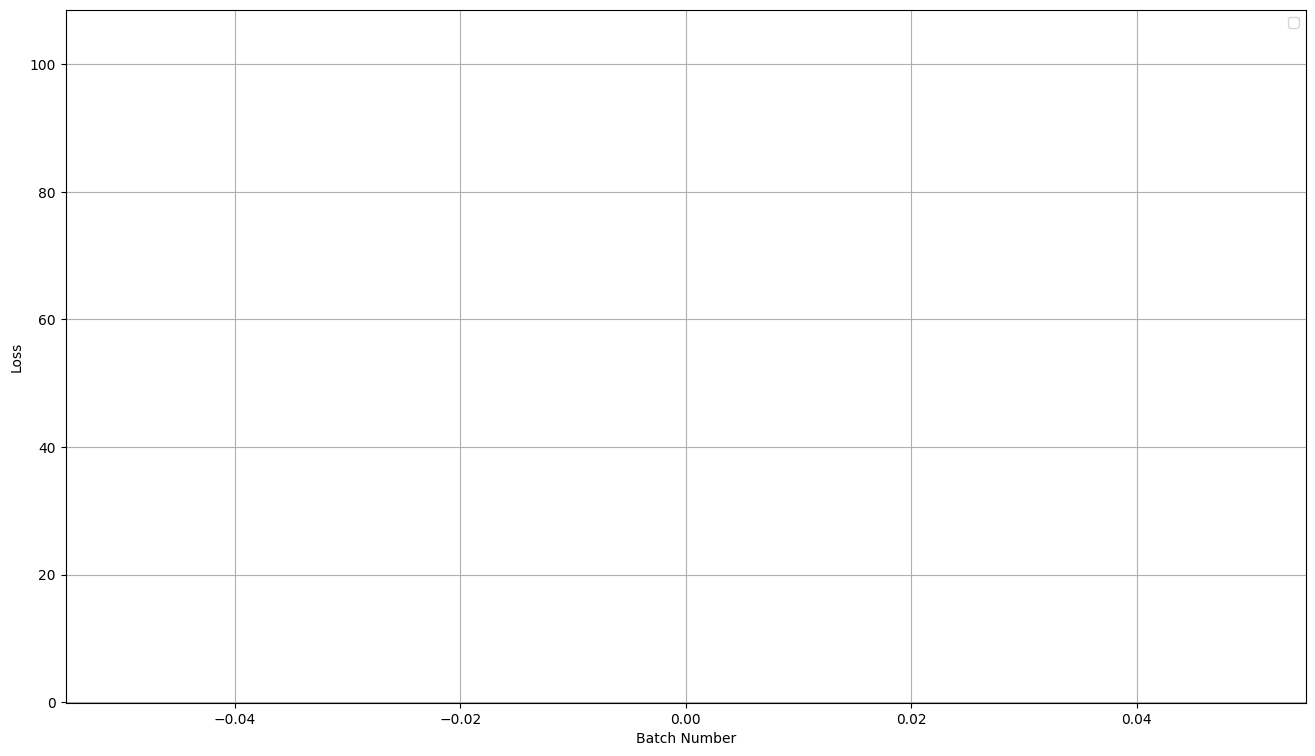

In [ ]:
import matplotlib.pyplot as plt

# epe_losses = list(map(lambda x: x.item(), epe_losses[0]))
# overall_losses = list(map(lambda x: x.item(), overall_losses[0]))

plt.figure(figsize=(16, 9))
len_x = min(len(epe_losses), len(overall_losses))

plt.plot(epe_losses[:len_x])
plt.plot(overall_losses[:len_x])

plt.xlabel('Batch Number')
plt.ylabel('Loss')

plt.grid()
plt.legend()

plt.show()

In [ ]:
import time
# Create the directory if it doesn't exist
# if not os.path.exists('checkpoints'):
#     os.makedirs('checkpoints')

current_time = time.strftime("%Y%m%d-%H%M%S")
model_path = f"models/model_{current_time}_epoch4.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
model.load_state_dict(torch.load('../../models/model_20240715-041739.pth', map_location=device))

<All keys matched successfully>

In [ ]:
model.eval()
flow: torch.Tensor = torch.tensor([]).to(device)

prev_event_volumes = [torch.zeros([args.batch_size, 3, 480, 640])] # Acts as a queue

with torch.no_grad():
    print("start test")
    for batch in tqdm(test_data):
        batch: Dict[str, Any]

        event_image = batch["event_volume"].to(device)
        prev_event_volumes.append(event_image)

        flows = model(prev_event_volumes[0],
                      prev_event_volumes[1],
                      iters=args.iters)

        batch_flow = flows[-1] # [B, 3, 480, 640]
        flow = torch.cat((flow, batch_flow), dim=0)  # [N, 2, 480, 640]

        if len(prev_event_volumes) >= BATCH_CONCAT:
            prev_event_volumes.pop(0)

    print("test done")
# ------------------
#  save submission
# ------------------
current_time = time.strftime("%Y%m%d-%H%M%S")
save_optical_flow_to_npy(flow, f'../../submissions/submission_raft_{current_time}')

start test


  0%|          | 0/97 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a0f870bac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a0f870bac0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError  File "/us

RuntimeError: split_with_sizes expects split_sizes to sum exactly to 7 (input tensor's size at dimension 0), but got split_sizes=[6, 6]